In [3]:
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [152]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.neural_network import BernoulliRBM
from torch.utils.data import DataLoader, TensorDataset
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import torch.distributions as dist

warnings.filterwarnings('ignore')

# Dataset: CTG

In [153]:
# create dictionary for categorical column
cardio_dtypes = {"CLASS": "category"} 
cardio = pd.read_csv("CTG.csv", dtype=cardio_dtypes)
cardio.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0.000,0.0,0.000,0.000,0.0,0.0,73,0.5,43,...,126,2,0,120,137,121,73,1,9,2
1,132,0.006,0.0,0.006,0.003,0.0,0.0,17,2.1,0,...,198,6,1,141,136,140,12,0,6,1
2,133,0.003,0.0,0.008,0.003,0.0,0.0,16,2.1,0,...,198,5,1,141,135,138,13,0,6,1
3,134,0.003,0.0,0.008,0.003,0.0,0.0,16,2.4,0,...,170,11,0,137,134,137,13,1,6,1
4,132,0.007,0.0,0.008,0.000,0.0,0.0,16,2.4,0,...,170,9,0,137,136,138,11,1,2,1


In [154]:

# getting the columns of the dataset
columns = list(cardio.columns)
columns

['LB',
 'AC',
 'FM',
 'UC',
 'DL',
 'DS',
 'DP',
 'ASTV',
 'MSTV',
 'ALTV',
 'MLTV',
 'Width',
 'Min',
 'Max',
 'Nmax',
 'Nzeros',
 'Mode',
 'Mean',
 'Median',
 'Variance',
 'Tendency',
 'CLASS',
 'NSP']

In [155]:
# check datatype in each column, all data types are correct
print("Column datatypes: ")
print(cardio.dtypes)
# checking the number of rows and columns
cardio.shape

Column datatypes: 
LB             int64
AC           float64
FM           float64
UC           float64
DL           float64
DS           float64
DP           float64
ASTV           int64
MSTV         float64
ALTV           int64
MLTV         float64
Width          int64
Min            int64
Max            int64
Nmax           int64
Nzeros         int64
Mode           int64
Mean           int64
Median         int64
Variance       int64
Tendency       int64
CLASS       category
NSP            int64
dtype: object


(2126, 23)

In [156]:
cardio['NSP']

0       2
1       1
2       1
3       1
4       1
       ..
2121    2
2122    2
2123    2
2124    2
2125    1
Name: NSP, Length: 2126, dtype: int64

# Imbalance Ratios for the Classes (The smaller the better)

In [157]:
class_counts = cardio["CLASS"].value_counts()
print('Imbalance ratio (IR) per class:')
print(np.sum(class_counts)/class_counts)

# print('Class count:')
# print(class_counts)

Imbalance ratio (IR) per class:
CLASS
2      3.671848
1      5.536458
6      6.403614
7      8.436508
10    10.791878
8     19.869159
4     26.246914
5     29.527778
9     30.811594
3     40.113208
Name: count, dtype: float64


In [158]:
rows_with_nan = cardio[cardio.isna().any(axis=1)]
print("Rows that contain at least one NaN value:")
print(rows_with_nan)

Rows that contain at least one NaN value:
Empty DataFrame
Columns: [LB, AC, FM, UC, DL, DS, DP, ASTV, MSTV, ALTV, MLTV, Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency, CLASS, NSP]
Index: []

[0 rows x 23 columns]


In [159]:
cardio.dropna(inplace=True)
rows_with_nan = cardio[cardio.isna().any(axis=1)]
print("Rows that contain at least one NaN value:")
print(rows_with_nan)

Rows that contain at least one NaN value:
Empty DataFrame
Columns: [LB, AC, FM, UC, DL, DS, DP, ASTV, MSTV, ALTV, MLTV, Width, Min, Max, Nmax, Nzeros, Mode, Mean, Median, Variance, Tendency, CLASS, NSP]
Index: []

[0 rows x 23 columns]


# Splitting and Heirarchical Clustering

In [160]:
# Create a copy to avoid modifying the original DataFrame
df_numeric = cardio.copy()

# Convert columns with 'category' dtype (except 'CLASS') to numeric type
for col in df_numeric.select_dtypes(include=['category']).columns:
    if col != 'CLASS':
        # If the category labels are numeric, this conversion works:
        df_numeric[col] = df_numeric[col].astype(float)


Class Feature Centers:
               LB        AC        FM        UC        DL        DS        DP  \
CLASS                                                                           
1      132.820312  0.000456  0.001708  0.004268  0.000188  0.000000  0.000000   
10     142.040609  0.000117  0.004340  0.001685  0.000168  0.000000  0.000000   
2      132.519862  0.006333  0.004731  0.004349  0.000302  0.000000  0.000000   
3      129.433962  0.000377  0.004792  0.003792  0.000189  0.000000  0.000000   
4      133.580247  0.011457  0.023753  0.004432  0.000235  0.000000  0.000000   
5      141.625000  0.000611  0.002889  0.003653  0.000153  0.000000  0.000000   
6      130.322289  0.005259  0.020633  0.005684  0.004473  0.000003  0.000154   
7      132.476190  0.000337  0.008536  0.005627  0.006214  0.000000  0.000246   
8      128.084112  0.000645  0.029701  0.005794  0.006028  0.000056  0.001981   
9      137.057971  0.000000  0.019435  0.000667  0.000014  0.000000  0.000174   

    

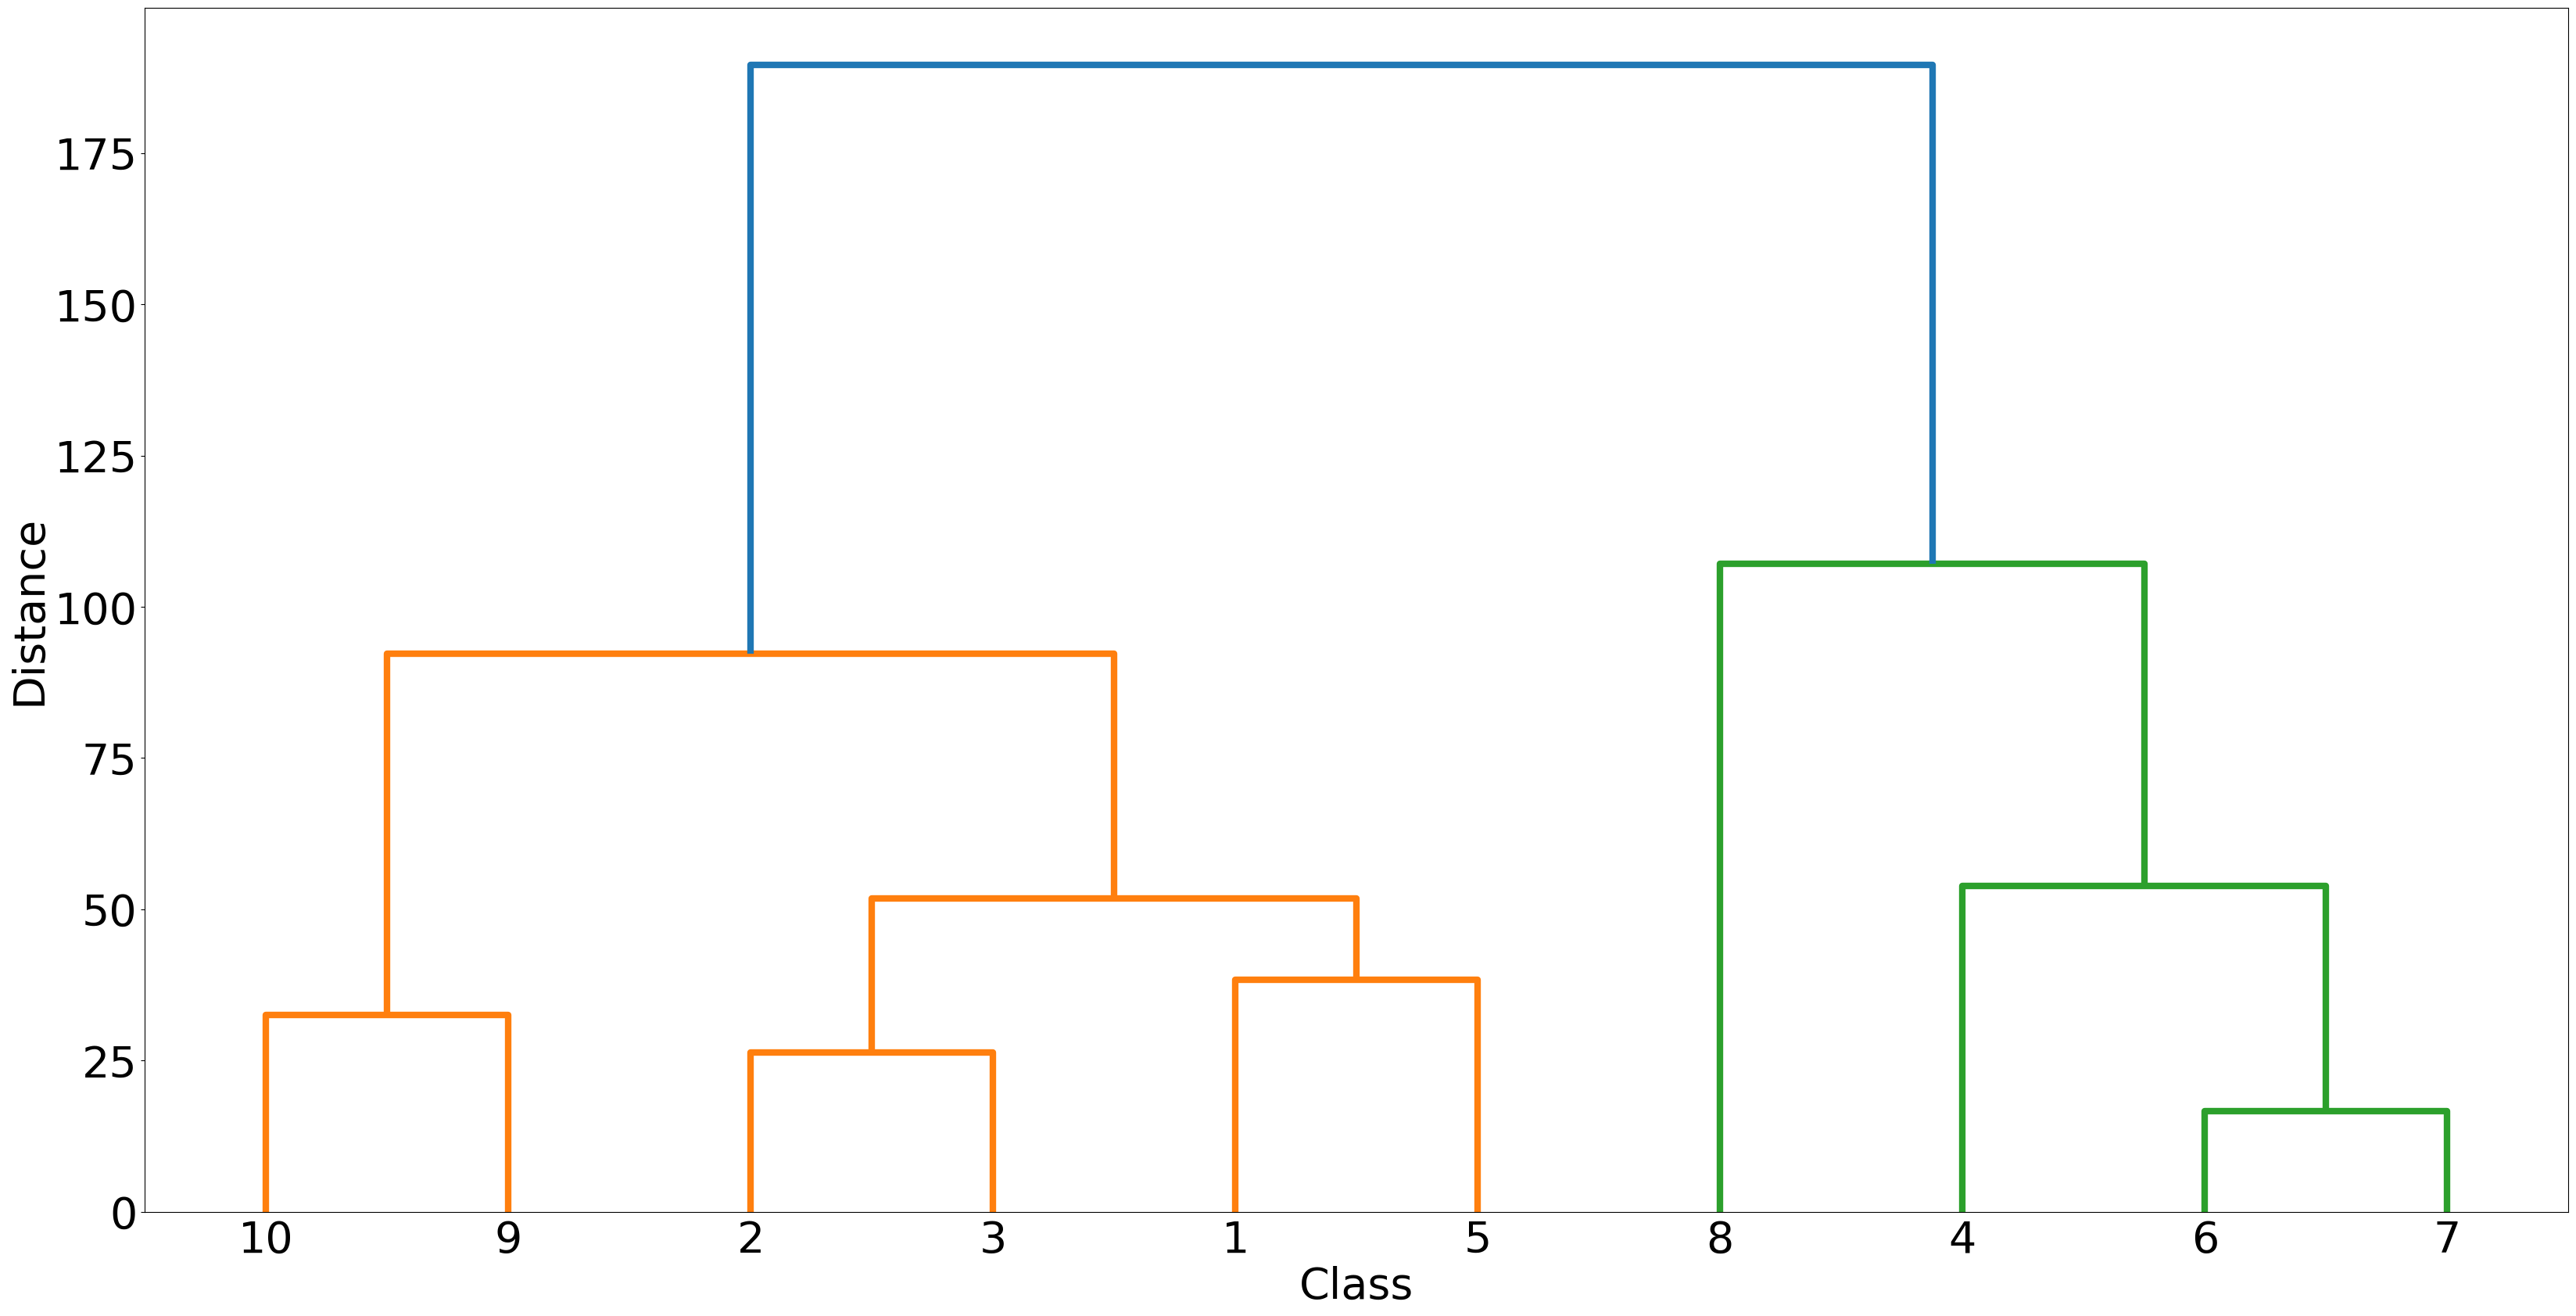

In [216]:

# Use all columns except 'CLASS' for computing feature centers
feature_columns = [col for col in df_numeric.columns if col != 'CLASS']
feature_columns = [col for col in feature_columns if col != 'NSP']


# Compute class feature centers: group by 'CLASS' and take the mean of all features
class_centers = df_numeric.groupby('CLASS')[feature_columns].mean()
print("Class Feature Centers:")

print(class_centers)

# Convert the class centers DataFrame to a NumPy array.
centers_array = class_centers.values

# Perform Ward-linkage hierarchical clustering on the class centers.
Z = linkage(centers_array, method='ward')

# Plot the dendrogram to visualize the clustering.
plt.figure(figsize=(40, 20))
plt.rcParams['lines.linewidth'] = 6
plt.rc('ytick', labelsize=40)
dendrogram(Z, labels=class_centers.index.astype(str).tolist(), orientation='top')
ax = plt.gca()
for label in ax.get_xticklabels():
    label.set_fontsize(40)
# plt.title('Hierarchical Clustering Dendrogram (Ward Linkage) for Class Feature Centers')
plt.xlabel('Class',size=40)
plt.ylabel('Distance',size=40)
plt.show()

# # Optionally, assign clusters (e.g., to form 3 clusters)
# num_clusters = 8
# cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
# print("Cluster labels for each class:")
# for cls, label in zip(class_centers.index, cluster_labels):
#     print(f"Class {cls}: Cluster {label}")


In [162]:
for num_clusters in range(2,10):
    # num_clusters = 4 #visually set
    cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
    # print("Cluster labels for each class:")
    # for cls, label in zip(class_centers.index, cluster_labels):
    #     print(f"Class {cls}: Cluster {label}")
    
    # Step 3: Allocate all samples to clusters based on their class.
    # Create a mapping from class label to cluster label.
    class_to_cluster = dict(zip(class_centers.index, cluster_labels))
    # print("\nMapping of Class to Cluster:")
    # print(class_to_cluster)
    
    # Add a new column to the DataFrame for the cluster.
    df_numeric['cluster'] = df_numeric['CLASS'].map(class_to_cluster)
    
    # Check the allocation by grouping the samples by their cluster.
    # for cluster_label, group in df_numeric.groupby('cluster'):
        # print(f"Cluster {cluster_label}: {group.shape[0]} samples")
    
    cluster_to_class = {v: k for k, v in class_to_cluster.items()}
    # print("Cluster to Class Mapping:", cluster_to_class)
    # Compute silhouette score
    sil_score = silhouette_score(centers_array, cluster_labels)
    print(f'{num_clusters} clusters: Silhouette Score: {sil_score}')


2 clusters: Silhouette Score: 0.4161725121652625
3 clusters: Silhouette Score: 0.37020825715656047
4 clusters: Silhouette Score: 0.32308963877696534
5 clusters: Silhouette Score: 0.3053069878064645
6 clusters: Silhouette Score: 0.27239913049038555
7 clusters: Silhouette Score: 0.23305417369925782
8 clusters: Silhouette Score: 0.18921175033837045
9 clusters: Silhouette Score: 0.18921175033837045


In [217]:
num_clusters = 4 #visually set
num_classes = 10
cluster_labels = fcluster(Z, num_clusters, criterion='maxclust')
print("Cluster labels for each class:")
for cls, label in zip(class_centers.index, cluster_labels):
    print(f"Class {cls}: Cluster {label}")

# Step 3: Allocate all samples to clusters based on their class.
# Create a mapping from class label to cluster label.
class_to_cluster = dict(zip(class_centers.index, cluster_labels))
print("\nMapping of Class to Cluster:")
print(class_to_cluster)

# Add a new column to the DataFrame for the cluster.
df_numeric['cluster'] = df_numeric['CLASS'].map(class_to_cluster)

# Check the allocation by grouping the samples by their cluster.
for cluster_label, group in df_numeric.groupby('cluster'):
    print(f"Cluster {cluster_label}: {group.shape[0]} samples")

cluster_to_class = {v: k for k, v in class_to_cluster.items()}
print("Cluster to Class Mapping:", cluster_to_class)

Cluster labels for each class:
Class 1: Cluster 2
Class 10: Cluster 1
Class 2: Cluster 2
Class 3: Cluster 2
Class 4: Cluster 3
Class 5: Cluster 2
Class 6: Cluster 3
Class 7: Cluster 3
Class 8: Cluster 4
Class 9: Cluster 1

Mapping of Class to Cluster:
{'1': 2, '10': 1, '2': 2, '3': 2, '4': 3, '5': 2, '6': 3, '7': 3, '8': 4, '9': 1}
Cluster 1: 266 samples
Cluster 2: 1088 samples
Cluster 3: 665 samples
Cluster 4: 107 samples
Cluster to Class Mapping: {2: '5', 1: '9', 3: '7', 4: '8'}


# Create the dataset

In [164]:
teacher_dataset = df_numeric.copy()
cols_to_drop = []
if 'CLASS' in teacher_dataset.columns:
    cols_to_drop.append('CLASS')
if 'cluster' in teacher_dataset.columns:
    cols_to_drop.append('cluster')

if 'NSP' in teacher_dataset.columns:
    cols_to_drop.append('NSP')

feature_columns = [col for col in teacher_dataset.columns if col not in (cols_to_drop + ['CLASS'])]
num_features = len(feature_columns)

# Extract features and target
X_teacher = teacher_dataset[feature_columns].values.astype(np.float32)
y_teacher = teacher_dataset['CLASS'].values.astype(np.int64)  # assume class labels are integers
y_teacher= y_teacher-1

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_teacher_scaled = scaler.fit_transform(X_teacher)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_teacher_scaled, y_teacher, test_size=0.2, random_state=42,stratify=y_teacher)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)


# Create a dataset from your tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

## Teacher network

In [165]:
# Define Teacher Network with proper tensor initialization
class TeacherNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TeacherNet, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # from input to 56 nodes
        self.fc2 = nn.Linear(hidden_dim, 100)         # from 56 to 100 nodes
        self.fc3 = nn.Linear(100, num_classes) # from 100 to number of classes
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits




## Student network

In [166]:
# Define Student Network (Same structure but different initialization)
class StudentNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # from input to 56 nodes
        self.fc2 = nn.Linear(hidden_dim, 100)         # from 56 to 100 nodes
        self.fc3 = nn.Linear(100, num_classes) # from 100 to number of classes
        
        self.relu = nn.ReLU()
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits



# MLP Baseline

In [131]:
def validate(model,test_loader):
    per_class_corrects = torch.zeros((num_classes,1))
    per_class_count = torch.zeros((num_classes,1))
    with torch.no_grad():
        model.eval()
    model_logits = []
    label_list = []
    for i, (x, y) in enumerate(test_loader):
        logits = model(x)
        _,pred = torch.max(logits,1)
        per_class_corrects[y.item()]+=torch.sum(pred==y)
        per_class_count[y.item()]+=1
        model_logits.append(logits)
        label_list.append(y)

    model_logits_torch = torch.cat(model_logits, dim=0)
    label_list_torch = torch.cat(label_list, dim=0)
    # print(student_logits_torch.shape,label_list_torch.shape)

    reward = multiclass_f1_score(model_logits_torch, label_list_torch, num_classes=10, average="macro")
    return per_class_corrects/per_class_count, reward

In [132]:
seed=5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# Instantiate the teacher network
hidden_dim=56
teacher_model = TeacherNet(num_features, hidden_dim, num_classes)

lr=1e-3
disp_cycle=5
epochs = 500
f1_train=[]
f1_test=[]
corrects_train = []
corrects_test = []
perClassCorrects_ten = []
loss_train=[]
# teacher_model.train()
optim_T = optim.Adam(teacher_model.parameters(), lr=lr)

for epoch in range(epochs):
    sum_loss=0
    sum_rewards=0
    num_corrects=0

    teacher_model.train()
    print(f'Start epoch {epoch}:')
    for i, (x_batch, y_batch) in enumerate(train_loader):
        
        teacher_logits = teacher_model(x_batch)
        L_T = F.cross_entropy(teacher_logits, y_batch) # eq 10 (Supervised loss for the teacher)
        optim_T.zero_grad()
        L_T.backward()
        optim_T.step()
        
        reward = multiclass_f1_score(teacher_logits, y_batch, num_classes=10, average="macro")
        
        _,pred = torch.max(teacher_logits,1)
        num_corrects+= torch.sum(pred==y_batch)
        sum_loss+=L_T
        sum_rewards+=reward
        if (i+1)%disp_cycle==0:
            print(f'Batch {i+1} : F1-macro = {reward}, Loss: {L_T}, total acc = {torch.sum(pred==y_batch)/x_batch.shape[0]}')

    per_class_corrects_test, f1_score_test = validate(teacher_model,val_loader)

    
    print(f'Epoch {epoch}- Validation: Average F1-macro: {f1_score_test}')
    print('####################################################################################################################')
    f1_train.append(sum_rewards/(i+1))
    f1_test.append(f1_score_test)
    corrects_train.append(torch.sum(pred==y_batch)/x_batch.shape[0])
    perClassCorrects_ten.append(per_class_corrects_test)
    loss_train.append(sum_loss/(i+1))

Start epoch 0:
Batch 5 : F1-macro = 0.11663299798965454, Loss: 2.22652268409729, total acc = 0.34375
Batch 10 : F1-macro = 0.1392623633146286, Loss: 2.1567740440368652, total acc = 0.328125
Batch 15 : F1-macro = 0.18518517911434174, Loss: 2.002579689025879, total acc = 0.515625
Batch 20 : F1-macro = 0.24479857087135315, Loss: 1.965253233909607, total acc = 0.4375
Batch 25 : F1-macro = 0.18518516421318054, Loss: 1.8289992809295654, total acc = 0.4375


Epoch 0- Validation: Average F1-macro: 0.24571485817432404
####################################################################################################################
Start epoch 1:
Batch 5 : F1-macro = 0.24501028656959534, Loss: 1.7670295238494873, total acc = 0.453125
Batch 10 : F1-macro = 0.3116293251514435, Loss: 1.6888961791992188, total acc = 0.46875
Batch 15 : F1-macro = 0.29749375581741333, Loss: 1.507654070854187, total acc = 0.59375
Batch 20 : F1-macro = 0.33820852637290955, Loss: 1.5698587894439697, total acc = 0.53125
Batch 25 : F1-macro = 0.3655853569507599, Loss: 1.5077189207077026, total acc = 0.578125


Epoch 1- Validation: Average F1-macro: 0.33871740102767944
####################################################################################################################
Start epoch 2:
Batch 5 : F1-macro = 0.3802364468574524, Loss: 1.303000569343567, total acc = 0.671875
Batch 10 : F1-macro = 0.4265432357788086, Loss: 1.3373932838439941, total acc = 0.640625
Batch 15 : F1-macro = 0.42916563153266907, Loss: 1.285901665687561, total acc = 0.59375
Batch 20 : F1-macro = 0.4937579929828644, Loss: 1.1151167154312134, total acc = 0.734375
Batch 25 : F1-macro = 0.49457788467407227, Loss: 1.0572487115859985, total acc = 0.703125


Epoch 2- Validation: Average F1-macro: 0.4278557300567627
####################################################################################################################
Start epoch 3:
Batch 5 : F1-macro = 0.4708409309387207, Loss: 0.8945423364639282, total acc = 0.75
Batch 10 : F1-macro = 0.418400377035141, Loss: 1.0239025354385376, total acc = 0.703125
Batch 15 : F1-macro = 0.38953879475593567, Loss: 1.1068167686462402, total acc = 0.578125
Batch 20 : F1-macro = 0.5294532775878906, Loss: 0.8766559958457947, total acc = 0.765625
Batch 25 : F1-macro = 0.46908044815063477, Loss: 0.8337178826332092, total acc = 0.75


KeyboardInterrupt: 

# Plotting training results

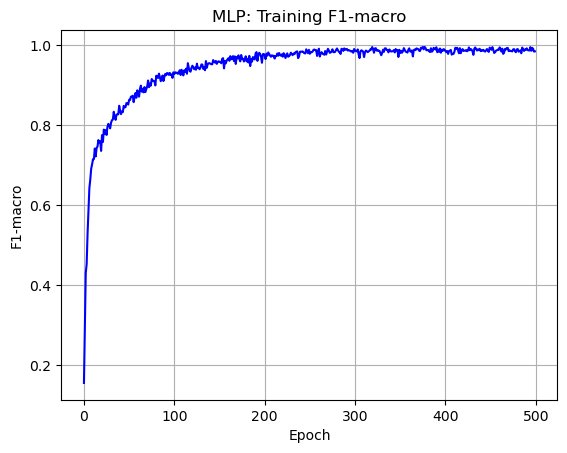

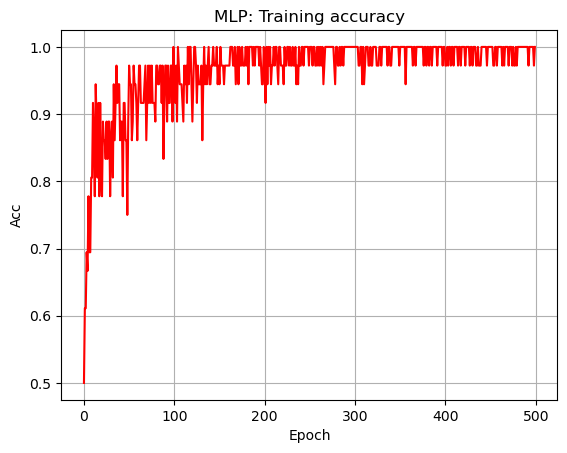

In [59]:
plt.figure(110)
plt.plot(f1_train, 'b')
plt.title(f'MLP: Training F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

plt.figure(111)
plt.plot(corrects_train, 'r')
plt.title(f'MLP: Training accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.grid()

# Plotting validation results

<function matplotlib.pyplot.show(close=None, block=None)>

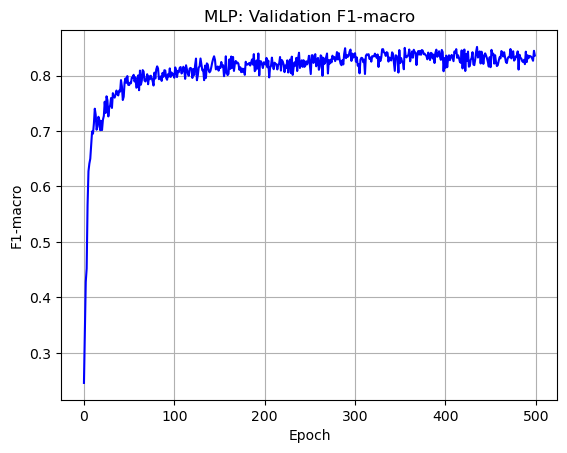

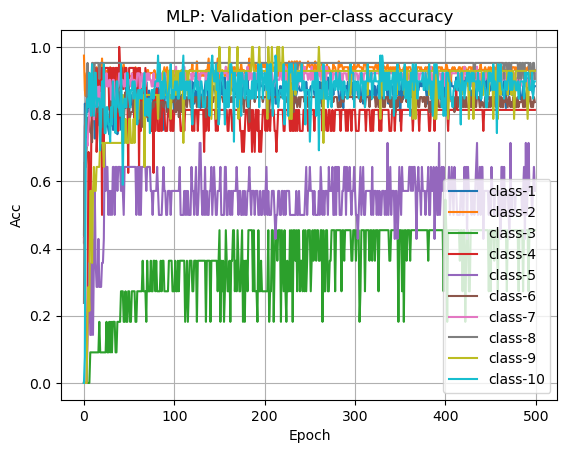

In [60]:
plt.figure(110)
plt.plot(f1_test, 'b')
plt.title(f'MLP: Validation F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

corrects_test_numpy2 = np.squeeze(np.array(perClassCorrects_ten))
lgd_str = []
for i in range(num_classes):
    lgd_str.append('class-'+str(i+1))
    
plt.figure(15514)
for line in corrects_test_numpy2.T:
    
    plt.plot(line)
    
plt.title(f'MLP: Validation per-class accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

# Save results

In [61]:
np.savetxt("NoInitMLP_f1_test.csv", f1_test, delimiter=",")
np.savetxt("NoInitMLP_f1_train.csv", f1_train, delimiter=",")

np.savetxt("NoInitMLP_per_class_acc_test.csv", corrects_test_numpy2, delimiter=",")
np.savetxt("NoInitMLP_total_acc_train.csv", corrects_train, delimiter=",")

# FKD only (No RL)

## FKD Training Pipeline

In [167]:
def get_cluster(class_label,class_to_cluster,shift=1):
    cluster_ids = np.array(list(class_to_cluster.values()))
    class_ids = np.array(list(map(int,list(class_to_cluster.keys()))))-shift
    target_class_id = np.where(class_ids==class_label)
    return cluster_ids[target_class_id].item()

In [170]:
def validate_students(students,test_loader):
    
    per_studnet_corrects = torch.zeros((len(students),1))
    per_class_corrects = torch.zeros((num_classes,1))
    
    per_cluster_count = torch.zeros((len(students),1))
    per_class_count = torch.zeros((num_classes,1))
    for cluster_id in range(len(students)):
        with torch.no_grad():
            students[cluster_id].eval()
            
    student_logits = []
    label_list = []
    for i, (x, y) in enumerate(test_loader):
        cluster_id = get_cluster(y.item(),class_to_cluster)-1
        logits = students[cluster_id](x)
        _,pred = torch.max(logits,1)
        per_studnet_corrects[cluster_id]+=torch.sum(pred==y)
        per_cluster_count[cluster_id]+=1
        per_class_corrects[y.item()]+=torch.sum(pred==y)
        per_class_count[y.item()]+=1
        student_logits.append(logits)
        label_list.append(y)

    student_logits_torch = torch.cat(student_logits, dim=0)
    label_list_torch = torch.cat(label_list, dim=0)
    # print(student_logits_torch.shape,label_list_torch.shape)

    reward = multiclass_f1_score(student_logits_torch, label_list_torch, num_classes=10, average="macro")
    return per_studnet_corrects/per_cluster_count, per_class_corrects/per_class_count, reward

In [171]:
seed=5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# Instantiate the teacher network
hidden_dim=56
teacher_model = TeacherNet(num_features, hidden_dim, num_classes)

# Instantiate the student network
students = {}
for cluster_id in range(num_clusters):
    student_model = StudentNet(num_features, hidden_dim, num_classes)
    students[cluster_id] = student_model

lr=1e-3
lamda=0.5
T=5
disp_cycle=5
epochs = 500
f1_train=[]
f1_test=[]
corrects_train = []
corrects_test = []
perClassCorrects_ten = []
loss_train=[]
teacher_model.train()
optim_T = optim.Adam(teacher_model.parameters(), lr=lr)
optim_S = {}
for cluster_id in range(num_clusters):
    optim_S[cluster_id] = optim.Adam(students[cluster_id].parameters(), lr=lr)

for epoch in range(epochs):
    
    for student in students.values():
        student.train()
    sum_loss=0
    sum_rewards=0

    student_corrects=0
    print(f'Epoch {epoch}:')
    for i, (x_batch, y_batch) in enumerate(train_loader):

        x_batch_teacher = []
        y_batch_teacher = []
        student_logits = []
        batch_clusters=np.array([])
        for y in y_batch:
            batch_clusters = np.append(batch_clusters,get_cluster(y.item(),class_to_cluster))
        for cluster_id in range(len(students)):
            idx = np.where(batch_clusters==cluster_id+1)
            x_batch_clustered = x_batch[idx] 
            y_batch_clustered = y_batch[idx]
            logits = students[cluster_id](x_batch_clustered)

            student_logits.append(logits)
            x_batch_teacher.append(x_batch_clustered)
            y_batch_teacher.append(y_batch_clustered)

        student_logits = torch.cat(student_logits, dim=0)

        x_batch_teacher = torch.cat(x_batch_teacher, dim=0)
        y_batch_teacher = torch.cat(y_batch_teacher, dim=0)

        teacher_logits = teacher_model(x_batch_teacher)
        
        state = torch.cat((x_batch_teacher, torch.softmax(teacher_logits, dim=1), torch.softmax(student_logits, dim=1)), dim=1)
        L_T = F.cross_entropy(teacher_logits, y_batch_teacher) # eq 10 (Supervised loss for the teacher)
        optim_T.zero_grad()
        L_T.backward(retain_graph = True)
        optim_T.step()

        L_SS = lamda * F.cross_entropy(student_logits, y_batch_teacher) # 1st term of eq 11 (the supervised part)

        L_TS = (1-lamda) * F.cross_entropy(student_logits/T, torch.softmax(teacher_logits.detach()/T, dim=1).detach()) # 2nd term of eq 11 (the transfer learning part)

        L_S = L_TS + L_SS
        for cluster_id in range(len(students)):
            optim_S[cluster_id].zero_grad()
        

        L_S.backward()

        for cluster_id in range(len(students)):
            optim_S[cluster_id].step()

        reward = multiclass_f1_score(student_logits, y_batch_teacher, num_classes=10, average="macro")
        
        _,pred = torch.max(student_logits,1)
        student_corrects+= torch.sum(pred==y_batch_teacher)
        sum_loss+=L_S
        sum_rewards+=reward
        if (i+1)%disp_cycle==0:
            print(f'Batch {i+1} : F1-macro = {reward}, Losses (T, S): ({L_T}, {L_S}), total student acc = {torch.sum(pred==y_batch_teacher)/x_batch.shape[0]}')

    per_studnet_corrects_test, per_class_corrects_test, f1_score_test = validate_students(students,val_loader)

    
    print(f'Epoch {epoch}- Validation: Average F1-macro: {f1_score_test}, Per student acc: {per_studnet_corrects_test.view(-1)}')
    print('####################################################################################################################')
    f1_train.append(sum_rewards/(i+1))
    f1_test.append(f1_score_test)
    corrects_train.append(torch.sum(pred==y_batch_teacher)/x_batch.shape[0])
    corrects_test.append(per_studnet_corrects_test)
    perClassCorrects_ten.append(per_class_corrects_test)
    loss_train.append(sum_loss/(i+1))

Epoch 0:
Batch 5 : F1-macro = 0.3049047589302063, Losses (T, S): (2.221216917037964, 2.2352471351623535), total student acc = 0.390625


Batch 10 : F1-macro = 0.516785740852356, Losses (T, S): (2.1599504947662354, 2.1477835178375244), total student acc = 0.640625
Batch 15 : F1-macro = 0.6210001707077026, Losses (T, S): (2.132826089859009, 2.0214240550994873), total student acc = 0.609375
Batch 20 : F1-macro = 0.6622003316879272, Losses (T, S): (1.9936085939407349, 1.92006254196167), total student acc = 0.78125


Batch 25 : F1-macro = 0.47528010606765747, Losses (T, S): (1.9251682758331299, 1.824638843536377), total student acc = 0.625


Epoch 0- Validation: Average F1-macro: 0.5548331141471863, Per student acc: tensor([0.7358, 0.6881, 0.6864, 1.0000, 1.0000])
####################################################################################################################
Epoch 1:
Batch 5 : F1-macro = 0.7242742776870728, Losses (T, S): (1.7119765281677246, 1.669743299484253), total student acc = 0.75
Batch 10 : F1-macro = 0.5857109427452087, Losses (T, S): (1.7471870183944702, 1.6540943384170532), total student acc = 0.75


Batch 15 : F1-macro = 0.5218254327774048, Losses (T, S): (1.6847457885742188, 1.683964729309082), total student acc = 0.703125
Batch 20 : F1-macro = 0.5178006887435913, Losses (T, S): (1.6114681959152222, 1.5782854557037354), total student acc = 0.671875
Batch 25 : F1-macro = 0.5334832668304443, Losses (T, S): (1.2820665836334229, 1.4753061532974243), total student acc = 0.796875


Epoch 1- Validation: Average F1-macro: 0.6684694290161133, Per student acc: tensor([0.8113, 0.7844, 0.8305, 1.0000, 1.0000])
####################################################################################################################
Epoch 2:
Batch 5 : F1-macro = 0.7888889312744141, Losses (T, S): (1.3359482288360596, 1.458551049232483), total student acc = 0.828125
Batch 10 : F1-macro = 0.6498376727104187, Losses (T, S): (1.2755849361419678, 1.4431980848312378), total student acc = 0.796875


Batch 15 : F1-macro = 0.6446477174758911, Losses (T, S): (1.19295072555542, 1.4413659572601318), total student acc = 0.796875
Batch 20 : F1-macro = 0.6393400430679321, Losses (T, S): (1.1176393032073975, 1.3855266571044922), total student acc = 0.859375
Batch 25 : F1-macro = 0.5959440469741821, Losses (T, S): (1.1587495803833008, 1.4372258186340332), total student acc = 0.796875


Epoch 2- Validation: Average F1-macro: 0.6653318405151367, Per student acc: tensor([0.7925, 0.8028, 0.8729, 1.0000, 1.0000])
####################################################################################################################
Epoch 3:
Batch 5 : F1-macro = 0.7368959784507751, Losses (T, S): (0.9965611696243286, 1.3660658597946167), total student acc = 0.890625
Batch 10 : F1-macro = 0.6646942496299744, Losses (T, S): (1.0388635396957397, 1.3865891695022583), total student acc = 0.8125


Batch 15 : F1-macro = 0.5749713182449341, Losses (T, S): (1.1324512958526611, 1.4563121795654297), total student acc = 0.71875
Batch 20 : F1-macro = 0.7149608135223389, Losses (T, S): (0.8232750296592712, 1.356719732284546), total student acc = 0.875
Batch 25 : F1-macro = 0.7171862721443176, Losses (T, S): (0.8431575298309326, 1.3336156606674194), total student acc = 0.859375


Epoch 3- Validation: Average F1-macro: 0.6926493644714355, Per student acc: tensor([0.8113, 0.8211, 0.9068, 1.0000, 1.0000])
####################################################################################################################
Epoch 4:
Batch 5 : F1-macro = 0.7342292070388794, Losses (T, S): (0.7492443919181824, 1.327181339263916), total student acc = 0.828125
Batch 10 : F1-macro = 0.7212021350860596, Losses (T, S): (0.8244502544403076, 1.3211097717285156), total student acc = 0.875


Batch 15 : F1-macro = 0.6722755432128906, Losses (T, S): (0.7522789835929871, 1.2852809429168701), total student acc = 0.921875
Batch 20 : F1-macro = 0.8020759224891663, Losses (T, S): (0.6792292594909668, 1.2815388441085815), total student acc = 0.90625
Batch 25 : F1-macro = 0.6577767133712769, Losses (T, S): (0.7774219512939453, 1.344457983970642), total student acc = 0.796875


Epoch 4- Validation: Average F1-macro: 0.7274010181427002, Per student acc: tensor([0.8113, 0.8349, 0.9153, 1.0000, 1.0000])
####################################################################################################################
Epoch 5:
Batch 5 : F1-macro = 0.6304545402526855, Losses (T, S): (0.7234352231025696, 1.2965757846832275), total student acc = 0.84375
Batch 10 : F1-macro = 0.8826839327812195, Losses (T, S): (0.619731605052948, 1.2611185312271118), total student acc = 0.90625


Batch 15 : F1-macro = 0.7013610601425171, Losses (T, S): (0.49847230315208435, 1.2199842929840088), total student acc = 0.90625
Batch 20 : F1-macro = 0.7061995267868042, Losses (T, S): (0.8592633008956909, 1.3395025730133057), total student acc = 0.828125
Batch 25 : F1-macro = 0.7879104018211365, Losses (T, S): (0.724422812461853, 1.2782247066497803), total student acc = 0.859375


Epoch 5- Validation: Average F1-macro: 0.7712164521217346, Per student acc: tensor([0.8113, 0.8532, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 6:
Batch 5 : F1-macro = 0.7575801014900208, Losses (T, S): (0.5457647442817688, 1.2381956577301025), total student acc = 0.875
Batch 10 : F1-macro = 0.6632927656173706, Losses (T, S): (0.6205248832702637, 1.2083401679992676), total student acc = 0.90625


Batch 15 : F1-macro = 0.8932198286056519, Losses (T, S): (0.536141574382782, 1.2203748226165771), total student acc = 0.921875
Batch 20 : F1-macro = 0.7908502817153931, Losses (T, S): (0.6258161067962646, 1.2402877807617188), total student acc = 0.875
Batch 25 : F1-macro = 0.8106630444526672, Losses (T, S): (0.5914043188095093, 1.2043217420578003), total student acc = 0.921875


Epoch 6- Validation: Average F1-macro: 0.7746586203575134, Per student acc: tensor([0.8491, 0.8578, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 7:
Batch 5 : F1-macro = 0.8544496297836304, Losses (T, S): (0.5559114217758179, 1.183671474456787), total student acc = 0.9375
Batch 10 : F1-macro = 0.9155238270759583, Losses (T, S): (0.5680719614028931, 1.18362557888031), total student acc = 0.953125


Batch 15 : F1-macro = 0.6302105188369751, Losses (T, S): (0.5680232644081116, 1.2315962314605713), total student acc = 0.859375
Batch 20 : F1-macro = 0.75556480884552, Losses (T, S): (0.700272262096405, 1.2621698379516602), total student acc = 0.828125
Batch 25 : F1-macro = 0.8644688725471497, Losses (T, S): (0.47556760907173157, 1.1400830745697021), total student acc = 0.9375


Epoch 7- Validation: Average F1-macro: 0.7891810536384583, Per student acc: tensor([0.8491, 0.8578, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 8:
Batch 5 : F1-macro = 0.8875000476837158, Losses (T, S): (0.4822094440460205, 1.1539466381072998), total student acc = 0.90625
Batch 10 : F1-macro = 0.8567968010902405, Losses (T, S): (0.5218143463134766, 1.1800227165222168), total student acc = 0.890625


Batch 15 : F1-macro = 0.8691742420196533, Losses (T, S): (0.6716485023498535, 1.2349506616592407), total student acc = 0.890625
Batch 20 : F1-macro = 0.8634984493255615, Losses (T, S): (0.470883846282959, 1.1454172134399414), total student acc = 0.90625


Batch 25 : F1-macro = 0.7370238304138184, Losses (T, S): (0.588123619556427, 1.1785297393798828), total student acc = 0.90625


Epoch 8- Validation: Average F1-macro: 0.7875699400901794, Per student acc: tensor([0.8491, 0.8486, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 9:
Batch 5 : F1-macro = 0.7702763676643372, Losses (T, S): (0.5547212362289429, 1.1802595853805542), total student acc = 0.859375


Batch 10 : F1-macro = 0.8026077151298523, Losses (T, S): (0.49922850728034973, 1.1387059688568115), total student acc = 0.90625
Batch 15 : F1-macro = 0.9364293813705444, Losses (T, S): (0.41061657667160034, 1.1091712713241577), total student acc = 0.953125


Batch 20 : F1-macro = 0.9438095092773438, Losses (T, S): (0.4817950129508972, 1.1520435810089111), total student acc = 0.9375
Batch 25 : F1-macro = 0.7333386540412903, Losses (T, S): (0.6039984822273254, 1.162684679031372), total student acc = 0.890625


Epoch 9- Validation: Average F1-macro: 0.7842901945114136, Per student acc: tensor([0.8113, 0.8532, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 10:
Batch 5 : F1-macro = 0.8467380404472351, Losses (T, S): (0.5257440209388733, 1.1658344268798828), total student acc = 0.921875
Batch 10 : F1-macro = 0.8308095932006836, Losses (T, S): (0.5394739508628845, 1.1670747995376587), total student acc = 0.875


Batch 15 : F1-macro = 0.7537814974784851, Losses (T, S): (0.49335727095603943, 1.1582142114639282), total student acc = 0.890625
Batch 20 : F1-macro = 0.8574833869934082, Losses (T, S): (0.468068391084671, 1.1501270532608032), total student acc = 0.90625
Batch 25 : F1-macro = 0.7800000309944153, Losses (T, S): (0.37765946984291077, 1.0815926790237427), total student acc = 0.9375


Epoch 10- Validation: Average F1-macro: 0.7768516540527344, Per student acc: tensor([0.8302, 0.8349, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 11:
Batch 5 : F1-macro = 0.9109205007553101, Losses (T, S): (0.4331655502319336, 1.1052417755126953), total student acc = 0.9375
Batch 10 : F1-macro = 0.9210710525512695, Losses (T, S): (0.39884185791015625, 1.1060481071472168), total student acc = 0.953125


Batch 15 : F1-macro = 0.7310912013053894, Losses (T, S): (0.4508625268936157, 1.1054844856262207), total student acc = 0.890625
Batch 20 : F1-macro = 0.8342193365097046, Losses (T, S): (0.3439582288265228, 1.0644586086273193), total student acc = 0.9375
Batch 25 : F1-macro = 0.7343530654907227, Losses (T, S): (0.5366038680076599, 1.1346862316131592), total student acc = 0.890625


Epoch 11- Validation: Average F1-macro: 0.7974779605865479, Per student acc: tensor([0.8868, 0.8440, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 12:
Batch 5 : F1-macro = 0.9196014404296875, Losses (T, S): (0.4569165110588074, 1.0642952919006348), total student acc = 0.9375
Batch 10 : F1-macro = 0.7652381062507629, Losses (T, S): (0.41471824049949646, 1.0846316814422607), total student acc = 0.90625


Batch 15 : F1-macro = 0.751862108707428, Losses (T, S): (0.4613707363605499, 1.0942577123641968), total student acc = 0.90625
Batch 20 : F1-macro = 0.8622865676879883, Losses (T, S): (0.4902229905128479, 1.1320760250091553), total student acc = 0.90625
Batch 25 : F1-macro = 0.8941666483879089, Losses (T, S): (0.397164523601532, 1.07172429561615), total student acc = 0.921875


Epoch 12- Validation: Average F1-macro: 0.8028450012207031, Per student acc: tensor([0.8491, 0.8532, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 13:
Batch 5 : F1-macro = 0.8945299386978149, Losses (T, S): (0.41412317752838135, 1.0581988096237183), total student acc = 0.953125
Batch 10 : F1-macro = 0.9423076510429382, Losses (T, S): (0.36683332920074463, 1.0452044010162354), total student acc = 0.96875


Batch 15 : F1-macro = 0.9264391660690308, Losses (T, S): (0.3239939212799072, 1.0296465158462524), total student acc = 0.953125
Batch 20 : F1-macro = 0.839286208152771, Losses (T, S): (0.4204598367214203, 1.0542514324188232), total student acc = 0.9375
Batch 25 : F1-macro = 0.8371957540512085, Losses (T, S): (0.5546315312385559, 1.1068205833435059), total student acc = 0.9375


Epoch 13- Validation: Average F1-macro: 0.8039058446884155, Per student acc: tensor([0.8302, 0.8578, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 14:
Batch 5 : F1-macro = 0.8638938069343567, Losses (T, S): (0.683584988117218, 1.157494068145752), total student acc = 0.890625
Batch 10 : F1-macro = 0.9341176748275757, Losses (T, S): (0.3997153639793396, 1.0631954669952393), total student acc = 0.96875


Batch 15 : F1-macro = 0.9473732113838196, Losses (T, S): (0.3785889744758606, 1.0441864728927612), total student acc = 0.953125
Batch 20 : F1-macro = 0.8741275072097778, Losses (T, S): (0.448351114988327, 1.072011947631836), total student acc = 0.9375
Batch 25 : F1-macro = 0.9566137790679932, Losses (T, S): (0.3019919693470001, 1.0428043603897095), total student acc = 0.953125


Epoch 14- Validation: Average F1-macro: 0.8093279004096985, Per student acc: tensor([0.8679, 0.8624, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 15:
Batch 5 : F1-macro = 0.9637564420700073, Losses (T, S): (0.3672899603843689, 1.0385510921478271), total student acc = 0.9375
Batch 10 : F1-macro = 0.8932395577430725, Losses (T, S): (0.4164353609085083, 1.0262750387191772), total student acc = 0.9375


Batch 15 : F1-macro = 0.8722139596939087, Losses (T, S): (0.35823965072631836, 1.0334875583648682), total student acc = 0.9375
Batch 20 : F1-macro = 0.9285023808479309, Losses (T, S): (0.31889304518699646, 0.9985699653625488), total student acc = 0.96875
Batch 25 : F1-macro = 0.7548822164535522, Losses (T, S): (0.23793800175189972, 1.0239096879959106), total student acc = 0.921875


Epoch 15- Validation: Average F1-macro: 0.7878056168556213, Per student acc: tensor([0.8491, 0.8486, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 16:
Batch 5 : F1-macro = 0.8990777730941772, Losses (T, S): (0.35369589924812317, 1.0290979146957397), total student acc = 0.9375
Batch 10 : F1-macro = 0.7961111068725586, Losses (T, S): (0.39880210161209106, 1.0775063037872314), total student acc = 0.90625


Batch 15 : F1-macro = 0.7373536229133606, Losses (T, S): (0.6253284811973572, 1.1059616804122925), total student acc = 0.828125
Batch 20 : F1-macro = 0.8938787579536438, Losses (T, S): (0.38122889399528503, 1.0683948993682861), total student acc = 0.9375
Batch 25 : F1-macro = 0.8367805480957031, Losses (T, S): (0.4807840883731842, 1.0853925943374634), total student acc = 0.875


Epoch 16- Validation: Average F1-macro: 0.8032787442207336, Per student acc: tensor([0.8302, 0.8486, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 17:
Batch 5 : F1-macro = 0.8736715316772461, Losses (T, S): (0.4006348252296448, 1.0472224950790405), total student acc = 0.890625
Batch 10 : F1-macro = 0.8072124719619751, Losses (T, S): (0.3445782959461212, 1.0318257808685303), total student acc = 0.921875


Batch 15 : F1-macro = 0.9322916269302368, Losses (T, S): (0.4257679283618927, 1.0297858715057373), total student acc = 0.9375
Batch 20 : F1-macro = 0.9341667294502258, Losses (T, S): (0.32336923480033875, 0.9803943634033203), total student acc = 0.96875
Batch 25 : F1-macro = 0.8489974737167358, Losses (T, S): (0.42418986558914185, 1.0526498556137085), total student acc = 0.953125


Epoch 17- Validation: Average F1-macro: 0.8233920335769653, Per student acc: tensor([0.9057, 0.8670, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 18:
Batch 5 : F1-macro = 0.9553030133247375, Losses (T, S): (0.4416761100292206, 1.0078792572021484), total student acc = 0.96875
Batch 10 : F1-macro = 0.9516595005989075, Losses (T, S): (0.32517489790916443, 1.0039697885513306), total student acc = 0.96875


Batch 15 : F1-macro = 0.9390720725059509, Losses (T, S): (0.4325462281703949, 1.0205118656158447), total student acc = 0.9375
Batch 20 : F1-macro = 0.8531501889228821, Losses (T, S): (0.2486303448677063, 0.9537814855575562), total student acc = 0.953125
Batch 25 : F1-macro = 0.8278001546859741, Losses (T, S): (0.36777031421661377, 1.0233831405639648), total student acc = 0.90625


Epoch 18- Validation: Average F1-macro: 0.8139459490776062, Per student acc: tensor([0.8679, 0.8624, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 19:
Batch 5 : F1-macro = 0.923430323600769, Losses (T, S): (0.3378365635871887, 1.0241283178329468), total student acc = 0.953125
Batch 10 : F1-macro = 0.8615038990974426, Losses (T, S): (0.34359994530677795, 1.0037049055099487), total student acc = 0.953125


Batch 15 : F1-macro = 0.9713471531867981, Losses (T, S): (0.44974783062934875, 1.0279091596603394), total student acc = 0.96875
Batch 20 : F1-macro = 0.9014244079589844, Losses (T, S): (0.30389106273651123, 1.0089763402938843), total student acc = 0.921875
Batch 25 : F1-macro = 0.910714328289032, Losses (T, S): (0.30733323097229004, 1.0200706720352173), total student acc = 0.9375


Epoch 19- Validation: Average F1-macro: 0.8026067614555359, Per student acc: tensor([0.8679, 0.8486, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 20:
Batch 5 : F1-macro = 0.895036518573761, Losses (T, S): (0.35285234451293945, 0.9977706074714661), total student acc = 0.9375
Batch 10 : F1-macro = 0.7639933228492737, Losses (T, S): (0.38169175386428833, 1.0191582441329956), total student acc = 0.953125


Batch 15 : F1-macro = 0.886994481086731, Losses (T, S): (0.44777318835258484, 0.9567170739173889), total student acc = 0.9375
Batch 20 : F1-macro = 0.8968315124511719, Losses (T, S): (0.4408065974712372, 1.0258266925811768), total student acc = 0.90625
Batch 25 : F1-macro = 0.9129884839057922, Losses (T, S): (0.39570361375808716, 1.0242573022842407), total student acc = 0.921875


Epoch 20- Validation: Average F1-macro: 0.8204218745231628, Per student acc: tensor([0.8679, 0.8532, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 21:
Batch 5 : F1-macro = 0.9399999380111694, Losses (T, S): (0.35843509435653687, 0.987845778465271), total student acc = 0.96875
Batch 10 : F1-macro = 0.9216667413711548, Losses (T, S): (0.42740941047668457, 1.0033527612686157), total student acc = 0.9375


Batch 15 : F1-macro = 0.9488488435745239, Losses (T, S): (0.32358840107917786, 0.9555941820144653), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.23790298402309418, 0.9772495031356812), total student acc = 1.0
Batch 25 : F1-macro = 0.9398849010467529, Losses (T, S): (0.4124508500099182, 1.004054307937622), total student acc = 0.921875


Epoch 21- Validation: Average F1-macro: 0.8135471343994141, Per student acc: tensor([0.8302, 0.8624, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 22:
Batch 5 : F1-macro = 0.8994124531745911, Losses (T, S): (0.43236491084098816, 1.0722728967666626), total student acc = 0.90625
Batch 10 : F1-macro = 0.9140211939811707, Losses (T, S): (0.3972189426422119, 1.0097330808639526), total student acc = 0.9375


Batch 15 : F1-macro = 0.9023535847663879, Losses (T, S): (0.42047151923179626, 1.0287842750549316), total student acc = 0.90625
Batch 20 : F1-macro = 0.9183601140975952, Losses (T, S): (0.2850204408168793, 0.8964471817016602), total student acc = 0.96875
Batch 25 : F1-macro = 0.9600000381469727, Losses (T, S): (0.4767763316631317, 0.9540516138076782), total student acc = 0.984375


Epoch 22- Validation: Average F1-macro: 0.835985004901886, Per student acc: tensor([0.8679, 0.8578, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 23:
Batch 5 : F1-macro = 0.9205055236816406, Losses (T, S): (0.29265040159225464, 0.9768038988113403), total student acc = 0.953125
Batch 10 : F1-macro = 0.9419883489608765, Losses (T, S): (0.3122735917568207, 0.9708572626113892), total student acc = 0.9375


Batch 15 : F1-macro = 0.9765517115592957, Losses (T, S): (0.3155999481678009, 0.9599167704582214), total student acc = 0.984375
Batch 20 : F1-macro = 0.9491551518440247, Losses (T, S): (0.3005443215370178, 0.9962557554244995), total student acc = 0.953125
Batch 25 : F1-macro = 0.8576719760894775, Losses (T, S): (0.313039094209671, 0.9902836084365845), total student acc = 0.953125


Epoch 23- Validation: Average F1-macro: 0.8394758105278015, Per student acc: tensor([0.9057, 0.8716, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 24:
Batch 5 : F1-macro = 0.8453073501586914, Losses (T, S): (0.329788476228714, 1.0012696981430054), total student acc = 0.9375
Batch 10 : F1-macro = 0.9649854898452759, Losses (T, S): (0.3343379497528076, 0.9743980169296265), total student acc = 0.96875


Batch 15 : F1-macro = 0.9330919981002808, Losses (T, S): (0.3462747633457184, 0.9602870345115662), total student acc = 0.96875
Batch 20 : F1-macro = 0.948931097984314, Losses (T, S): (0.4099951982498169, 0.971976101398468), total student acc = 0.953125
Batch 25 : F1-macro = 0.7682539820671082, Losses (T, S): (0.37104249000549316, 1.015573501586914), total student acc = 0.953125


Epoch 24- Validation: Average F1-macro: 0.8200076222419739, Per student acc: tensor([0.8491, 0.8670, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 25:
Batch 5 : F1-macro = 0.8332600593566895, Losses (T, S): (0.3730652630329132, 1.0221648216247559), total student acc = 0.921875
Batch 10 : F1-macro = 0.8783600926399231, Losses (T, S): (0.3355900049209595, 0.988620400428772), total student acc = 0.953125


Batch 15 : F1-macro = 0.9570444822311401, Losses (T, S): (0.39307186007499695, 0.9630857110023499), total student acc = 0.953125
Batch 20 : F1-macro = 0.9227433800697327, Losses (T, S): (0.3404116928577423, 1.0082621574401855), total student acc = 0.9375
Batch 25 : F1-macro = 0.9224369525909424, Losses (T, S): (0.3437069356441498, 0.9465811848640442), total student acc = 0.953125


Epoch 25- Validation: Average F1-macro: 0.8054725527763367, Per student acc: tensor([0.9057, 0.8532, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 26:
Batch 5 : F1-macro = 0.8607892990112305, Losses (T, S): (0.29725560545921326, 0.9583948850631714), total student acc = 0.9375
Batch 10 : F1-macro = 0.9197285771369934, Losses (T, S): (0.370418906211853, 0.9805659055709839), total student acc = 0.953125


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.29015403985977173, 0.9183844327926636), total student acc = 1.0
Batch 20 : F1-macro = 0.8209876418113708, Losses (T, S): (0.2258855104446411, 0.9324618577957153), total student acc = 0.953125
Batch 25 : F1-macro = 0.7735994458198547, Losses (T, S): (0.39907220005989075, 1.0026695728302002), total student acc = 0.921875


Epoch 26- Validation: Average F1-macro: 0.8384910821914673, Per student acc: tensor([0.9245, 0.8716, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 27:
Batch 5 : F1-macro = 0.9832167625427246, Losses (T, S): (0.29776522517204285, 0.9362138509750366), total student acc = 0.984375
Batch 10 : F1-macro = 0.9116487503051758, Losses (T, S): (0.35321515798568726, 0.9970296621322632), total student acc = 0.921875


Batch 15 : F1-macro = 0.8589743375778198, Losses (T, S): (0.3329331874847412, 0.9427977800369263), total student acc = 0.96875
Batch 20 : F1-macro = 0.7457812428474426, Losses (T, S): (0.3679099977016449, 0.9660474061965942), total student acc = 0.9375
Batch 25 : F1-macro = 0.9389615058898926, Losses (T, S): (0.38562360405921936, 0.9511494636535645), total student acc = 0.9375


Epoch 27- Validation: Average F1-macro: 0.8280737996101379, Per student acc: tensor([0.8679, 0.8807, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 28:
Batch 5 : F1-macro = 0.9481409788131714, Losses (T, S): (0.34842538833618164, 0.9691503047943115), total student acc = 0.953125
Batch 10 : F1-macro = 0.893217921257019, Losses (T, S): (0.2931755781173706, 0.9498510360717773), total student acc = 0.921875


Batch 15 : F1-macro = 0.8427406549453735, Losses (T, S): (0.3538632392883301, 1.0114599466323853), total student acc = 0.921875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.17342489957809448, 0.8911929726600647), total student acc = 1.0
Batch 25 : F1-macro = 0.9498316645622253, Losses (T, S): (0.21806618571281433, 0.915619969367981), total student acc = 0.96875


Epoch 28- Validation: Average F1-macro: 0.8508684039115906, Per student acc: tensor([0.9434, 0.8624, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 29:
Batch 5 : F1-macro = 0.9432843327522278, Losses (T, S): (0.2973288893699646, 0.9195406436920166), total student acc = 0.953125
Batch 10 : F1-macro = 0.9626666903495789, Losses (T, S): (0.28672492504119873, 0.9453776478767395), total student acc = 0.984375


Batch 15 : F1-macro = 0.9918599724769592, Losses (T, S): (0.2497204691171646, 0.9026074409484863), total student acc = 0.984375
Batch 20 : F1-macro = 0.9087879061698914, Losses (T, S): (0.3696345090866089, 0.9425517916679382), total student acc = 0.921875
Batch 25 : F1-macro = 0.9260566234588623, Losses (T, S): (0.30914202332496643, 0.9372562170028687), total student acc = 0.953125


Epoch 29- Validation: Average F1-macro: 0.844112753868103, Per student acc: tensor([0.8491, 0.8670, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 30:
Batch 5 : F1-macro = 0.8458453416824341, Losses (T, S): (0.33147644996643066, 0.9445933699607849), total student acc = 0.953125
Batch 10 : F1-macro = 0.9150477647781372, Losses (T, S): (0.41558003425598145, 0.9834457635879517), total student acc = 0.921875


Batch 15 : F1-macro = 0.9884210824966431, Losses (T, S): (0.27621036767959595, 0.9227396845817566), total student acc = 0.984375
Batch 20 : F1-macro = 0.9877622723579407, Losses (T, S): (0.285058856010437, 0.9553259015083313), total student acc = 0.96875
Batch 25 : F1-macro = 0.7909910082817078, Losses (T, S): (0.41410019993782043, 1.0103843212127686), total student acc = 0.90625


Epoch 30- Validation: Average F1-macro: 0.8310998678207397, Per student acc: tensor([0.8679, 0.8807, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 31:
Batch 5 : F1-macro = 0.9452381134033203, Losses (T, S): (0.28875115513801575, 0.9239376187324524), total student acc = 0.921875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.2813167870044708, 0.8900655508041382), total student acc = 1.0


Batch 15 : F1-macro = 0.8387611508369446, Losses (T, S): (0.36542877554893494, 0.9549943208694458), total student acc = 0.953125
Batch 20 : F1-macro = 0.9466667175292969, Losses (T, S): (0.3398591876029968, 0.9178540110588074), total student acc = 0.96875
Batch 25 : F1-macro = 0.9842048287391663, Losses (T, S): (0.3727392554283142, 0.9029368162155151), total student acc = 0.96875


Epoch 31- Validation: Average F1-macro: 0.8509889841079712, Per student acc: tensor([0.9245, 0.8761, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 32:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.2091841846704483, 0.8730385899543762), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.28617942333221436, 0.9143788814544678), total student acc = 1.0


Batch 15 : F1-macro = 0.9038888812065125, Losses (T, S): (0.34546199440956116, 0.9220492839813232), total student acc = 0.9375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.19586695730686188, 0.9066555500030518), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.2875571846961975, 0.9041454195976257), total student acc = 1.0


Epoch 32- Validation: Average F1-macro: 0.8598154783248901, Per student acc: tensor([0.9057, 0.8761, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 33:
Batch 5 : F1-macro = 0.9845237731933594, Losses (T, S): (0.2973577380180359, 0.9108079075813293), total student acc = 0.96875
Batch 10 : F1-macro = 0.9760160446166992, Losses (T, S): (0.31465911865234375, 0.9380415678024292), total student acc = 0.96875


Batch 15 : F1-macro = 0.9470899105072021, Losses (T, S): (0.1783410757780075, 0.850774884223938), total student acc = 0.96875
Batch 20 : F1-macro = 0.945142924785614, Losses (T, S): (0.36225491762161255, 0.9191185832023621), total student acc = 0.953125
Batch 25 : F1-macro = 0.9171782732009888, Losses (T, S): (0.3704640865325928, 0.9262495040893555), total student acc = 0.9375


Epoch 33- Validation: Average F1-macro: 0.8553289175033569, Per student acc: tensor([0.9434, 0.8716, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 34:
Batch 5 : F1-macro = 0.9664499163627625, Losses (T, S): (0.31136611104011536, 0.92537522315979), total student acc = 0.96875
Batch 10 : F1-macro = 0.927334189414978, Losses (T, S): (0.4053534269332886, 0.9205129146575928), total student acc = 0.921875


Batch 15 : F1-macro = 0.8786775469779968, Losses (T, S): (0.36147332191467285, 0.9696216583251953), total student acc = 0.90625
Batch 20 : F1-macro = 0.956774115562439, Losses (T, S): (0.38355517387390137, 0.9520772099494934), total student acc = 0.96875
Batch 25 : F1-macro = 0.9247367978096008, Losses (T, S): (0.3340894877910614, 0.904931366443634), total student acc = 0.9375


Epoch 34- Validation: Average F1-macro: 0.8732000589370728, Per student acc: tensor([0.9434, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 35:
Batch 5 : F1-macro = 0.9766233563423157, Losses (T, S): (0.23948392271995544, 0.9014379382133484), total student acc = 0.984375
Batch 10 : F1-macro = 0.9528619050979614, Losses (T, S): (0.3205004334449768, 0.8719931244850159), total student acc = 0.96875


Batch 15 : F1-macro = 0.8648648262023926, Losses (T, S): (0.2960256040096283, 0.9036737680435181), total student acc = 0.953125
Batch 20 : F1-macro = 0.9521774649620056, Losses (T, S): (0.3573940098285675, 0.8778281807899475), total student acc = 0.96875
Batch 25 : F1-macro = 0.9447368383407593, Losses (T, S): (0.3120233714580536, 0.8971406817436218), total student acc = 0.9375


Epoch 35- Validation: Average F1-macro: 0.8696267008781433, Per student acc: tensor([0.9245, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 36:
Batch 5 : F1-macro = 0.939495861530304, Losses (T, S): (0.2214031219482422, 0.8876724243164062), total student acc = 0.953125
Batch 10 : F1-macro = 0.9769697189331055, Losses (T, S): (0.3008798360824585, 0.9227768182754517), total student acc = 0.984375


Batch 15 : F1-macro = 0.9697500467300415, Losses (T, S): (0.4076421856880188, 0.9065408706665039), total student acc = 0.96875
Batch 20 : F1-macro = 0.9272797107696533, Losses (T, S): (0.2921047806739807, 0.8957277536392212), total student acc = 0.953125
Batch 25 : F1-macro = 0.9182743430137634, Losses (T, S): (0.3559890389442444, 0.8779274821281433), total student acc = 0.953125


Epoch 36- Validation: Average F1-macro: 0.8592582941055298, Per student acc: tensor([0.9245, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 37:
Batch 5 : F1-macro = 0.9246374368667603, Losses (T, S): (0.26314976811408997, 0.8779948353767395), total student acc = 0.953125
Batch 10 : F1-macro = 0.974117636680603, Losses (T, S): (0.2959590554237366, 0.8971849679946899), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.22793841361999512, 0.8566164374351501), total student acc = 1.0
Batch 20 : F1-macro = 0.9004166722297668, Losses (T, S): (0.28167593479156494, 0.8902885913848877), total student acc = 0.9375
Batch 25 : F1-macro = 0.9899749755859375, Losses (T, S): (0.3133707344532013, 0.876073956489563), total student acc = 0.984375


Epoch 37- Validation: Average F1-macro: 0.8811748623847961, Per student acc: tensor([0.9245, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 38:
Batch 5 : F1-macro = 0.8814035654067993, Losses (T, S): (0.25365060567855835, 0.9095591902732849), total student acc = 0.96875
Batch 10 : F1-macro = 0.9775533676147461, Losses (T, S): (0.3094482421875, 0.8819423317909241), total student acc = 0.984375


Batch 15 : F1-macro = 0.9808341264724731, Losses (T, S): (0.32190242409706116, 0.9065848588943481), total student acc = 0.953125
Batch 20 : F1-macro = 0.9277977347373962, Losses (T, S): (0.29152578115463257, 0.8829642534255981), total student acc = 0.953125


Batch 25 : F1-macro = 0.8766266703605652, Losses (T, S): (0.32642677426338196, 0.8787256479263306), total student acc = 0.96875


Epoch 38- Validation: Average F1-macro: 0.8896064758300781, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 39:
Batch 5 : F1-macro = 0.8770216703414917, Losses (T, S): (0.2665693759918213, 0.9058272838592529), total student acc = 0.953125
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.29462772607803345, 0.8608384132385254), total student acc = 1.0


Batch 15 : F1-macro = 0.8718254566192627, Losses (T, S): (0.15563522279262543, 0.8158140182495117), total student acc = 0.96875
Batch 20 : F1-macro = 0.8915343880653381, Losses (T, S): (0.3336063325405121, 0.8792431354522705), total student acc = 0.953125
Batch 25 : F1-macro = 0.8594093918800354, Losses (T, S): (0.24042515456676483, 0.9359567761421204), total student acc = 0.9375


Epoch 39- Validation: Average F1-macro: 0.8537688255310059, Per student acc: tensor([0.9057, 0.8807, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 40:
Batch 5 : F1-macro = 0.9546031951904297, Losses (T, S): (0.2520366907119751, 0.8776898980140686), total student acc = 0.96875
Batch 10 : F1-macro = 0.9835391640663147, Losses (T, S): (0.2891606390476227, 0.8902233242988586), total student acc = 0.984375


Batch 15 : F1-macro = 0.9585185647010803, Losses (T, S): (0.1754639744758606, 0.8316214680671692), total student acc = 0.984375
Batch 20 : F1-macro = 0.8144316673278809, Losses (T, S): (0.3551481068134308, 0.91888028383255), total student acc = 0.9375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11638221144676208, 0.8012998104095459), total student acc = 1.0


Epoch 40- Validation: Average F1-macro: 0.8467645645141602, Per student acc: tensor([0.9434, 0.8761, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 41:
Batch 5 : F1-macro = 0.9558200836181641, Losses (T, S): (0.19773676991462708, 0.8769314885139465), total student acc = 0.96875
Batch 10 : F1-macro = 0.9769697189331055, Losses (T, S): (0.22296833992004395, 0.8609532713890076), total student acc = 0.984375


Batch 15 : F1-macro = 0.9870833158493042, Losses (T, S): (0.29822203516960144, 0.8608106970787048), total student acc = 0.96875
Batch 20 : F1-macro = 0.8879598379135132, Losses (T, S): (0.36890077590942383, 0.8958558440208435), total student acc = 0.96875
Batch 25 : F1-macro = 0.8294925689697266, Losses (T, S): (0.3658401072025299, 0.9246472716331482), total student acc = 0.9375


Epoch 41- Validation: Average F1-macro: 0.8770588040351868, Per student acc: tensor([0.9811, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 42:
Batch 5 : F1-macro = 0.953869104385376, Losses (T, S): (0.328524112701416, 0.9339208006858826), total student acc = 0.96875
Batch 10 : F1-macro = 0.9630995988845825, Losses (T, S): (0.26943790912628174, 0.8885440826416016), total student acc = 0.953125


Batch 15 : F1-macro = 0.992535412311554, Losses (T, S): (0.2526373267173767, 0.8723771572113037), total student acc = 0.984375
Batch 20 : F1-macro = 0.8850399255752563, Losses (T, S): (0.3172345757484436, 0.9306293725967407), total student acc = 0.96875
Batch 25 : F1-macro = 0.8952381014823914, Losses (T, S): (0.23622474074363708, 0.897102415561676), total student acc = 0.984375


Epoch 42- Validation: Average F1-macro: 0.853746771812439, Per student acc: tensor([0.9434, 0.8807, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 43:
Batch 5 : F1-macro = 0.8437619209289551, Losses (T, S): (0.2373235523700714, 0.8770174980163574), total student acc = 0.953125
Batch 10 : F1-macro = 0.9028571248054504, Losses (T, S): (0.2701207995414734, 0.8606801629066467), total student acc = 0.953125


Batch 15 : F1-macro = 0.913165271282196, Losses (T, S): (0.1861269325017929, 0.7965337634086609), total student acc = 0.96875
Batch 20 : F1-macro = 0.9696313738822937, Losses (T, S): (0.21146155893802643, 0.8564724922180176), total student acc = 0.96875
Batch 25 : F1-macro = 0.9441115260124207, Losses (T, S): (0.3319213092327118, 0.9021623134613037), total student acc = 0.9375


Epoch 43- Validation: Average F1-macro: 0.894465446472168, Per student acc: tensor([0.9811, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 44:
Batch 5 : F1-macro = 0.9374359250068665, Losses (T, S): (0.4749830365180969, 0.9299875497817993), total student acc = 0.921875
Batch 10 : F1-macro = 0.908333420753479, Losses (T, S): (0.42393988370895386, 0.9545247554779053), total student acc = 0.90625


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.17526303231716156, 0.8128220438957214), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.29161036014556885, 0.8643195033073425), total student acc = 1.0
Batch 25 : F1-macro = 0.8778727054595947, Losses (T, S): (0.2652304470539093, 0.8493275046348572), total student acc = 0.96875


Epoch 44- Validation: Average F1-macro: 0.8600881695747375, Per student acc: tensor([0.8868, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 45:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.19473184645175934, 0.8308728337287903), total student acc = 1.0
Batch 10 : F1-macro = 0.9903469085693359, Losses (T, S): (0.24532228708267212, 0.8357234001159668), total student acc = 0.984375


Batch 15 : F1-macro = 0.8457821011543274, Losses (T, S): (0.33823880553245544, 0.8760979175567627), total student acc = 0.953125
Batch 20 : F1-macro = 0.8965517282485962, Losses (T, S): (0.22553719580173492, 0.8327534794807434), total student acc = 0.984375
Batch 25 : F1-macro = 0.9762963056564331, Losses (T, S): (0.2371862679719925, 0.8482865691184998), total student acc = 0.984375


Epoch 45- Validation: Average F1-macro: 0.8654095530509949, Per student acc: tensor([0.9434, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 46:
Batch 5 : F1-macro = 0.8713404536247253, Losses (T, S): (0.3064676523208618, 0.8659787178039551), total student acc = 0.96875
Batch 10 : F1-macro = 0.8702609539031982, Losses (T, S): (0.33892035484313965, 0.9432168006896973), total student acc = 0.90625


Batch 15 : F1-macro = 0.8675490617752075, Losses (T, S): (0.21372562646865845, 0.8499178886413574), total student acc = 0.96875
Batch 20 : F1-macro = 0.9906693696975708, Losses (T, S): (0.17185823619365692, 0.8273391127586365), total student acc = 0.984375
Batch 25 : F1-macro = 0.9515599012374878, Losses (T, S): (0.28332456946372986, 0.8369704484939575), total student acc = 0.953125


Epoch 46- Validation: Average F1-macro: 0.871821403503418, Per student acc: tensor([0.9245, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 47:
Batch 5 : F1-macro = 0.8536232113838196, Losses (T, S): (0.22295145690441132, 0.8504416346549988), total student acc = 0.953125
Batch 10 : F1-macro = 0.9802468419075012, Losses (T, S): (0.2612682580947876, 0.8678395748138428), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.22130510210990906, 0.8229598999023438), total student acc = 1.0
Batch 20 : F1-macro = 0.8656460046768188, Losses (T, S): (0.19753776490688324, 0.8585903644561768), total student acc = 0.96875
Batch 25 : F1-macro = 0.9550116658210754, Losses (T, S): (0.21346169710159302, 0.8745390176773071), total student acc = 0.96875


Epoch 47- Validation: Average F1-macro: 0.8427890539169312, Per student acc: tensor([0.8679, 0.8807, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 48:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.24487105011940002, 0.8180145025253296), total student acc = 1.0
Batch 10 : F1-macro = 0.8831995129585266, Losses (T, S): (0.2943233251571655, 0.85414719581604), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.19756990671157837, 0.871336817741394), total student acc = 1.0
Batch 20 : F1-macro = 0.851403534412384, Losses (T, S): (0.27226290106773376, 0.8376316428184509), total student acc = 0.953125
Batch 25 : F1-macro = 0.9526984095573425, Losses (T, S): (0.2263912558555603, 0.8161473870277405), total student acc = 0.96875


Epoch 48- Validation: Average F1-macro: 0.8677889704704285, Per student acc: tensor([0.8679, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 49:
Batch 5 : F1-macro = 0.9602614641189575, Losses (T, S): (0.3287997543811798, 0.848723828792572), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.2462908774614334, 0.8497175574302673), total student acc = 1.0


Batch 15 : F1-macro = 0.9833630323410034, Losses (T, S): (0.22981953620910645, 0.8558745384216309), total student acc = 0.96875
Batch 20 : F1-macro = 0.9392473697662354, Losses (T, S): (0.31162407994270325, 0.9185602068901062), total student acc = 0.953125
Batch 25 : F1-macro = 0.9450310468673706, Losses (T, S): (0.26813679933547974, 0.8335925340652466), total student acc = 0.96875


Epoch 49- Validation: Average F1-macro: 0.8877129554748535, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 50:
Batch 5 : F1-macro = 0.9476089477539062, Losses (T, S): (0.24863097071647644, 0.8671393394470215), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.1963343620300293, 0.8132357001304626), total student acc = 1.0


Batch 15 : F1-macro = 0.8585858941078186, Losses (T, S): (0.28399816155433655, 0.8416164517402649), total student acc = 0.9375
Batch 20 : F1-macro = 0.9051666259765625, Losses (T, S): (0.3194873034954071, 0.875982403755188), total student acc = 0.9375
Batch 25 : F1-macro = 0.8380138278007507, Losses (T, S): (0.2649185359477997, 0.8463698029518127), total student acc = 0.96875


Epoch 50- Validation: Average F1-macro: 0.8749750256538391, Per student acc: tensor([0.9623, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 51:
Batch 5 : F1-macro = 0.961403489112854, Losses (T, S): (0.27391329407691956, 0.8319995403289795), total student acc = 0.984375
Batch 10 : F1-macro = 0.8909090757369995, Losses (T, S): (0.21932119131088257, 0.8157714605331421), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.23896828293800354, 0.8527114987373352), total student acc = 1.0
Batch 20 : F1-macro = 0.945917546749115, Losses (T, S): (0.3150902986526489, 0.8638858795166016), total student acc = 0.953125
Batch 25 : F1-macro = 0.9760000109672546, Losses (T, S): (0.31242385506629944, 0.8601402044296265), total student acc = 0.984375


Epoch 51- Validation: Average F1-macro: 0.8687675595283508, Per student acc: tensor([0.8679, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 52:
Batch 5 : F1-macro = 0.8729715943336487, Losses (T, S): (0.2304563820362091, 0.8291484117507935), total student acc = 0.953125
Batch 10 : F1-macro = 0.987621545791626, Losses (T, S): (0.18281105160713196, 0.8104593753814697), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.18685205280780792, 0.8279613256454468), total student acc = 1.0
Batch 20 : F1-macro = 0.9472993612289429, Losses (T, S): (0.2524089813232422, 0.8572198152542114), total student acc = 0.953125
Batch 25 : F1-macro = 0.9481962323188782, Losses (T, S): (0.27071046829223633, 0.882631242275238), total student acc = 0.953125


Epoch 52- Validation: Average F1-macro: 0.8774307370185852, Per student acc: tensor([0.9245, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 53:
Batch 5 : F1-macro = 0.9932411909103394, Losses (T, S): (0.209541916847229, 0.8430204391479492), total student acc = 0.984375
Batch 10 : F1-macro = 0.895652174949646, Losses (T, S): (0.17614635825157166, 0.7972828149795532), total student acc = 0.984375


Batch 15 : F1-macro = 0.9885714650154114, Losses (T, S): (0.19192306697368622, 0.8106768131256104), total student acc = 0.984375
Batch 20 : F1-macro = 0.9940740466117859, Losses (T, S): (0.26610660552978516, 0.8074585199356079), total student acc = 0.984375
Batch 25 : F1-macro = 0.895652174949646, Losses (T, S): (0.23952457308769226, 0.8280723094940186), total student acc = 0.984375


Epoch 53- Validation: Average F1-macro: 0.8936363458633423, Per student acc: tensor([0.9623, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 54:
Batch 5 : F1-macro = 0.9626666903495789, Losses (T, S): (0.27282100915908813, 0.8083276152610779), total student acc = 0.984375
Batch 10 : F1-macro = 0.9533333778381348, Losses (T, S): (0.17770950496196747, 0.833615243434906), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.21195359528064728, 0.8202510476112366), total student acc = 1.0
Batch 20 : F1-macro = 0.8504329919815063, Losses (T, S): (0.21526262164115906, 0.8479883670806885), total student acc = 0.953125
Batch 25 : F1-macro = 0.7298168540000916, Losses (T, S): (0.22965575754642487, 0.7795059680938721), total student acc = 0.9375


Epoch 54- Validation: Average F1-macro: 0.8839327692985535, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 55:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.2303079068660736, 0.7896744608879089), total student acc = 1.0
Batch 10 : F1-macro = 0.9670873880386353, Losses (T, S): (0.2370045930147171, 0.8303946256637573), total student acc = 0.96875


Batch 15 : F1-macro = 0.9565315246582031, Losses (T, S): (0.29800474643707275, 0.8831182718276978), total student acc = 0.953125
Batch 20 : F1-macro = 0.9709091186523438, Losses (T, S): (0.20153702795505524, 0.7852324843406677), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.17313116788864136, 0.789489209651947), total student acc = 1.0


Epoch 55- Validation: Average F1-macro: 0.8851591348648071, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 56:
Batch 5 : F1-macro = 0.8947368860244751, Losses (T, S): (0.17800548672676086, 0.7828125357627869), total student acc = 0.984375
Batch 10 : F1-macro = 0.9736626148223877, Losses (T, S): (0.30145448446273804, 0.834636926651001), total student acc = 0.984375


Batch 15 : F1-macro = 0.8903030157089233, Losses (T, S): (0.18737012147903442, 0.8232471346855164), total student acc = 0.96875
Batch 20 : F1-macro = 0.993297278881073, Losses (T, S): (0.2015453279018402, 0.8249857425689697), total student acc = 0.984375
Batch 25 : F1-macro = 0.8688888549804688, Losses (T, S): (0.2640751004219055, 0.7993881106376648), total student acc = 0.96875


Epoch 56- Validation: Average F1-macro: 0.8789488077163696, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 57:
Batch 5 : F1-macro = 0.9881730675697327, Losses (T, S): (0.13664168119430542, 0.7574664354324341), total student acc = 0.984375
Batch 10 : F1-macro = 0.9792114496231079, Losses (T, S): (0.18239790201187134, 0.7890772819519043), total student acc = 0.953125


Batch 15 : F1-macro = 0.9832098484039307, Losses (T, S): (0.18952281773090363, 0.8340281844139099), total student acc = 0.984375
Batch 20 : F1-macro = 0.9291990995407104, Losses (T, S): (0.2525268793106079, 0.8100857734680176), total student acc = 0.9375
Batch 25 : F1-macro = 0.9680331349372864, Losses (T, S): (0.2671878933906555, 0.8290644884109497), total student acc = 0.96875


Epoch 57- Validation: Average F1-macro: 0.8813676834106445, Per student acc: tensor([0.9623, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 58:
Batch 5 : F1-macro = 0.9657142758369446, Losses (T, S): (0.15715362131595612, 0.7445890307426453), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.21946391463279724, 0.8461922407150269), total student acc = 1.0


Batch 15 : F1-macro = 0.97124183177948, Losses (T, S): (0.23990921676158905, 0.8503327369689941), total student acc = 0.984375
Batch 20 : F1-macro = 0.9196726083755493, Losses (T, S): (0.20568951964378357, 0.8441274762153625), total student acc = 0.9375
Batch 25 : F1-macro = 0.9388889074325562, Losses (T, S): (0.1866481751203537, 0.7843939065933228), total student acc = 0.96875


Epoch 58- Validation: Average F1-macro: 0.8771187663078308, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 59:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.1471865475177765, 0.804929256439209), total student acc = 1.0
Batch 10 : F1-macro = 0.859343409538269, Losses (T, S): (0.30666860938072205, 0.8072036504745483), total student acc = 0.953125


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.15653827786445618, 0.7843607664108276), total student acc = 1.0
Batch 20 : F1-macro = 0.9926092028617859, Losses (T, S): (0.17394700646400452, 0.7970461249351501), total student acc = 0.984375
Batch 25 : F1-macro = 0.9632183909416199, Losses (T, S): (0.1506885439157486, 0.8136160373687744), total student acc = 0.984375


Epoch 59- Validation: Average F1-macro: 0.8842212557792664, Per student acc: tensor([0.9623, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 60:
Batch 5 : F1-macro = 0.9636363983154297, Losses (T, S): (0.1720261126756668, 0.8072177171707153), total student acc = 0.984375
Batch 10 : F1-macro = 0.9484084248542786, Losses (T, S): (0.289704829454422, 0.8144210577011108), total student acc = 0.953125


Batch 15 : F1-macro = 0.9610390067100525, Losses (T, S): (0.30589571595191956, 0.7944304943084717), total student acc = 0.96875
Batch 20 : F1-macro = 0.8196825385093689, Losses (T, S): (0.40237951278686523, 0.8803908228874207), total student acc = 0.890625
Batch 25 : F1-macro = 0.8129634857177734, Losses (T, S): (0.22453272342681885, 0.8567771315574646), total student acc = 0.9375


Epoch 60- Validation: Average F1-macro: 0.8844795227050781, Per student acc: tensor([0.9811, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 61:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.11465515941381454, 0.7744940519332886), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.15541397035121918, 0.7468445301055908), total student acc = 1.0


Batch 15 : F1-macro = 0.930130660533905, Losses (T, S): (0.19048000872135162, 0.8089950680732727), total student acc = 0.953125
Batch 20 : F1-macro = 0.938542902469635, Losses (T, S): (0.31869199872016907, 0.8284207582473755), total student acc = 0.96875
Batch 25 : F1-macro = 0.8750699758529663, Losses (T, S): (0.24157185852527618, 0.8098299503326416), total student acc = 0.96875


Epoch 61- Validation: Average F1-macro: 0.8791109919548035, Per student acc: tensor([0.9623, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 62:
Batch 5 : F1-macro = 0.9912885427474976, Losses (T, S): (0.2474757879972458, 0.787516176700592), total student acc = 0.984375
Batch 10 : F1-macro = 0.8818452954292297, Losses (T, S): (0.29913806915283203, 0.8013686537742615), total student acc = 0.921875


Batch 15 : F1-macro = 0.9813519716262817, Losses (T, S): (0.23526683449745178, 0.809584379196167), total student acc = 0.984375
Batch 20 : F1-macro = 0.8826839327812195, Losses (T, S): (0.3053402602672577, 0.8075195550918579), total student acc = 0.953125
Batch 25 : F1-macro = 0.980451226234436, Losses (T, S): (0.19658850133419037, 0.7623814940452576), total student acc = 0.984375


Epoch 62- Validation: Average F1-macro: 0.8672998547554016, Per student acc: tensor([0.9623, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 63:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.11844440549612045, 0.7395119071006775), total student acc = 1.0
Batch 10 : F1-macro = 0.9780844449996948, Losses (T, S): (0.2258983999490738, 0.7621786594390869), total student acc = 0.96875


Batch 15 : F1-macro = 0.9599206447601318, Losses (T, S): (0.3171525001525879, 0.8310516476631165), total student acc = 0.953125
Batch 20 : F1-macro = 0.9804511070251465, Losses (T, S): (0.19982512295246124, 0.7821910977363586), total student acc = 0.984375
Batch 25 : F1-macro = 0.9909700751304626, Losses (T, S): (0.2280588448047638, 0.7642964720726013), total student acc = 0.984375


Epoch 63- Validation: Average F1-macro: 0.8912882804870605, Per student acc: tensor([0.9811, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 64:
Batch 5 : F1-macro = 0.9461697936058044, Losses (T, S): (0.22276337444782257, 0.7676346302032471), total student acc = 0.984375
Batch 10 : F1-macro = 0.8718121647834778, Losses (T, S): (0.2218208760023117, 0.826508641242981), total student acc = 0.953125


Batch 15 : F1-macro = 0.9448073506355286, Losses (T, S): (0.2899024784564972, 0.8542203903198242), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.12673871219158173, 0.7568742632865906), total student acc = 1.0
Batch 25 : F1-macro = 0.9607143402099609, Losses (T, S): (0.2391076534986496, 0.7861623764038086), total student acc = 0.96875


Epoch 64- Validation: Average F1-macro: 0.8718511462211609, Per student acc: tensor([0.9811, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 65:
Batch 5 : F1-macro = 0.9912056922912598, Losses (T, S): (0.14228396117687225, 0.754216730594635), total student acc = 0.984375
Batch 10 : F1-macro = 0.9802468419075012, Losses (T, S): (0.21187995374202728, 0.7771995067596436), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.17758020758628845, 0.7650327682495117), total student acc = 1.0
Batch 20 : F1-macro = 0.9180000424385071, Losses (T, S): (0.23551422357559204, 0.7757192254066467), total student acc = 0.953125
Batch 25 : F1-macro = 0.8856630325317383, Losses (T, S): (0.2705395519733429, 0.8077361583709717), total student acc = 0.953125


Epoch 65- Validation: Average F1-macro: 0.8774734735488892, Per student acc: tensor([0.9434, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 66:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.21350917220115662, 0.7531276941299438), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.278999924659729, 0.8116587996482849), total student acc = 1.0


Batch 15 : F1-macro = 0.8498188257217407, Losses (T, S): (0.2133832424879074, 0.7940161824226379), total student acc = 0.953125
Batch 20 : F1-macro = 0.9251967668533325, Losses (T, S): (0.2658805549144745, 0.8640998601913452), total student acc = 0.921875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.13575997948646545, 0.7691892981529236), total student acc = 1.0


Epoch 66- Validation: Average F1-macro: 0.8774734735488892, Per student acc: tensor([0.9434, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 67:
Batch 5 : F1-macro = 0.9444444179534912, Losses (T, S): (0.1806718409061432, 0.795280396938324), total student acc = 0.96875
Batch 10 : F1-macro = 0.9769697189331055, Losses (T, S): (0.21323616802692413, 0.8477829098701477), total student acc = 0.984375


Batch 15 : F1-macro = 0.9899749755859375, Losses (T, S): (0.2555496096611023, 0.8266294598579407), total student acc = 0.984375
Batch 20 : F1-macro = 0.9307936429977417, Losses (T, S): (0.21221895515918732, 0.7681806683540344), total student acc = 0.96875
Batch 25 : F1-macro = 0.9813665151596069, Losses (T, S): (0.26506751775741577, 0.8042723536491394), total student acc = 0.984375


Epoch 67- Validation: Average F1-macro: 0.8574758768081665, Per student acc: tensor([0.8679, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 68:
Batch 5 : F1-macro = 0.9693557620048523, Losses (T, S): (0.20465080440044403, 0.7800997495651245), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08987735956907272, 0.7202355265617371), total student acc = 1.0


Batch 15 : F1-macro = 0.9807792901992798, Losses (T, S): (0.18085816502571106, 0.8031964302062988), total student acc = 0.96875
Batch 20 : F1-macro = 0.9884499311447144, Losses (T, S): (0.12837190926074982, 0.7711904048919678), total student acc = 0.984375
Batch 25 : F1-macro = 0.8952381014823914, Losses (T, S): (0.18736732006072998, 0.7538383603096008), total student acc = 0.984375


Epoch 68- Validation: Average F1-macro: 0.8490139842033386, Per student acc: tensor([0.8491, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 69:
Batch 5 : F1-macro = 0.9714285731315613, Losses (T, S): (0.23203912377357483, 0.8352563977241516), total student acc = 0.96875
Batch 10 : F1-macro = 0.9664109349250793, Losses (T, S): (0.20980440080165863, 0.8074982166290283), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.19890901446342468, 0.7562994956970215), total student acc = 1.0
Batch 20 : F1-macro = 0.9800622463226318, Losses (T, S): (0.3142985999584198, 0.8244154453277588), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.2300185263156891, 0.7757565975189209), total student acc = 1.0


Epoch 69- Validation: Average F1-macro: 0.8847604990005493, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 70:
Batch 5 : F1-macro = 0.980555534362793, Losses (T, S): (0.23872853815555573, 0.7590658664703369), total student acc = 0.96875
Batch 10 : F1-macro = 0.9409090876579285, Losses (T, S): (0.21528013050556183, 0.7890967130661011), total student acc = 0.96875


Batch 15 : F1-macro = 0.8844444751739502, Losses (T, S): (0.1628226786851883, 0.7616145610809326), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.13368520140647888, 0.7673434615135193), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.2578388750553131, 0.7836828827857971), total student acc = 1.0


Epoch 70- Validation: Average F1-macro: 0.8718511462211609, Per student acc: tensor([0.9811, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 71:
Batch 5 : F1-macro = 0.9190475344657898, Losses (T, S): (0.26241424679756165, 0.7734365463256836), total student acc = 0.953125
Batch 10 : F1-macro = 0.9907246828079224, Losses (T, S): (0.3163473606109619, 0.7611249685287476), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.2459038943052292, 0.8182361721992493), total student acc = 1.0
Batch 20 : F1-macro = 0.9733333587646484, Losses (T, S): (0.1570730358362198, 0.7395926713943481), total student acc = 0.984375


Batch 25 : F1-macro = 0.9705241918563843, Losses (T, S): (0.23509235680103302, 0.7943747043609619), total student acc = 0.96875


Epoch 71- Validation: Average F1-macro: 0.8685525059700012, Per student acc: tensor([0.9623, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 72:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.18671894073486328, 0.7778339982032776), total student acc = 1.0
Batch 10 : F1-macro = 0.9708918333053589, Losses (T, S): (0.23261100053787231, 0.83058100938797), total student acc = 0.96875


Batch 15 : F1-macro = 0.9813665151596069, Losses (T, S): (0.23481984436511993, 0.8172065019607544), total student acc = 0.984375
Batch 20 : F1-macro = 0.9663264751434326, Losses (T, S): (0.2755461037158966, 0.7836517691612244), total student acc = 0.96875
Batch 25 : F1-macro = 0.9692307710647583, Losses (T, S): (0.2102058082818985, 0.7193192839622498), total student acc = 0.984375


Epoch 72- Validation: Average F1-macro: 0.862461268901825, Per student acc: tensor([0.8868, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 73:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.1609748899936676, 0.7464796304702759), total student acc = 1.0


Batch 10 : F1-macro = 0.8441594839096069, Losses (T, S): (0.2154902219772339, 0.7640570402145386), total student acc = 0.953125
Batch 15 : F1-macro = 0.9052251577377319, Losses (T, S): (0.3511895537376404, 0.8635469079017639), total student acc = 0.921875


Batch 20 : F1-macro = 0.9194009304046631, Losses (T, S): (0.21449747681617737, 0.7988288998603821), total student acc = 0.953125
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.12579557299613953, 0.7418558597564697), total student acc = 1.0


Epoch 73- Validation: Average F1-macro: 0.869886040687561, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 74:
Batch 5 : F1-macro = 0.8161171674728394, Losses (T, S): (0.2300720363855362, 0.7733832597732544), total student acc = 0.9375
Batch 10 : F1-macro = 0.9703704118728638, Losses (T, S): (0.15167196094989777, 0.7198720574378967), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.1845901608467102, 0.7831566333770752), total student acc = 1.0
Batch 20 : F1-macro = 0.9735866785049438, Losses (T, S): (0.13771815598011017, 0.7452185750007629), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.15302452445030212, 0.7590479850769043), total student acc = 1.0


Epoch 74- Validation: Average F1-macro: 0.8801631927490234, Per student acc: tensor([0.9245, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 75:
Batch 5 : F1-macro = 0.9885714650154114, Losses (T, S): (0.17398731410503387, 0.7379688620567322), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08277983218431473, 0.7171356081962585), total student acc = 1.0


Batch 15 : F1-macro = 0.9820988178253174, Losses (T, S): (0.22810478508472443, 0.7548013925552368), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.2223309874534607, 0.7465375661849976), total student acc = 1.0
Batch 25 : F1-macro = 0.9261282086372375, Losses (T, S): (0.26148298382759094, 0.7275313138961792), total student acc = 0.953125


Epoch 75- Validation: Average F1-macro: 0.879202663898468, Per student acc: tensor([0.9623, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 76:
Batch 5 : F1-macro = 0.9634408950805664, Losses (T, S): (0.16392084956169128, 0.7854394912719727), total student acc = 0.984375
Batch 10 : F1-macro = 0.9896049499511719, Losses (T, S): (0.14948396384716034, 0.7053022384643555), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.15408766269683838, 0.7514021992683411), total student acc = 1.0
Batch 20 : F1-macro = 0.9498136639595032, Losses (T, S): (0.26920488476753235, 0.7809503078460693), total student acc = 0.953125
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.17469631135463715, 0.6846882700920105), total student acc = 1.0


Epoch 76- Validation: Average F1-macro: 0.8729381561279297, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 77:
Batch 5 : F1-macro = 0.9639589190483093, Losses (T, S): (0.26156118512153625, 0.8081835508346558), total student acc = 0.96875
Batch 10 : F1-macro = 0.8947368860244751, Losses (T, S): (0.2014579176902771, 0.7354716658592224), total student acc = 0.984375


Batch 15 : F1-macro = 0.9686039686203003, Losses (T, S): (0.2845180332660675, 0.7530664205551147), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.14927291870117188, 0.7289092540740967), total student acc = 1.0
Batch 25 : F1-macro = 0.9412661790847778, Losses (T, S): (0.27031129598617554, 0.7752465009689331), total student acc = 0.9375


Epoch 77- Validation: Average F1-macro: 0.8882343173027039, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 78:
Batch 5 : F1-macro = 0.9857550263404846, Losses (T, S): (0.23108473420143127, 0.76473468542099), total student acc = 0.984375
Batch 10 : F1-macro = 0.9746031761169434, Losses (T, S): (0.2418789267539978, 0.757453978061676), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.24168865382671356, 0.7702151536941528), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.15239432454109192, 0.7558049559593201), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.1288992464542389, 0.7745955586433411), total student acc = 1.0


Epoch 78- Validation: Average F1-macro: 0.8810606002807617, Per student acc: tensor([0.9057, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 79:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.22988489270210266, 0.7400246858596802), total student acc = 1.0
Batch 10 : F1-macro = 0.9898496270179749, Losses (T, S): (0.18804879486560822, 0.7162381410598755), total student acc = 0.984375


Batch 15 : F1-macro = 0.9932411909103394, Losses (T, S): (0.2549899220466614, 0.791034996509552), total student acc = 0.984375
Batch 20 : F1-macro = 0.9841270446777344, Losses (T, S): (0.2165115624666214, 0.769741952419281), total student acc = 0.984375
Batch 25 : F1-macro = 0.9746031761169434, Losses (T, S): (0.09769663214683533, 0.7208465933799744), total student acc = 0.984375


Epoch 79- Validation: Average F1-macro: 0.8789085149765015, Per student acc: tensor([0.9811, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 80:
Batch 5 : F1-macro = 0.9927741885185242, Losses (T, S): (0.0897020474076271, 0.7194204330444336), total student acc = 0.984375
Batch 10 : F1-macro = 0.9910873174667358, Losses (T, S): (0.16070187091827393, 0.7235375046730042), total student acc = 0.984375


Batch 15 : F1-macro = 0.9919999837875366, Losses (T, S): (0.4405868947505951, 0.8106642961502075), total student acc = 0.984375
Batch 20 : F1-macro = 0.9896326065063477, Losses (T, S): (0.15143480896949768, 0.7087134122848511), total student acc = 0.984375
Batch 25 : F1-macro = 0.9569432735443115, Losses (T, S): (0.31352582573890686, 0.761797308921814), total student acc = 0.953125


Epoch 80- Validation: Average F1-macro: 0.8892906308174133, Per student acc: tensor([0.9811, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 81:
Batch 5 : F1-macro = 0.9822479486465454, Losses (T, S): (0.23687361180782318, 0.7393466830253601), total student acc = 0.96875
Batch 10 : F1-macro = 0.8933333158493042, Losses (T, S): (0.14069291949272156, 0.7357266545295715), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.12785212695598602, 0.730530321598053), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.14107732474803925, 0.7460193634033203), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.09426867961883545, 0.6881424188613892), total student acc = 1.0


Epoch 81- Validation: Average F1-macro: 0.8681373596191406, Per student acc: tensor([0.8868, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 82:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.12322773784399033, 0.7017900943756104), total student acc = 1.0
Batch 10 : F1-macro = 0.8952381014823914, Losses (T, S): (0.10442914068698883, 0.7028542757034302), total student acc = 0.984375


Batch 15 : F1-macro = 0.9933265447616577, Losses (T, S): (0.15025341510772705, 0.7136756777763367), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.14050371944904327, 0.731371283531189), total student acc = 1.0
Batch 25 : F1-macro = 0.9881730675697327, Losses (T, S): (0.29610180854797363, 0.7394439578056335), total student acc = 0.984375


Epoch 82- Validation: Average F1-macro: 0.8775634765625, Per student acc: tensor([0.9245, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 83:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.16460229456424713, 0.6888620257377625), total student acc = 1.0
Batch 10 : F1-macro = 0.963655948638916, Losses (T, S): (0.20374014973640442, 0.7176486849784851), total student acc = 0.953125


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.11286990344524384, 0.7117361426353455), total student acc = 1.0
Batch 20 : F1-macro = 0.9593787789344788, Losses (T, S): (0.1950249820947647, 0.7188250422477722), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.10915348678827286, 0.7442631721496582), total student acc = 1.0


Epoch 83- Validation: Average F1-macro: 0.8785697817802429, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 84:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.16569937765598297, 0.7033683657646179), total student acc = 1.0
Batch 10 : F1-macro = 0.9323297739028931, Losses (T, S): (0.16868498921394348, 0.7338625192642212), total student acc = 0.96875


Batch 15 : F1-macro = 0.925000011920929, Losses (T, S): (0.14935041964054108, 0.7133195400238037), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.08139341324567795, 0.6991735100746155), total student acc = 1.0
Batch 25 : F1-macro = 0.9056505560874939, Losses (T, S): (0.1598028540611267, 0.7344008088111877), total student acc = 0.953125


Epoch 84- Validation: Average F1-macro: 0.8958929181098938, Per student acc: tensor([0.9811, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 85:
Batch 5 : F1-macro = 0.9857838153839111, Losses (T, S): (0.14698314666748047, 0.7171940207481384), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.14829684793949127, 0.7197608351707458), total student acc = 1.0


Batch 15 : F1-macro = 0.9809524416923523, Losses (T, S): (0.2781730592250824, 0.7341393232345581), total student acc = 0.984375
Batch 20 : F1-macro = 0.9928480386734009, Losses (T, S): (0.1703038513660431, 0.7123610377311707), total student acc = 0.984375
Batch 25 : F1-macro = 0.9925516843795776, Losses (T, S): (0.13834573328495026, 0.7195150852203369), total student acc = 0.984375


Epoch 85- Validation: Average F1-macro: 0.8968988656997681, Per student acc: tensor([0.9623, 0.9037, 0.9831, 1.0000, 1.0000])
####################################################################################################################
Epoch 86:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.11407466977834702, 0.7015920281410217), total student acc = 1.0
Batch 10 : F1-macro = 0.9928015470504761, Losses (T, S): (0.21196770668029785, 0.7117981314659119), total student acc = 0.984375


Batch 15 : F1-macro = 0.979831874370575, Losses (T, S): (0.21286669373512268, 0.7592802047729492), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.13762980699539185, 0.6504870057106018), total student acc = 1.0
Batch 25 : F1-macro = 0.9938045144081116, Losses (T, S): (0.11632627993822098, 0.7416326999664307), total student acc = 0.984375


Epoch 86- Validation: Average F1-macro: 0.8859788775444031, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 87:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.143056258559227, 0.7438963651657104), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.18921276926994324, 0.7225289344787598), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.14558149874210358, 0.7129213213920593), total student acc = 1.0
Batch 20 : F1-macro = 0.9629629254341125, Losses (T, S): (0.12124309688806534, 0.703738272190094), total student acc = 0.984375
Batch 25 : F1-macro = 0.9900086522102356, Losses (T, S): (0.1272168606519699, 0.7034123539924622), total student acc = 0.984375


Epoch 87- Validation: Average F1-macro: 0.8918817639350891, Per student acc: tensor([0.9811, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 88:
Batch 5 : F1-macro = 0.977832555770874, Losses (T, S): (0.17767947912216187, 0.7362909913063049), total student acc = 0.984375
Batch 10 : F1-macro = 0.951895534992218, Losses (T, S): (0.22304049134254456, 0.720863401889801), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.19653238356113434, 0.7308775186538696), total student acc = 1.0
Batch 20 : F1-macro = 0.9632183909416199, Losses (T, S): (0.2558037340641022, 0.6963285207748413), total student acc = 0.984375
Batch 25 : F1-macro = 0.9296731948852539, Losses (T, S): (0.1510738730430603, 0.6985371708869934), total student acc = 0.96875


Epoch 88- Validation: Average F1-macro: 0.8816673159599304, Per student acc: tensor([0.9811, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 89:
Batch 5 : F1-macro = 0.985909104347229, Losses (T, S): (0.12663370370864868, 0.6789113283157349), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.13792574405670166, 0.7401694655418396), total student acc = 1.0


Batch 15 : F1-macro = 0.949999988079071, Losses (T, S): (0.17096349596977234, 0.7376325130462646), total student acc = 0.96875
Batch 20 : F1-macro = 0.947248637676239, Losses (T, S): (0.24133791029453278, 0.7695287466049194), total student acc = 0.953125
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.15395763516426086, 0.7162131667137146), total student acc = 1.0


Epoch 89- Validation: Average F1-macro: 0.8932010531425476, Per student acc: tensor([0.9811, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 90:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.17959120869636536, 0.7094477415084839), total student acc = 1.0
Batch 10 : F1-macro = 0.9846154451370239, Losses (T, S): (0.18531286716461182, 0.7276501655578613), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.17120549082756042, 0.6942622065544128), total student acc = 1.0
Batch 20 : F1-macro = 0.9910873174667358, Losses (T, S): (0.13749870657920837, 0.7267118096351624), total student acc = 0.984375
Batch 25 : F1-macro = 0.8850574493408203, Losses (T, S): (0.09202460199594498, 0.7006473541259766), total student acc = 0.984375


Epoch 90- Validation: Average F1-macro: 0.8949092626571655, Per student acc: tensor([0.9811, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 91:
Batch 5 : F1-macro = 0.979831874370575, Losses (T, S): (0.14970842003822327, 0.7083550095558167), total student acc = 0.984375
Batch 10 : F1-macro = 0.961481511592865, Losses (T, S): (0.23292484879493713, 0.7017707824707031), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10317589342594147, 0.7010018229484558), total student acc = 1.0
Batch 20 : F1-macro = 0.8468553423881531, Losses (T, S): (0.30413079261779785, 0.7409576773643494), total student acc = 0.9375
Batch 25 : F1-macro = 0.9765517115592957, Losses (T, S): (0.16566620767116547, 0.6789208054542542), total student acc = 0.984375


Epoch 91- Validation: Average F1-macro: 0.8970953226089478, Per student acc: tensor([0.9811, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 92:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.09181734174489975, 0.6705446243286133), total student acc = 1.0
Batch 10 : F1-macro = 0.9370370507240295, Losses (T, S): (0.13158993422985077, 0.6786218881607056), total student acc = 0.96875


Batch 15 : F1-macro = 0.9571428894996643, Losses (T, S): (0.13547208905220032, 0.6904245615005493), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.12251830846071243, 0.7215328812599182), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.15699468553066254, 0.7358840107917786), total student acc = 1.0


Epoch 92- Validation: Average F1-macro: 0.892970860004425, Per student acc: tensor([0.9623, 0.9128, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 93:
Batch 5 : F1-macro = 0.895652174949646, Losses (T, S): (0.08296181261539459, 0.6612610816955566), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.09227628260850906, 0.6558398604393005), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10303886234760284, 0.6657710075378418), total student acc = 1.0
Batch 20 : F1-macro = 0.9569696187973022, Losses (T, S): (0.26800256967544556, 0.7565189599990845), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.20088809728622437, 0.7253248691558838), total student acc = 1.0


Epoch 93- Validation: Average F1-macro: 0.8747678995132446, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 94:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.1509907990694046, 0.6575747132301331), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.14249292016029358, 0.6698340177536011), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.12763845920562744, 0.7079573273658752), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.16781044006347656, 0.716231107711792), total student acc = 1.0
Batch 25 : F1-macro = 0.9913381338119507, Losses (T, S): (0.1459590345621109, 0.7335077524185181), total student acc = 0.984375


Epoch 94- Validation: Average F1-macro: 0.8812405467033386, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 95:
Batch 5 : F1-macro = 0.9634408950805664, Losses (T, S): (0.1676172912120819, 0.7271129488945007), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.12001199275255203, 0.710207998752594), total student acc = 1.0


Batch 15 : F1-macro = 0.9925516843795776, Losses (T, S): (0.19662734866142273, 0.6413635611534119), total student acc = 0.984375
Batch 20 : F1-macro = 0.9920123219490051, Losses (T, S): (0.13657160103321075, 0.6763116717338562), total student acc = 0.984375
Batch 25 : F1-macro = 0.9619047045707703, Losses (T, S): (0.19001467525959015, 0.6902796030044556), total student acc = 0.984375


Epoch 95- Validation: Average F1-macro: 0.8881102800369263, Per student acc: tensor([0.9623, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 96:
Batch 5 : F1-macro = 0.9527587890625, Losses (T, S): (0.15147364139556885, 0.6832237839698792), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.13170799612998962, 0.7325506806373596), total student acc = 1.0


Batch 15 : F1-macro = 0.975238025188446, Losses (T, S): (0.13025616109371185, 0.7007579803466797), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.11883193254470825, 0.6784618496894836), total student acc = 1.0
Batch 25 : F1-macro = 0.9913376569747925, Losses (T, S): (0.16162317991256714, 0.6319246292114258), total student acc = 0.984375


Epoch 96- Validation: Average F1-macro: 0.8858106732368469, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 97:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08753728121519089, 0.6706721186637878), total student acc = 1.0
Batch 10 : F1-macro = 0.9446271657943726, Losses (T, S): (0.1884991079568863, 0.724632203578949), total student acc = 0.953125


Batch 15 : F1-macro = 0.9762963056564331, Losses (T, S): (0.17866761982440948, 0.7075368165969849), total student acc = 0.984375
Batch 20 : F1-macro = 0.975868821144104, Losses (T, S): (0.16979804635047913, 0.7219946384429932), total student acc = 0.96875
Batch 25 : F1-macro = 0.8767916560173035, Losses (T, S): (0.22928008437156677, 0.7017138004302979), total student acc = 0.953125


Epoch 97- Validation: Average F1-macro: 0.8771618008613586, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 98:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.13796275854110718, 0.6753044128417969), total student acc = 1.0
Batch 10 : F1-macro = 0.9923005700111389, Losses (T, S): (0.12923118472099304, 0.6742888689041138), total student acc = 0.984375


Batch 15 : F1-macro = 0.9333333969116211, Losses (T, S): (0.08669918030500412, 0.634108304977417), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.16542662680149078, 0.7070976495742798), total student acc = 1.0
Batch 25 : F1-macro = 0.9688888788223267, Losses (T, S): (0.09906142204999924, 0.6479239463806152), total student acc = 0.984375


Epoch 98- Validation: Average F1-macro: 0.8767701983451843, Per student acc: tensor([0.9623, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 99:
Batch 5 : F1-macro = 0.9688888788223267, Losses (T, S): (0.15277521312236786, 0.7039116024971008), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.11078953742980957, 0.6573966145515442), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.1504487544298172, 0.6894858479499817), total student acc = 1.0
Batch 20 : F1-macro = 0.8770456314086914, Losses (T, S): (0.18177545070648193, 0.7162864804267883), total student acc = 0.96875
Batch 25 : F1-macro = 0.963888943195343, Losses (T, S): (0.15257278084754944, 0.7037566900253296), total student acc = 0.96875


Epoch 99- Validation: Average F1-macro: 0.8773348927497864, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 100:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.17023377120494843, 0.6834906339645386), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.06997539103031158, 0.6446127891540527), total student acc = 1.0


Batch 15 : F1-macro = 0.9896049499511719, Losses (T, S): (0.2197342962026596, 0.6583271622657776), total student acc = 0.984375
Batch 20 : F1-macro = 0.9934585094451904, Losses (T, S): (0.1569022536277771, 0.6902866363525391), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.1424628347158432, 0.661217987537384), total student acc = 1.0


Epoch 100- Validation: Average F1-macro: 0.8728030920028687, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 101:
Batch 5 : F1-macro = 0.8962963223457336, Losses (T, S): (0.07657094299793243, 0.6506177186965942), total student acc = 0.984375
Batch 10 : F1-macro = 0.9922078251838684, Losses (T, S): (0.13935323059558868, 0.7221894860267639), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10257606953382492, 0.6775825619697571), total student acc = 1.0
Batch 20 : F1-macro = 0.9811183214187622, Losses (T, S): (0.11669116467237473, 0.6477429866790771), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.13167540729045868, 0.6938827633857727), total student acc = 1.0


Epoch 101- Validation: Average F1-macro: 0.8655446767807007, Per student acc: tensor([0.9245, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 102:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.11000046133995056, 0.6621195673942566), total student acc = 1.0
Batch 10 : F1-macro = 0.8712121248245239, Losses (T, S): (0.12049471586942673, 0.6513893604278564), total student acc = 0.984375


Batch 15 : F1-macro = 0.9762963056564331, Losses (T, S): (0.09398991614580154, 0.6503158807754517), total student acc = 0.984375
Batch 20 : F1-macro = 0.8962963223457336, Losses (T, S): (0.14561307430267334, 0.6555803418159485), total student acc = 0.984375
Batch 25 : F1-macro = 0.9629229307174683, Losses (T, S): (0.11040385812520981, 0.6519184112548828), total student acc = 0.96875


Epoch 102- Validation: Average F1-macro: 0.8829998970031738, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 103:
Batch 5 : F1-macro = 0.984944224357605, Losses (T, S): (0.16785073280334473, 0.6707990169525146), total student acc = 0.984375
Batch 10 : F1-macro = 0.9822660684585571, Losses (T, S): (0.14238886535167694, 0.6612894535064697), total student acc = 0.984375


Batch 15 : F1-macro = 0.8952381014823914, Losses (T, S): (0.10285788774490356, 0.6710295081138611), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.11533582210540771, 0.6432395577430725), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.09598588198423386, 0.5700541138648987), total student acc = 1.0


Epoch 103- Validation: Average F1-macro: 0.8639284372329712, Per student acc: tensor([0.9057, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 104:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0968332588672638, 0.6600038409233093), total student acc = 1.0
Batch 10 : F1-macro = 0.9564270377159119, Losses (T, S): (0.14436735212802887, 0.6320409774780273), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0833151564002037, 0.6513585448265076), total student acc = 1.0
Batch 20 : F1-macro = 0.9701839685440063, Losses (T, S): (0.1637336015701294, 0.651236891746521), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.1777055710554123, 0.6695199012756348), total student acc = 1.0


Epoch 104- Validation: Average F1-macro: 0.8741202354431152, Per student acc: tensor([0.9623, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 105:
Batch 5 : F1-macro = 0.9762962460517883, Losses (T, S): (0.28092819452285767, 0.7394474148750305), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.13028891384601593, 0.6431811451911926), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0990968644618988, 0.6145656704902649), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05864761769771576, 0.6394113898277283), total student acc = 1.0
Batch 25 : F1-macro = 0.9733976125717163, Losses (T, S): (0.17898765206336975, 0.6956472992897034), total student acc = 0.96875


Epoch 105- Validation: Average F1-macro: 0.8755801320075989, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 106:
Batch 5 : F1-macro = 0.9559440612792969, Losses (T, S): (0.10287514328956604, 0.6598332524299622), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.18860512971878052, 0.6561786532402039), total student acc = 1.0


Batch 15 : F1-macro = 0.9589743614196777, Losses (T, S): (0.20389589667320251, 0.7195663452148438), total student acc = 0.96875
Batch 20 : F1-macro = 0.9914149045944214, Losses (T, S): (0.15593497455120087, 0.6397433280944824), total student acc = 0.984375


Batch 25 : F1-macro = 0.9465612173080444, Losses (T, S): (0.16740985214710236, 0.6877267956733704), total student acc = 0.96875


Epoch 106- Validation: Average F1-macro: 0.8825277090072632, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 107:
Batch 5 : F1-macro = 0.9747368097305298, Losses (T, S): (0.15750275552272797, 0.6707403659820557), total student acc = 0.984375
Batch 10 : F1-macro = 0.8947368860244751, Losses (T, S): (0.10558722913265228, 0.6089634895324707), total student acc = 0.984375


Batch 15 : F1-macro = 0.9624999761581421, Losses (T, S): (0.10458508878946304, 0.6738829016685486), total student acc = 0.96875
Batch 20 : F1-macro = 0.9678303599357605, Losses (T, S): (0.19093361496925354, 0.6795551776885986), total student acc = 0.96875
Batch 25 : F1-macro = 0.9899874925613403, Losses (T, S): (0.25643637776374817, 0.6857902407646179), total student acc = 0.984375


Epoch 107- Validation: Average F1-macro: 0.8872833251953125, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 108:
Batch 5 : F1-macro = 0.9856410026550293, Losses (T, S): (0.2290240228176117, 0.6849050521850586), total student acc = 0.984375
Batch 10 : F1-macro = 0.9530805349349976, Losses (T, S): (0.21569301187992096, 0.6581793427467346), total student acc = 0.96875


Batch 15 : F1-macro = 0.9817142486572266, Losses (T, S): (0.22424592077732086, 0.7185555100440979), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.11797681450843811, 0.6521125435829163), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.12862151861190796, 0.6580464243888855), total student acc = 1.0


Epoch 108- Validation: Average F1-macro: 0.8882116079330444, Per student acc: tensor([0.9811, 0.8945, 0.9746, 0.9375, 1.0000])
####################################################################################################################
Epoch 109:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06938733905553818, 0.6451990008354187), total student acc = 1.0
Batch 10 : F1-macro = 0.9866071939468384, Losses (T, S): (0.1884618103504181, 0.7390169501304626), total student acc = 0.96875


Batch 15 : F1-macro = 0.9600000381469727, Losses (T, S): (0.11476515233516693, 0.6152998805046082), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.1433301419019699, 0.6263266801834106), total student acc = 1.0
Batch 25 : F1-macro = 0.8850574493408203, Losses (T, S): (0.23544608056545258, 0.6814819574356079), total student acc = 0.984375


Epoch 109- Validation: Average F1-macro: 0.8703153729438782, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 110:
Batch 5 : F1-macro = 0.9894505739212036, Losses (T, S): (0.1921897828578949, 0.6583508849143982), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.11914420127868652, 0.6484739780426025), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.15154720842838287, 0.6609361171722412), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09559546411037445, 0.6069862842559814), total student acc = 1.0
Batch 25 : F1-macro = 0.988603949546814, Losses (T, S): (0.252240389585495, 0.6758217811584473), total student acc = 0.984375


Epoch 110- Validation: Average F1-macro: 0.8825277090072632, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 111:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.17092834413051605, 0.6876303553581238), total student acc = 1.0
Batch 10 : F1-macro = 0.9841269254684448, Losses (T, S): (0.1437745839357376, 0.6230999827384949), total student acc = 0.984375


Batch 15 : F1-macro = 0.9265550374984741, Losses (T, S): (0.17221933603286743, 0.6766249537467957), total student acc = 0.9375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09784351289272308, 0.6175280213356018), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08964591473340988, 0.6501514911651611), total student acc = 1.0


Epoch 111- Validation: Average F1-macro: 0.8824363946914673, Per student acc: tensor([0.9434, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 112:
Batch 5 : F1-macro = 0.990228533744812, Losses (T, S): (0.13878768682479858, 0.6608575582504272), total student acc = 0.984375
Batch 10 : F1-macro = 0.9907833933830261, Losses (T, S): (0.11165860295295715, 0.6253184676170349), total student acc = 0.984375


Batch 15 : F1-macro = 0.9844322800636292, Losses (T, S): (0.1822226643562317, 0.6806299090385437), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.15768787264823914, 0.7104951739311218), total student acc = 1.0
Batch 25 : F1-macro = 0.9908801317214966, Losses (T, S): (0.09120916575193405, 0.5988345146179199), total student acc = 0.984375


Epoch 112- Validation: Average F1-macro: 0.8800034523010254, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 113:
Batch 5 : F1-macro = 0.9437500238418579, Losses (T, S): (0.1333857774734497, 0.6527870297431946), total student acc = 0.96875
Batch 10 : F1-macro = 0.8923076391220093, Losses (T, S): (0.10735337436199188, 0.5999727845191956), total student acc = 0.984375


Batch 15 : F1-macro = 0.9571149349212646, Losses (T, S): (0.1234937235713005, 0.6003785729408264), total student acc = 0.984375
Batch 20 : F1-macro = 0.9300000071525574, Losses (T, S): (0.12659010291099548, 0.654151976108551), total student acc = 0.96875
Batch 25 : F1-macro = 0.9636363983154297, Losses (T, S): (0.17043790221214294, 0.6747997403144836), total student acc = 0.984375


Epoch 113- Validation: Average F1-macro: 0.8791082501411438, Per student acc: tensor([0.9434, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 114:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.09022713452577591, 0.6675326824188232), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.13545118272304535, 0.6529220342636108), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10789882391691208, 0.666187584400177), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.1799573302268982, 0.579279363155365), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.088459812104702, 0.6530655026435852), total student acc = 1.0


Epoch 114- Validation: Average F1-macro: 0.874676525592804, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 115:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.10253341495990753, 0.633546769618988), total student acc = 1.0
Batch 10 : F1-macro = 0.9632183313369751, Losses (T, S): (0.13559170067310333, 0.6586496829986572), total student acc = 0.984375


Batch 15 : F1-macro = 0.9733333587646484, Losses (T, S): (0.1109306663274765, 0.673677921295166), total student acc = 0.984375
Batch 20 : F1-macro = 0.9544159770011902, Losses (T, S): (0.1169259175658226, 0.6764132976531982), total student acc = 0.984375
Batch 25 : F1-macro = 0.8923076391220093, Losses (T, S): (0.15057958662509918, 0.6192514300346375), total student acc = 0.984375


Epoch 115- Validation: Average F1-macro: 0.8738816380500793, Per student acc: tensor([0.9057, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 116:
Batch 5 : F1-macro = 0.8560224771499634, Losses (T, S): (0.3386213779449463, 0.6413806080818176), total student acc = 0.96875
Batch 10 : F1-macro = 0.974117636680603, Losses (T, S): (0.12329770624637604, 0.6458035111427307), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.06928274780511856, 0.5721585154533386), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.1299741119146347, 0.6466118693351746), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.12162929773330688, 0.6298174858093262), total student acc = 1.0


Epoch 116- Validation: Average F1-macro: 0.8920217752456665, Per student acc: tensor([0.9811, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 117:
Batch 5 : F1-macro = 0.9826840162277222, Losses (T, S): (0.1213747188448906, 0.6724056005477905), total student acc = 0.96875
Batch 10 : F1-macro = 0.957575798034668, Losses (T, S): (0.1310793161392212, 0.5924577116966248), total student acc = 0.984375


Batch 15 : F1-macro = 0.9364102482795715, Losses (T, S): (0.1351790875196457, 0.6528905034065247), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09982242435216904, 0.6575155854225159), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11283093690872192, 0.6186323761940002), total student acc = 1.0


Epoch 117- Validation: Average F1-macro: 0.8753716349601746, Per student acc: tensor([0.9623, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 118:
Batch 5 : F1-macro = 0.9659091234207153, Losses (T, S): (0.23776721954345703, 0.6635990142822266), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.09856990724802017, 0.657036304473877), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.13880294561386108, 0.6477026343345642), total student acc = 1.0
Batch 20 : F1-macro = 0.9874999523162842, Losses (T, S): (0.14150764048099518, 0.6273725628852844), total student acc = 0.96875
Batch 25 : F1-macro = 0.9506658911705017, Losses (T, S): (0.1321151852607727, 0.6728498935699463), total student acc = 0.96875


Epoch 118- Validation: Average F1-macro: 0.8848984837532043, Per student acc: tensor([0.9623, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 119:
Batch 5 : F1-macro = 0.9908424615859985, Losses (T, S): (0.11077061295509338, 0.6273630261421204), total student acc = 0.984375
Batch 10 : F1-macro = 0.9533333778381348, Losses (T, S): (0.10805687308311462, 0.6695396900177002), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.08934718370437622, 0.6502193212509155), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.2020369917154312, 0.6074615120887756), total student acc = 1.0
Batch 25 : F1-macro = 0.9448888897895813, Losses (T, S): (0.09805525094270706, 0.5765265226364136), total student acc = 0.96875


Epoch 119- Validation: Average F1-macro: 0.8771766424179077, Per student acc: tensor([0.9434, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 120:
Batch 5 : F1-macro = 0.9766233563423157, Losses (T, S): (0.08756372332572937, 0.6107786297798157), total student acc = 0.984375
Batch 10 : F1-macro = 0.895652174949646, Losses (T, S): (0.12551996111869812, 0.627606213092804), total student acc = 0.984375


Batch 15 : F1-macro = 0.9407408237457275, Losses (T, S): (0.16616348922252655, 0.583332896232605), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.10480142384767532, 0.5960963368415833), total student acc = 1.0
Batch 25 : F1-macro = 0.8895238041877747, Losses (T, S): (0.16722850501537323, 0.6163070797920227), total student acc = 0.953125


Epoch 120- Validation: Average F1-macro: 0.8600133657455444, Per student acc: tensor([0.9245, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 121:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.11979252099990845, 0.6247110962867737), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.1177087277173996, 0.6603673100471497), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10493741184473038, 0.6423988938331604), total student acc = 1.0
Batch 20 : F1-macro = 0.9423076510429382, Losses (T, S): (0.11211495846509933, 0.6182155609130859), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05384920910000801, 0.5679957866668701), total student acc = 1.0


Epoch 121- Validation: Average F1-macro: 0.8782625198364258, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 122:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.10934671014547348, 0.6764433979988098), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.052221719175577164, 0.6451994180679321), total student acc = 1.0


Batch 15 : F1-macro = 0.9714285731315613, Losses (T, S): (0.1303595006465912, 0.6175206899642944), total student acc = 0.984375
Batch 20 : F1-macro = 0.9576718807220459, Losses (T, S): (0.13367606699466705, 0.60142982006073), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08793278783559799, 0.6515107750892639), total student acc = 1.0


Epoch 122- Validation: Average F1-macro: 0.9039901494979858, Per student acc: tensor([0.9623, 0.9037, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 123:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.130133256316185, 0.5737926959991455), total student acc = 1.0
Batch 10 : F1-macro = 0.8909090757369995, Losses (T, S): (0.12237786501646042, 0.5992764830589294), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.09279034286737442, 0.5710309147834778), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.13413478434085846, 0.6105453372001648), total student acc = 1.0
Batch 25 : F1-macro = 0.8757143020629883, Losses (T, S): (0.09016230702400208, 0.6327157020568848), total student acc = 0.96875


Epoch 123- Validation: Average F1-macro: 0.8816739916801453, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 124:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.07985015958547592, 0.553202748298645), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.043812576681375504, 0.5529596209526062), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.13139112293720245, 0.6508813500404358), total student acc = 1.0
Batch 20 : F1-macro = 0.957575798034668, Losses (T, S): (0.16454194486141205, 0.6356158256530762), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11060609668493271, 0.6239866614341736), total student acc = 1.0


Epoch 124- Validation: Average F1-macro: 0.8837125897407532, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 125:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.15018892288208008, 0.5634105801582336), total student acc = 1.0
Batch 10 : F1-macro = 0.9623187780380249, Losses (T, S): (0.06278529763221741, 0.5976462960243225), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07018546760082245, 0.5799232125282288), total student acc = 1.0
Batch 20 : F1-macro = 0.9924263954162598, Losses (T, S): (0.1080833151936531, 0.6335517168045044), total student acc = 0.984375
Batch 25 : F1-macro = 0.974117636680603, Losses (T, S): (0.07951882481575012, 0.5908998250961304), total student acc = 0.984375


Epoch 125- Validation: Average F1-macro: 0.8870617151260376, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 126:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.07176133245229721, 0.5790767073631287), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05830197408795357, 0.5743236541748047), total student acc = 1.0


Batch 15 : F1-macro = 0.9669048190116882, Losses (T, S): (0.2010379433631897, 0.6693528890609741), total student acc = 0.96875
Batch 20 : F1-macro = 0.9929494857788086, Losses (T, S): (0.08850157260894775, 0.6252346038818359), total student acc = 0.984375
Batch 25 : F1-macro = 0.9688888788223267, Losses (T, S): (0.09939292818307877, 0.5939269065856934), total student acc = 0.984375


Epoch 126- Validation: Average F1-macro: 0.8755711317062378, Per student acc: tensor([0.9811, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 127:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.1123499870300293, 0.6124694347381592), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.12266513705253601, 0.6094829440116882), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10229753702878952, 0.6098985075950623), total student acc = 1.0
Batch 20 : F1-macro = 0.991303026676178, Losses (T, S): (0.08361487835645676, 0.6158789396286011), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08015705645084381, 0.6097419857978821), total student acc = 1.0


Epoch 127- Validation: Average F1-macro: 0.8874704241752625, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 128:
Batch 5 : F1-macro = 0.985714316368103, Losses (T, S): (0.18109996616840363, 0.6056036353111267), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.09427276253700256, 0.5910342335700989), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.1393340826034546, 0.6187250018119812), total student acc = 1.0
Batch 20 : F1-macro = 0.9261953830718994, Losses (T, S): (0.07978502660989761, 0.6177648305892944), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.13936667144298553, 0.5723894238471985), total student acc = 1.0


Epoch 128- Validation: Average F1-macro: 0.8706990480422974, Per student acc: tensor([0.9623, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 129:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.07822028547525406, 0.5357263684272766), total student acc = 1.0
Batch 10 : F1-macro = 0.9709091186523438, Losses (T, S): (0.16729731857776642, 0.530295729637146), total student acc = 0.984375


Batch 15 : F1-macro = 0.9922038912773132, Losses (T, S): (0.1555113047361374, 0.6288261413574219), total student acc = 0.984375
Batch 20 : F1-macro = 0.9302381277084351, Losses (T, S): (0.13995343446731567, 0.6132121086120605), total student acc = 0.953125
Batch 25 : F1-macro = 0.9595237970352173, Losses (T, S): (0.1219000592827797, 0.6583520770072937), total student acc = 0.96875


Epoch 129- Validation: Average F1-macro: 0.8669096231460571, Per student acc: tensor([0.8679, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 130:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06018901988863945, 0.5548455715179443), total student acc = 1.0
Batch 10 : F1-macro = 0.8962963223457336, Losses (T, S): (0.11329112946987152, 0.6366831660270691), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07783076167106628, 0.5979104042053223), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.08800117671489716, 0.5862574577331543), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.057833753526210785, 0.5598948001861572), total student acc = 1.0


Epoch 130- Validation: Average F1-macro: 0.8787320852279663, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 131:
Batch 5 : F1-macro = 0.8706896305084229, Losses (T, S): (0.13341021537780762, 0.6152015924453735), total student acc = 0.984375
Batch 10 : F1-macro = 0.9739463329315186, Losses (T, S): (0.10247710347175598, 0.5623674392700195), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.13309946656227112, 0.6116530895233154), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07647430896759033, 0.6032978296279907), total student acc = 1.0
Batch 25 : F1-macro = 0.9747961163520813, Losses (T, S): (0.18559102714061737, 0.6422924399375916), total student acc = 0.96875


Epoch 131- Validation: Average F1-macro: 0.8806687593460083, Per student acc: tensor([0.9434, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 132:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08986926078796387, 0.5925440788269043), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04514691233634949, 0.5878177285194397), total student acc = 1.0


Batch 15 : F1-macro = 0.9555556178092957, Losses (T, S): (0.06023235246539116, 0.5705605745315552), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09287158399820328, 0.5954561829566956), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08126949518918991, 0.591353714466095), total student acc = 1.0


Epoch 132- Validation: Average F1-macro: 0.8943262100219727, Per student acc: tensor([0.9623, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 133:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06668464839458466, 0.590370774269104), total student acc = 1.0
Batch 10 : F1-macro = 0.9683156609535217, Losses (T, S): (0.08597249537706375, 0.6056869029998779), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07684970647096634, 0.5867995023727417), total student acc = 1.0
Batch 20 : F1-macro = 0.9746031761169434, Losses (T, S): (0.09013327956199646, 0.5839402079582214), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11390455067157745, 0.603194534778595), total student acc = 1.0


Epoch 133- Validation: Average F1-macro: 0.8827160596847534, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 134:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.13456204533576965, 0.5965790748596191), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.1869860738515854, 0.6144497990608215), total student acc = 1.0


Batch 15 : F1-macro = 0.9790475964546204, Losses (T, S): (0.19084258377552032, 0.6267096996307373), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.06537993997335434, 0.5780234932899475), total student acc = 1.0
Batch 25 : F1-macro = 0.9607843160629272, Losses (T, S): (0.07172189652919769, 0.5773670673370361), total student acc = 0.984375


Epoch 134- Validation: Average F1-macro: 0.8808194994926453, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 135:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.15820710361003876, 0.5837892293930054), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0956573560833931, 0.6122115254402161), total student acc = 1.0


Batch 15 : F1-macro = 0.9375, Losses (T, S): (0.07229873538017273, 0.5800994634628296), total student acc = 0.96875
Batch 20 : F1-macro = 0.9916521906852722, Losses (T, S): (0.19717878103256226, 0.5903255939483643), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.06602586805820465, 0.5302833318710327), total student acc = 1.0


Epoch 135- Validation: Average F1-macro: 0.8709168434143066, Per student acc: tensor([0.9623, 0.8853, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 136:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08603960275650024, 0.5814887285232544), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.06674988567829132, 0.6108161211013794), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.058930084109306335, 0.565951943397522), total student acc = 1.0
Batch 20 : F1-macro = 0.9811111092567444, Losses (T, S): (0.12263373285531998, 0.5570588111877441), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.14907385408878326, 0.6287993788719177), total student acc = 1.0


Epoch 136- Validation: Average F1-macro: 0.8624700307846069, Per student acc: tensor([0.9434, 0.8807, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 137:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.17722037434577942, 0.5643478035926819), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08933860808610916, 0.5747087597846985), total student acc = 1.0


Batch 15 : F1-macro = 0.8656460046768188, Losses (T, S): (0.11539161205291748, 0.547859787940979), total student acc = 0.96875
Batch 20 : F1-macro = 0.9468218684196472, Losses (T, S): (0.11326366662979126, 0.6078945994377136), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11592645943164825, 0.6134536862373352), total student acc = 1.0


Epoch 137- Validation: Average F1-macro: 0.8919006586074829, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 138:
Batch 5 : F1-macro = 0.9891156554222107, Losses (T, S): (0.06530563533306122, 0.5405830144882202), total student acc = 0.984375
Batch 10 : F1-macro = 0.9642424583435059, Losses (T, S): (0.11923366785049438, 0.6243326663970947), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07111287862062454, 0.54484623670578), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.046156346797943115, 0.5842267870903015), total student acc = 1.0
Batch 25 : F1-macro = 0.963809609413147, Losses (T, S): (0.09229691326618195, 0.6125390529632568), total student acc = 0.984375


Epoch 138- Validation: Average F1-macro: 0.886294960975647, Per student acc: tensor([0.9623, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 139:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08113552629947662, 0.6096484065055847), total student acc = 1.0
Batch 10 : F1-macro = 0.9591315388679504, Losses (T, S): (0.10157153010368347, 0.579374372959137), total student acc = 0.984375


Batch 15 : F1-macro = 0.9709091186523438, Losses (T, S): (0.15202882885932922, 0.6487149000167847), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.13284917175769806, 0.5948324203491211), total student acc = 1.0
Batch 25 : F1-macro = 0.9483497142791748, Losses (T, S): (0.17599709331989288, 0.5315262675285339), total student acc = 0.96875


Epoch 139- Validation: Average F1-macro: 0.8825170397758484, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 140:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.033967211842536926, 0.52559494972229), total student acc = 1.0
Batch 10 : F1-macro = 0.9756520986557007, Losses (T, S): (0.0568787045776844, 0.5240649580955505), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10105770826339722, 0.5244237184524536), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.044884975999593735, 0.528150200843811), total student acc = 1.0
Batch 25 : F1-macro = 0.9593787789344788, Losses (T, S): (0.1117890328168869, 0.6390538811683655), total student acc = 0.984375


Epoch 140- Validation: Average F1-macro: 0.8601705431938171, Per student acc: tensor([0.9057, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 141:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0723663792014122, 0.5611650943756104), total student acc = 1.0
Batch 10 : F1-macro = 0.888888955116272, Losses (T, S): (0.08346588909626007, 0.5388860702514648), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.13680505752563477, 0.5698747634887695), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07595207542181015, 0.581270158290863), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.07837002724409103, 0.6018038988113403), total student acc = 1.0


Epoch 141- Validation: Average F1-macro: 0.8641039133071899, Per student acc: tensor([0.9057, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 142:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.09987925738096237, 0.5412467122077942), total student acc = 1.0
Batch 10 : F1-macro = 0.9682539701461792, Losses (T, S): (0.08325323462486267, 0.5430840849876404), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.08170580863952637, 0.5460258722305298), total student acc = 1.0
Batch 20 : F1-macro = 0.9444444179534912, Losses (T, S): (0.20774529874324799, 0.6100684404373169), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.045877426862716675, 0.5415287017822266), total student acc = 1.0


Epoch 142- Validation: Average F1-macro: 0.8749037981033325, Per student acc: tensor([0.8679, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 143:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05984845757484436, 0.5951693654060364), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.1072719395160675, 0.5915021896362305), total student acc = 1.0


Batch 15 : F1-macro = 0.9733333587646484, Losses (T, S): (0.14087730646133423, 0.5579875111579895), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0947498008608818, 0.5661446452140808), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.057914480566978455, 0.5176396369934082), total student acc = 1.0


Epoch 143- Validation: Average F1-macro: 0.8849540948867798, Per student acc: tensor([0.9623, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 144:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.060345642268657684, 0.5393927097320557), total student acc = 1.0
Batch 10 : F1-macro = 0.9259259700775146, Losses (T, S): (0.11280357837677002, 0.589767575263977), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.09963736683130264, 0.545106053352356), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.06314633041620255, 0.5540900826454163), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.10572202503681183, 0.5545099973678589), total student acc = 1.0


Epoch 144- Validation: Average F1-macro: 0.8741089701652527, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 145:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.22049613296985626, 0.5848173499107361), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08410398662090302, 0.5555959939956665), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04062187671661377, 0.5356334447860718), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04262453690171242, 0.4984336793422699), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08829070627689362, 0.508624255657196), total student acc = 1.0


Epoch 145- Validation: Average F1-macro: 0.8661118745803833, Per student acc: tensor([0.9623, 0.8807, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 146:
Batch 5 : F1-macro = 0.982010543346405, Losses (T, S): (0.06539519131183624, 0.6187161207199097), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.053771328181028366, 0.5026146769523621), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.05918922275304794, 0.5600321888923645), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.11098813265562057, 0.6228047609329224), total student acc = 1.0
Batch 25 : F1-macro = 0.9851852655410767, Losses (T, S): (0.1267387866973877, 0.5866384506225586), total student acc = 0.984375


Epoch 146- Validation: Average F1-macro: 0.8819015622138977, Per student acc: tensor([0.9623, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 147:
Batch 5 : F1-macro = 0.9790475964546204, Losses (T, S): (0.12265440821647644, 0.640748143196106), total student acc = 0.984375
Batch 10 : F1-macro = 0.9919713139533997, Losses (T, S): (0.07580750435590744, 0.5401753187179565), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04249075427651405, 0.5603175759315491), total student acc = 1.0
Batch 20 : F1-macro = 0.9797979593276978, Losses (T, S): (0.1180739477276802, 0.5827032923698425), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0587160624563694, 0.4838598668575287), total student acc = 1.0


Epoch 147- Validation: Average F1-macro: 0.8802353739738464, Per student acc: tensor([0.9057, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 148:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.09775979071855545, 0.5828835368156433), total student acc = 1.0
Batch 10 : F1-macro = 0.9459502696990967, Losses (T, S): (0.07242993265390396, 0.5475031733512878), total student acc = 0.96875


Batch 15 : F1-macro = 0.9905678629875183, Losses (T, S): (0.09216129034757614, 0.5873615145683289), total student acc = 0.984375
Batch 20 : F1-macro = 0.9708333611488342, Losses (T, S): (0.1301903873682022, 0.592555820941925), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.059722352772951126, 0.5691737532615662), total student acc = 1.0


Epoch 148- Validation: Average F1-macro: 0.8766962289810181, Per student acc: tensor([0.9623, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 149:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.038671109825372696, 0.5144876837730408), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08194198459386826, 0.5655379295349121), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.05451476573944092, 0.5735256671905518), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.06911510229110718, 0.5367884635925293), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.11602851748466492, 0.5904724597930908), total student acc = 1.0


Epoch 149- Validation: Average F1-macro: 0.8721622228622437, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 150:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05391407012939453, 0.5641549825668335), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.07629752159118652, 0.5201900601387024), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.06271260231733322, 0.5711415410041809), total student acc = 1.0
Batch 20 : F1-macro = 0.9488544464111328, Losses (T, S): (0.08193248510360718, 0.5924318432807922), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.1043357402086258, 0.5598415732383728), total student acc = 1.0


Epoch 150- Validation: Average F1-macro: 0.8725351095199585, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 151:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05210370942950249, 0.5076656341552734), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04728072136640549, 0.5025641322135925), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.08401893079280853, 0.5500014424324036), total student acc = 1.0
Batch 20 : F1-macro = 0.9828571081161499, Losses (T, S): (0.09525435417890549, 0.5439625978469849), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.07447177916765213, 0.540367603302002), total student acc = 1.0


Epoch 151- Validation: Average F1-macro: 0.8787699937820435, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 152:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.13583722710609436, 0.5661090016365051), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03506212309002876, 0.4796789288520813), total student acc = 1.0


Batch 15 : F1-macro = 0.8899999856948853, Losses (T, S): (0.09800395369529724, 0.5799761414527893), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.048976775258779526, 0.5270258784294128), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05867508798837662, 0.5610449910163879), total student acc = 1.0


Epoch 152- Validation: Average F1-macro: 0.8828685879707336, Per student acc: tensor([0.9623, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 153:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.12402282655239105, 0.5218660831451416), total student acc = 1.0
Batch 10 : F1-macro = 0.9476089477539062, Losses (T, S): (0.13537383079528809, 0.5867383480072021), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.06598766148090363, 0.5384752750396729), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07803580164909363, 0.5105752944946289), total student acc = 1.0
Batch 25 : F1-macro = 0.8845154643058777, Losses (T, S): (0.07879998534917831, 0.5186789631843567), total student acc = 0.96875


Epoch 153- Validation: Average F1-macro: 0.8766530752182007, Per student acc: tensor([0.9245, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 154:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.09781157225370407, 0.5861213207244873), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.056802425533533096, 0.5736255645751953), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.11477269977331161, 0.5696383714675903), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09805400669574738, 0.5991564393043518), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.10212279856204987, 0.5645160675048828), total student acc = 1.0


Epoch 154- Validation: Average F1-macro: 0.8765770792961121, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 155:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0711270347237587, 0.6206924915313721), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08869095891714096, 0.5567502379417419), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.05854036286473274, 0.5462157726287842), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.1167968139052391, 0.5749406218528748), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.035913415253162384, 0.5218554735183716), total student acc = 1.0


Epoch 155- Validation: Average F1-macro: 0.8797910809516907, Per student acc: tensor([0.9623, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 156:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05714821070432663, 0.5189873576164246), total student acc = 1.0
Batch 10 : F1-macro = 0.9731540679931641, Losses (T, S): (0.0790519192814827, 0.5647383332252502), total student acc = 0.96875


Batch 15 : F1-macro = 0.9869090914726257, Losses (T, S): (0.1579754650592804, 0.5879631638526917), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.053399909287691116, 0.5259941816329956), total student acc = 1.0
Batch 25 : F1-macro = 0.9333333969116211, Losses (T, S): (0.10541830956935883, 0.5259472727775574), total student acc = 0.984375


Epoch 156- Validation: Average F1-macro: 0.8825170397758484, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 157:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.034525685012340546, 0.5142072439193726), total student acc = 1.0
Batch 10 : F1-macro = 0.9593787789344788, Losses (T, S): (0.07697388529777527, 0.5436153411865234), total student acc = 0.984375


Batch 15 : F1-macro = 0.9918796420097351, Losses (T, S): (0.2035142183303833, 0.5883697271347046), total student acc = 0.984375
Batch 20 : F1-macro = 0.945641040802002, Losses (T, S): (0.10319340229034424, 0.5533139705657959), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0711575597524643, 0.4991815984249115), total student acc = 1.0


Epoch 157- Validation: Average F1-macro: 0.8987475633621216, Per student acc: tensor([0.9623, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 158:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06127871200442314, 0.5660549402236938), total student acc = 1.0
Batch 10 : F1-macro = 0.9741935729980469, Losses (T, S): (0.06430255621671677, 0.5374864339828491), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.05862167105078697, 0.48207929730415344), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.061034996062517166, 0.5593603849411011), total student acc = 1.0
Batch 25 : F1-macro = 0.9762962460517883, Losses (T, S): (0.06874951720237732, 0.5642156004905701), total student acc = 0.984375


Epoch 158- Validation: Average F1-macro: 0.8802497982978821, Per student acc: tensor([0.9245, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 159:
Batch 5 : F1-macro = 0.8863247632980347, Losses (T, S): (0.1257396787405014, 0.5472300052642822), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.10150754451751709, 0.5336929559707642), total student acc = 1.0
Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0861368402838707, 0.554091215133667), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05952940881252289, 0.5489500164985657), total student acc = 1.0
Batch 25 : F1-macro = 0.961403489112854, Losses (T, S): (0.07703513652086258, 0.5253576636314392), total student acc = 0.984375


Epoch 159- Validation: Average F1-macro: 0.8493436574935913, Per student acc: tensor([0.8491, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 160:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0984426885843277, 0.5766249895095825), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.049101572483778, 0.5114196538925171), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07371131330728531, 0.5198578834533691), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.051218900829553604, 0.5235137939453125), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.09181676059961319, 0.5100532174110413), total student acc = 1.0


Epoch 160- Validation: Average F1-macro: 0.8864642381668091, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 161:
Batch 5 : F1-macro = 0.9523809552192688, Losses (T, S): (0.0795203298330307, 0.5491684079170227), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08985529839992523, 0.4953616261482239), total student acc = 1.0


Batch 15 : F1-macro = 0.9917060136795044, Losses (T, S): (0.07981424033641815, 0.5291567444801331), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.10721421986818314, 0.5360761880874634), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.1321660578250885, 0.5314274430274963), total student acc = 1.0


Epoch 161- Validation: Average F1-macro: 0.8681104779243469, Per student acc: tensor([0.9623, 0.8807, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 162:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04745730012655258, 0.5369275212287903), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08425150066614151, 0.550858199596405), total student acc = 1.0


Batch 15 : F1-macro = 0.9823634028434753, Losses (T, S): (0.08011128753423691, 0.5489444136619568), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04896881431341171, 0.5187711715698242), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04669537767767906, 0.48932552337646484), total student acc = 1.0


Epoch 162- Validation: Average F1-macro: 0.8938048481941223, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 163:
Batch 5 : F1-macro = 0.9716216325759888, Losses (T, S): (0.07128249108791351, 0.536596417427063), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.06286266446113586, 0.5217288136482239), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.10511326789855957, 0.49873673915863037), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.060286566615104675, 0.6033701300621033), total student acc = 1.0
Batch 25 : F1-macro = 0.9848888516426086, Losses (T, S): (0.08965680748224258, 0.5158628225326538), total student acc = 0.984375


Epoch 163- Validation: Average F1-macro: 0.8877897262573242, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 164:
Batch 5 : F1-macro = 0.8853046894073486, Losses (T, S): (0.07429389655590057, 0.526755154132843), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05531797558069229, 0.4923110604286194), total student acc = 1.0


Batch 15 : F1-macro = 0.9780219793319702, Losses (T, S): (0.10631758719682693, 0.5647465586662292), total student acc = 0.984375
Batch 20 : F1-macro = 0.9571149349212646, Losses (T, S): (0.07040946185588837, 0.5213944315910339), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0698879212141037, 0.5734798908233643), total student acc = 1.0


Epoch 164- Validation: Average F1-macro: 0.8857094049453735, Per student acc: tensor([0.9623, 0.8899, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 165:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.057238511741161346, 0.5041251182556152), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.049282290041446686, 0.5193284153938293), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.026916300877928734, 0.5086572170257568), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0676766112446785, 0.55524080991745), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03833030164241791, 0.5069890022277832), total student acc = 1.0


Epoch 165- Validation: Average F1-macro: 0.8869464993476868, Per student acc: tensor([0.9623, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 166:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.07881178706884384, 0.536169707775116), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.17075030505657196, 0.602096676826477), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.08311152458190918, 0.5226963758468628), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.044601280242204666, 0.5261762738227844), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04417531192302704, 0.49107035994529724), total student acc = 1.0


Epoch 166- Validation: Average F1-macro: 0.8811408877372742, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 167:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06693687289953232, 0.5442073345184326), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03644866123795509, 0.526549756526947), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04486042261123657, 0.4884570837020874), total student acc = 1.0
Batch 20 : F1-macro = 0.961403489112854, Losses (T, S): (0.08669563382863998, 0.5502281188964844), total student acc = 0.984375
Batch 25 : F1-macro = 0.8496240973472595, Losses (T, S): (0.0774817019701004, 0.5414928793907166), total student acc = 0.984375


Epoch 167- Validation: Average F1-macro: 0.8915483355522156, Per student acc: tensor([0.9623, 0.8945, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 168:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05024760216474533, 0.48762696981430054), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.10233013331890106, 0.5654925107955933), total student acc = 1.0


Batch 15 : F1-macro = 0.956774115562439, Losses (T, S): (0.1416654884815216, 0.5601528286933899), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04292277991771698, 0.4545419216156006), total student acc = 1.0
Batch 25 : F1-macro = 0.8823529481887817, Losses (T, S): (0.0688125267624855, 0.5327743291854858), total student acc = 0.984375


Epoch 168- Validation: Average F1-macro: 0.8892297744750977, Per student acc: tensor([0.9245, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 169:
Batch 5 : F1-macro = 0.9809523820877075, Losses (T, S): (0.1191011592745781, 0.5392764806747437), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.050587739795446396, 0.5294610261917114), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.050582170486450195, 0.46802929043769836), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.18980666995048523, 0.5120609402656555), total student acc = 1.0
Batch 25 : F1-macro = 0.9932659864425659, Losses (T, S): (0.06164323166012764, 0.5524824857711792), total student acc = 0.984375


Epoch 169- Validation: Average F1-macro: 0.8945196866989136, Per student acc: tensor([0.9434, 0.9083, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 170:
Batch 5 : F1-macro = 0.9470899105072021, Losses (T, S): (0.12578794360160828, 0.5351690053939819), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.12114185839891434, 0.5061296224594116), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.09222637116909027, 0.4851703345775604), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.08591651916503906, 0.5502153635025024), total student acc = 1.0
Batch 25 : F1-macro = 0.8972972631454468, Losses (T, S): (0.061932723969221115, 0.5397393107414246), total student acc = 0.984375


Epoch 170- Validation: Average F1-macro: 0.8572679758071899, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 171:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06662976741790771, 0.5592978000640869), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08881199359893799, 0.5343740582466125), total student acc = 1.0


Batch 15 : F1-macro = 0.9910873174667358, Losses (T, S): (0.0876035988330841, 0.4576496183872223), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05285166576504707, 0.4762330651283264), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.09197644144296646, 0.5186836123466492), total student acc = 1.0


Epoch 171- Validation: Average F1-macro: 0.8633987307548523, Per student acc: tensor([0.9057, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 172:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.060294508934020996, 0.5430779457092285), total student acc = 1.0
Batch 10 : F1-macro = 0.831838846206665, Losses (T, S): (0.09249521046876907, 0.5229180455207825), total student acc = 0.953125


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04454666003584862, 0.5035080313682556), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05489053577184677, 0.49930641055107117), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05081465467810631, 0.5205527544021606), total student acc = 1.0


Epoch 172- Validation: Average F1-macro: 0.8757137060165405, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 173:
Batch 5 : F1-macro = 0.9623187780380249, Losses (T, S): (0.07091247290372849, 0.47983318567276), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0696050226688385, 0.5358648896217346), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.044450271874666214, 0.5315197706222534), total student acc = 1.0
Batch 20 : F1-macro = 0.9719297885894775, Losses (T, S): (0.06710928678512573, 0.5311709642410278), total student acc = 0.984375
Batch 25 : F1-macro = 0.9526898264884949, Losses (T, S): (0.07127038389444351, 0.5233869552612305), total student acc = 0.96875


Epoch 173- Validation: Average F1-macro: 0.8761028051376343, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 174:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.061393529176712036, 0.5164973735809326), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03956761583685875, 0.46455198526382446), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.06493687629699707, 0.4821421802043915), total student acc = 1.0
Batch 20 : F1-macro = 0.9441269636154175, Losses (T, S): (0.08617162704467773, 0.5313737392425537), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.052273381501436234, 0.5210458040237427), total student acc = 1.0


Epoch 174- Validation: Average F1-macro: 0.8707166910171509, Per student acc: tensor([0.9245, 0.8853, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 175:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05644603446125984, 0.4817335605621338), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.039419036358594894, 0.48156583309173584), total student acc = 1.0


Batch 15 : F1-macro = 0.9581320285797119, Losses (T, S): (0.06724954396486282, 0.48524734377861023), total student acc = 0.984375
Batch 20 : F1-macro = 0.9930863976478577, Losses (T, S): (0.12549510598182678, 0.5630666613578796), total student acc = 0.984375
Batch 25 : F1-macro = 0.9639638662338257, Losses (T, S): (0.14479830861091614, 0.610679030418396), total student acc = 0.984375


Epoch 175- Validation: Average F1-macro: 0.8992748260498047, Per student acc: tensor([0.9434, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 176:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.051498133689165115, 0.5214269757270813), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04607950523495674, 0.4503447413444519), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07285968214273453, 0.4885070323944092), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04461682587862015, 0.5107935070991516), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04029553383588791, 0.5263068079948425), total student acc = 1.0


Epoch 176- Validation: Average F1-macro: 0.8914645314216614, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 177:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04888782277703285, 0.4865354299545288), total student acc = 1.0
Batch 10 : F1-macro = 0.9790475964546204, Losses (T, S): (0.045730385929346085, 0.5366598963737488), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.13813550770282745, 0.5082702040672302), total student acc = 1.0
Batch 20 : F1-macro = 0.9523809552192688, Losses (T, S): (0.06810673326253891, 0.4714035093784332), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03395302966237068, 0.49255093932151794), total student acc = 1.0


Epoch 177- Validation: Average F1-macro: 0.8598294258117676, Per student acc: tensor([0.8302, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 178:
Batch 5 : F1-macro = 0.9657142758369446, Losses (T, S): (0.07412203401327133, 0.5266684293746948), total student acc = 0.984375
Batch 10 : F1-macro = 0.9780219793319702, Losses (T, S): (0.08748774975538254, 0.5280076861381531), total student acc = 0.984375


Batch 15 : F1-macro = 0.9589743614196777, Losses (T, S): (0.04914649575948715, 0.4854842722415924), total student acc = 0.984375
Batch 20 : F1-macro = 0.9564270377159119, Losses (T, S): (0.06776541471481323, 0.4936754107475281), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04464435204863548, 0.5035596489906311), total student acc = 1.0


Epoch 178- Validation: Average F1-macro: 0.8572470545768738, Per student acc: tensor([0.9245, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 179:
Batch 5 : F1-macro = 0.9714285731315613, Losses (T, S): (0.031415700912475586, 0.47177740931510925), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03785717114806175, 0.4718881845474243), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04754355177283287, 0.45958805084228516), total student acc = 1.0
Batch 20 : F1-macro = 0.968509316444397, Losses (T, S): (0.0779607892036438, 0.5322306156158447), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03661834076046944, 0.4807211458683014), total student acc = 1.0


Epoch 179- Validation: Average F1-macro: 0.8876802325248718, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 180:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.029110068455338478, 0.48892465233802795), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016609568148851395, 0.4759667217731476), total student acc = 1.0


Batch 15 : F1-macro = 0.9632183909416199, Losses (T, S): (0.10368242859840393, 0.5193266868591309), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07566168904304504, 0.45187249779701233), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.026042915880680084, 0.5038608312606812), total student acc = 1.0


Epoch 180- Validation: Average F1-macro: 0.8849945068359375, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 181:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04621610417962074, 0.5072355270385742), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.058136675506830215, 0.5366637110710144), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03487178310751915, 0.4593537449836731), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.044276829808950424, 0.502837061882019), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.07194343954324722, 0.505437970161438), total student acc = 1.0


Epoch 181- Validation: Average F1-macro: 0.8698518872261047, Per student acc: tensor([0.9623, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 182:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0624658539891243, 0.46887001395225525), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05936750769615173, 0.47270727157592773), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.020504001528024673, 0.5118765830993652), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04513527452945709, 0.46043866872787476), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05319859832525253, 0.49041658639907837), total student acc = 1.0


Epoch 182- Validation: Average F1-macro: 0.8841831088066101, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 183:
Batch 5 : F1-macro = 0.9746031761169434, Losses (T, S): (0.04369872808456421, 0.5068578720092773), total student acc = 0.984375
Batch 10 : F1-macro = 0.8909090757369995, Losses (T, S): (0.12211241573095322, 0.5795918107032776), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03769669309258461, 0.5279673933982849), total student acc = 1.0
Batch 20 : F1-macro = 0.9832167625427246, Losses (T, S): (0.04325500503182411, 0.5050303339958191), total student acc = 0.984375
Batch 25 : F1-macro = 0.9389743804931641, Losses (T, S): (0.09114794433116913, 0.5671606063842773), total student acc = 0.96875


Epoch 183- Validation: Average F1-macro: 0.8839367032051086, Per student acc: tensor([0.9623, 0.8991, 0.9237, 1.0000, 1.0000])
####################################################################################################################
Epoch 184:
Batch 5 : F1-macro = 0.9890196323394775, Losses (T, S): (0.04253542795777321, 0.5383923053741455), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.07176065444946289, 0.4683537185192108), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.041408661752939224, 0.4679360091686249), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03210735321044922, 0.48855721950531006), total student acc = 1.0
Batch 25 : F1-macro = 0.952436625957489, Losses (T, S): (0.13796700537204742, 0.5616125464439392), total student acc = 0.96875


Epoch 184- Validation: Average F1-macro: 0.8728559613227844, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 185:
Batch 5 : F1-macro = 0.9917920827865601, Losses (T, S): (0.11530635505914688, 0.511617124080658), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0673612430691719, 0.5183690190315247), total student acc = 1.0


Batch 15 : F1-macro = 0.9657142758369446, Losses (T, S): (0.0574425645172596, 0.49748069047927856), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.019640792161226273, 0.4518192708492279), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.12213801592588425, 0.5846261978149414), total student acc = 1.0


Epoch 185- Validation: Average F1-macro: 0.8847641944885254, Per student acc: tensor([0.9623, 0.8899, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 186:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.027755485847592354, 0.4675697088241577), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.012986908666789532, 0.4902793765068054), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02764158509671688, 0.46020078659057617), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07734162360429764, 0.4632030129432678), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03119678795337677, 0.4996703565120697), total student acc = 1.0


Epoch 186- Validation: Average F1-macro: 0.863579273223877, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 187:
Batch 5 : F1-macro = 0.9709091186523438, Losses (T, S): (0.10846135020256042, 0.5750443935394287), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.034590285271406174, 0.49543437361717224), total student acc = 1.0


Batch 15 : F1-macro = 0.9589743614196777, Losses (T, S): (0.037831827998161316, 0.47311264276504517), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03661997616291046, 0.5028263330459595), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03457514941692352, 0.4950662851333618), total student acc = 1.0


Epoch 187- Validation: Average F1-macro: 0.899544358253479, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 188:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04200305417180061, 0.48287394642829895), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05944063141942024, 0.4909828305244446), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07659158110618591, 0.495783269405365), total student acc = 1.0
Batch 20 : F1-macro = 0.8613664507865906, Losses (T, S): (0.034605711698532104, 0.4417407214641571), total student acc = 0.96875
Batch 25 : F1-macro = 0.9906150102615356, Losses (T, S): (0.10119548439979553, 0.44273537397384644), total student acc = 0.984375


Epoch 188- Validation: Average F1-macro: 0.8806913495063782, Per student acc: tensor([0.9623, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 189:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06503167003393173, 0.5000888109207153), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05232413485646248, 0.4837992787361145), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.029926521703600883, 0.46291613578796387), total student acc = 1.0
Batch 20 : F1-macro = 0.9762963056564331, Losses (T, S): (0.08168099075555801, 0.49809664487838745), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08075208961963654, 0.5044642090797424), total student acc = 1.0


Epoch 189- Validation: Average F1-macro: 0.9012414216995239, Per student acc: tensor([0.9623, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 190:
Batch 5 : F1-macro = 0.9822221994400024, Losses (T, S): (0.04817404970526695, 0.4694152772426605), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.058953408151865005, 0.5172731876373291), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.036436229944229126, 0.46021178364753723), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01734970696270466, 0.42840322852134705), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.030377160757780075, 0.46549147367477417), total student acc = 1.0


Epoch 190- Validation: Average F1-macro: 0.8689727783203125, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 191:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.049812693148851395, 0.4812485873699188), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.038599442690610886, 0.4719563126564026), total student acc = 1.0


Batch 15 : F1-macro = 0.9800117015838623, Losses (T, S): (0.11353352665901184, 0.5190954804420471), total student acc = 0.984375
Batch 20 : F1-macro = 0.9528528451919556, Losses (T, S): (0.08160627633333206, 0.48395198583602905), total student acc = 0.96875
Batch 25 : F1-macro = 0.9914108514785767, Losses (T, S): (0.06215875223278999, 0.47953328490257263), total student acc = 0.984375


Epoch 191- Validation: Average F1-macro: 0.8762995600700378, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 192:
Batch 5 : F1-macro = 0.8989417552947998, Losses (T, S): (0.08727221935987473, 0.5156142711639404), total student acc = 0.953125
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04843128100037575, 0.45592424273490906), total student acc = 1.0


Batch 15 : F1-macro = 0.9688888788223267, Losses (T, S): (0.07459156215190887, 0.43533042073249817), total student acc = 0.984375
Batch 20 : F1-macro = 0.9500000476837158, Losses (T, S): (0.05805609002709389, 0.4772021472454071), total student acc = 0.984375
Batch 25 : F1-macro = 0.95884770154953, Losses (T, S): (0.0441875122487545, 0.49448782205581665), total student acc = 0.984375


Epoch 192- Validation: Average F1-macro: 0.8634349703788757, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 193:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0716066062450409, 0.4633163511753082), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04393565654754639, 0.49055254459381104), total student acc = 1.0


Batch 15 : F1-macro = 0.9823634028434753, Losses (T, S): (0.09753148257732391, 0.49440252780914307), total student acc = 0.984375
Batch 20 : F1-macro = 0.974117636680603, Losses (T, S): (0.056332603096961975, 0.4485563039779663), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0683434009552002, 0.5391738414764404), total student acc = 1.0


Epoch 193- Validation: Average F1-macro: 0.8716728091239929, Per student acc: tensor([0.9434, 0.8853, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 194:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.034101393073797226, 0.4949438273906708), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0312875472009182, 0.4686931371688843), total student acc = 1.0


Batch 15 : F1-macro = 0.9600000381469727, Losses (T, S): (0.046723466366529465, 0.48223960399627686), total student acc = 0.984375
Batch 20 : F1-macro = 0.9523809552192688, Losses (T, S): (0.0314924493432045, 0.5075047612190247), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05062183365225792, 0.5056130290031433), total student acc = 1.0


Epoch 194- Validation: Average F1-macro: 0.8823058009147644, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 195:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.026436926797032356, 0.4370942711830139), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.040155671536922455, 0.49860140681266785), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04920341074466705, 0.485538512468338), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.042421452701091766, 0.4844188094139099), total student acc = 1.0
Batch 25 : F1-macro = 0.9300000071525574, Losses (T, S): (0.12585534155368805, 0.5381423234939575), total student acc = 0.96875


Epoch 195- Validation: Average F1-macro: 0.8859682083129883, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 196:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01381654106080532, 0.3992295563220978), total student acc = 1.0
Batch 10 : F1-macro = 0.9583333134651184, Losses (T, S): (0.09173746407032013, 0.4776723086833954), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02994879148900509, 0.4850742220878601), total student acc = 1.0
Batch 20 : F1-macro = 0.8909090757369995, Losses (T, S): (0.06757055222988129, 0.506632387638092), total student acc = 0.984375


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03657078370451927, 0.47381314635276794), total student acc = 1.0


Epoch 196- Validation: Average F1-macro: 0.8866848945617676, Per student acc: tensor([0.9623, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 197:
Batch 5 : F1-macro = 0.9723076820373535, Losses (T, S): (0.13904862105846405, 0.4568263292312622), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.041162505745887756, 0.46382805705070496), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01895899884402752, 0.4878048896789551), total student acc = 1.0
Batch 20 : F1-macro = 0.9766233563423157, Losses (T, S): (0.10898331552743912, 0.48606565594673157), total student acc = 0.984375
Batch 25 : F1-macro = 0.9589743614196777, Losses (T, S): (0.04744339734315872, 0.4381515681743622), total student acc = 0.984375


Epoch 197- Validation: Average F1-macro: 0.8924679756164551, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 198:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.031489159911870956, 0.46569687128067017), total student acc = 1.0
Batch 10 : F1-macro = 0.9765517115592957, Losses (T, S): (0.06388621777296066, 0.48182156682014465), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03562242165207863, 0.49216678738594055), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.043641962110996246, 0.45647042989730835), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03425223007798195, 0.39600542187690735), total student acc = 1.0


Epoch 198- Validation: Average F1-macro: 0.8835071325302124, Per student acc: tensor([0.9245, 0.8991, 0.9746, 1.0000, 1.0000])
####################################################################################################################
Epoch 199:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.044013235718011856, 0.48333218693733215), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.027074413374066353, 0.42914628982543945), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.016114061698317528, 0.36987388134002686), total student acc = 1.0
Batch 20 : F1-macro = 0.9751165509223938, Losses (T, S): (0.06236445531249046, 0.49918100237846375), total student acc = 0.96875
Batch 25 : F1-macro = 0.9771429300308228, Losses (T, S): (0.08961071819067001, 0.5273948311805725), total student acc = 0.984375


Epoch 199- Validation: Average F1-macro: 0.8738111257553101, Per student acc: tensor([0.9057, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 200:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08335065096616745, 0.49015361070632935), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.027510039508342743, 0.43957391381263733), total student acc = 1.0


Batch 15 : F1-macro = 0.8857143521308899, Losses (T, S): (0.11583758890628815, 0.5067836046218872), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07196403294801712, 0.4817756116390228), total student acc = 1.0
Batch 25 : F1-macro = 0.9822660684585571, Losses (T, S): (0.0379561148583889, 0.4886198937892914), total student acc = 0.984375


Epoch 200- Validation: Average F1-macro: 0.8916234970092773, Per student acc: tensor([0.9623, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 201:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06041829288005829, 0.476133793592453), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.09764047712087631, 0.4524538516998291), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0489715114235878, 0.42959830164909363), total student acc = 1.0
Batch 20 : F1-macro = 0.9765517115592957, Losses (T, S): (0.031094536185264587, 0.4320767819881439), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04392283782362938, 0.46833717823028564), total student acc = 1.0


Epoch 201- Validation: Average F1-macro: 0.906934916973114, Per student acc: tensor([0.9623, 0.9083, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 202:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05381135642528534, 0.5151292085647583), total student acc = 1.0
Batch 10 : F1-macro = 0.9836257696151733, Losses (T, S): (0.09608723968267441, 0.4495428502559662), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.032878052443265915, 0.44638118147850037), total student acc = 1.0
Batch 20 : F1-macro = 0.9824884533882141, Losses (T, S): (0.08313454687595367, 0.4996856451034546), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.08207180351018906, 0.47923263907432556), total student acc = 1.0


Epoch 202- Validation: Average F1-macro: 0.8898183703422546, Per student acc: tensor([0.9434, 0.9037, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 203:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02788233384490013, 0.43039488792419434), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.035039082169532776, 0.4426324665546417), total student acc = 1.0


Batch 15 : F1-macro = 0.9300000071525574, Losses (T, S): (0.06571333110332489, 0.45022767782211304), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0353466160595417, 0.47281140089035034), total student acc = 1.0
Batch 25 : F1-macro = 0.9762962460517883, Losses (T, S): (0.0694182962179184, 0.462365061044693), total student acc = 0.984375


Epoch 203- Validation: Average F1-macro: 0.8919566869735718, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 204:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04428763687610626, 0.4621298611164093), total student acc = 1.0
Batch 10 : F1-macro = 0.8976743817329407, Losses (T, S): (0.09498876333236694, 0.5270278453826904), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03967263922095299, 0.4299582839012146), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09630892425775528, 0.4631490409374237), total student acc = 1.0


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03289863094687462, 0.48541367053985596), total student acc = 1.0


Epoch 204- Validation: Average F1-macro: 0.8813095092773438, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 205:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013384953141212463, 0.43439188599586487), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04244090989232063, 0.44837769865989685), total student acc = 1.0


Batch 15 : F1-macro = 0.9792960286140442, Losses (T, S): (0.06378872692584991, 0.4641711711883545), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.024946127086877823, 0.43998709321022034), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05463077127933502, 0.4401151239871979), total student acc = 1.0


Epoch 205- Validation: Average F1-macro: 0.8945768475532532, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 206:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.020748184993863106, 0.4521101117134094), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.06356705725193024, 0.488750159740448), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02801498956978321, 0.4043475389480591), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07091028243303299, 0.4460546672344208), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.044906195253133774, 0.43083104491233826), total student acc = 1.0


Epoch 206- Validation: Average F1-macro: 0.8909229040145874, Per student acc: tensor([0.9623, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 207:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014573960565030575, 0.40346264839172363), total student acc = 1.0
Batch 10 : F1-macro = 0.9841270446777344, Losses (T, S): (0.03890809044241905, 0.4504096508026123), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04785142093896866, 0.5213149785995483), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04139762371778488, 0.42739707231521606), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.059373874217271805, 0.4853208065032959), total student acc = 1.0


Epoch 207- Validation: Average F1-macro: 0.881945013999939, Per student acc: tensor([0.9245, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 208:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.08290308713912964, 0.46568751335144043), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03605395928025246, 0.47711825370788574), total student acc = 1.0


Batch 15 : F1-macro = 0.9688888788223267, Losses (T, S): (0.052692826837301254, 0.4121377170085907), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03633764758706093, 0.48471105098724365), total student acc = 1.0


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015720555558800697, 0.43447786569595337), total student acc = 1.0


Epoch 208- Validation: Average F1-macro: 0.888558030128479, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 209:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.023683996871113777, 0.4744958281517029), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04349086806178093, 0.4694787263870239), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03174697607755661, 0.4437139630317688), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.025574836879968643, 0.4401038587093353), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0985080748796463, 0.42498481273651123), total student acc = 1.0


Epoch 209- Validation: Average F1-macro: 0.8935006856918335, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 210:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.040507473051548004, 0.4548167288303375), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.026556234806776047, 0.5120058059692383), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.05094072222709656, 0.4245428442955017), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.13561254739761353, 0.4345342814922333), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04860109090805054, 0.43919092416763306), total student acc = 1.0


Epoch 210- Validation: Average F1-macro: 0.8830850720405579, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 211:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.06851664185523987, 0.4154321551322937), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03246264532208443, 0.43923959136009216), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.047839827835559845, 0.43767601251602173), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.09825436025857925, 0.45293086767196655), total student acc = 1.0
Batch 25 : F1-macro = 0.9824884533882141, Losses (T, S): (0.0585830956697464, 0.4603773355484009), total student acc = 0.984375


Epoch 211- Validation: Average F1-macro: 0.8608499765396118, Per student acc: tensor([0.9434, 0.8807, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 212:
Batch 5 : F1-macro = 0.8962963223457336, Losses (T, S): (0.04141365364193916, 0.4594608247280121), total student acc = 0.984375
Batch 10 : F1-macro = 0.9765517115592957, Losses (T, S): (0.025955067947506905, 0.452506422996521), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03597155213356018, 0.45378413796424866), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.07830873876810074, 0.4237842857837677), total student acc = 1.0
Batch 25 : F1-macro = 0.9780219793319702, Losses (T, S): (0.06082553416490555, 0.4512519836425781), total student acc = 0.984375


Epoch 212- Validation: Average F1-macro: 0.8895095586776733, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 213:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02859516441822052, 0.4608701467514038), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04527236893773079, 0.4615018665790558), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.040519990026950836, 0.4418196678161621), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.022254247218370438, 0.4255087077617645), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05487191304564476, 0.4255385398864746), total student acc = 1.0


Epoch 213- Validation: Average F1-macro: 0.8839315176010132, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 214:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03996477276086807, 0.4288766086101532), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.021095912903547287, 0.42892131209373474), total student acc = 1.0


Batch 15 : F1-macro = 0.9915534853935242, Losses (T, S): (0.11680631339550018, 0.4468567371368408), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.06576202809810638, 0.4631494879722595), total student acc = 1.0
Batch 25 : F1-macro = 0.9407408237457275, Losses (T, S): (0.044766053557395935, 0.43302658200263977), total student acc = 0.984375


Epoch 214- Validation: Average F1-macro: 0.8696920275688171, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 215:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010836667381227016, 0.4262429475784302), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0812605619430542, 0.441959023475647), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.017321832478046417, 0.407529354095459), total student acc = 1.0
Batch 20 : F1-macro = 0.9760000109672546, Losses (T, S): (0.03807893767952919, 0.44923532009124756), total student acc = 0.984375
Batch 25 : F1-macro = 0.9900970458984375, Losses (T, S): (0.030300360172986984, 0.4636375904083252), total student acc = 0.984375


Epoch 215- Validation: Average F1-macro: 0.8711225390434265, Per student acc: tensor([0.9057, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 216:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009715784341096878, 0.3480387032032013), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04028777405619621, 0.46249669790267944), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01773853413760662, 0.4141247868537903), total student acc = 1.0
Batch 20 : F1-macro = 0.961403489112854, Losses (T, S): (0.07327468693256378, 0.46005070209503174), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.06400198489427567, 0.44808492064476013), total student acc = 1.0


Epoch 216- Validation: Average F1-macro: 0.8891924619674683, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 217:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04308069869875908, 0.45238131284713745), total student acc = 1.0
Batch 10 : F1-macro = 0.9817142486572266, Losses (T, S): (0.05585296452045441, 0.4668789207935333), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02159375697374344, 0.383063405752182), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04225415736436844, 0.4277675747871399), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.047839775681495667, 0.4399111270904541), total student acc = 1.0


Epoch 217- Validation: Average F1-macro: 0.8918346166610718, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 218:
Batch 5 : F1-macro = 0.9928315281867981, Losses (T, S): (0.1009197011590004, 0.47177568078041077), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.024890245869755745, 0.4490698277950287), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.060777854174375534, 0.4344012439250946), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01980777084827423, 0.4458516240119934), total student acc = 1.0
Batch 25 : F1-macro = 0.9932659864425659, Losses (T, S): (0.034442171454429626, 0.432513564825058), total student acc = 0.984375


Epoch 218- Validation: Average F1-macro: 0.8575266003608704, Per student acc: tensor([0.9245, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 219:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.050057049840688705, 0.4680887460708618), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01849740371108055, 0.4381278455257416), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03067033365368843, 0.4875272512435913), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.026407364755868912, 0.4275304079055786), total student acc = 1.0
Batch 25 : F1-macro = 0.9912605285644531, Losses (T, S): (0.14992386102676392, 0.45251330733299255), total student acc = 0.984375


Epoch 219- Validation: Average F1-macro: 0.8692857623100281, Per student acc: tensor([0.9245, 0.8899, 0.9492, 0.9375, 1.0000])
####################################################################################################################
Epoch 220:
Batch 5 : F1-macro = 0.9917065501213074, Losses (T, S): (0.06526024639606476, 0.45931318402290344), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03557046502828598, 0.44056373834609985), total student acc = 1.0


Batch 15 : F1-macro = 0.9676768183708191, Losses (T, S): (0.03682948648929596, 0.45587629079818726), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.031772032380104065, 0.45050856471061707), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.060837987810373306, 0.45482027530670166), total student acc = 1.0


Epoch 220- Validation: Average F1-macro: 0.8567091226577759, Per student acc: tensor([0.9245, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 221:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.019339459016919136, 0.40208280086517334), total student acc = 1.0
Batch 10 : F1-macro = 0.9931655526161194, Losses (T, S): (0.030698897317051888, 0.44007617235183716), total student acc = 0.984375


Batch 15 : F1-macro = 0.961403489112854, Losses (T, S): (0.04422392696142197, 0.41633665561676025), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.08487600833177567, 0.402252197265625), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015366697683930397, 0.4252662658691406), total student acc = 1.0


Epoch 221- Validation: Average F1-macro: 0.8831018209457397, Per student acc: tensor([0.9434, 0.8945, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 222:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.033337295055389404, 0.4486781358718872), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.020626595243811607, 0.40883374214172363), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03387115150690079, 0.43224531412124634), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.021795541048049927, 0.4312863349914551), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01648722030222416, 0.3865131735801697), total student acc = 1.0


Epoch 222- Validation: Average F1-macro: 0.8855180740356445, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 223:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03384390473365784, 0.40159547328948975), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.031775228679180145, 0.47804954648017883), total student acc = 1.0


Batch 15 : F1-macro = 0.9600000381469727, Losses (T, S): (0.03690066188573837, 0.4511924386024475), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05493192374706268, 0.4420641362667084), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.027766184881329536, 0.428637832403183), total student acc = 1.0


Epoch 223- Validation: Average F1-macro: 0.8739598989486694, Per student acc: tensor([0.9057, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 224:
Batch 5 : F1-macro = 0.9416667222976685, Losses (T, S): (0.07424987107515335, 0.5028069615364075), total student acc = 0.96875
Batch 10 : F1-macro = 0.9555556178092957, Losses (T, S): (0.07622481137514114, 0.423410564661026), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.026757078245282173, 0.4047239124774933), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.05302461236715317, 0.46341511607170105), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012455063872039318, 0.39031270146369934), total student acc = 1.0


Epoch 224- Validation: Average F1-macro: 0.8830243945121765, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 225:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04788994789123535, 0.42282816767692566), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.021117577329277992, 0.4353645145893097), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03398319333791733, 0.39378973841667175), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03906838223338127, 0.4232149124145508), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.047712136059999466, 0.3968670964241028), total student acc = 1.0


Epoch 225- Validation: Average F1-macro: 0.887215256690979, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 226:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.031781651079654694, 0.41139376163482666), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.018503490835428238, 0.4133727252483368), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01597265712916851, 0.414535790681839), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.012406334280967712, 0.4079752266407013), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.048422783613204956, 0.36111292243003845), total student acc = 1.0


Epoch 226- Validation: Average F1-macro: 0.8820657730102539, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 227:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.044248394668102264, 0.40497827529907227), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.012249461375176907, 0.42143991589546204), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04144267365336418, 0.4716237187385559), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.013749788515269756, 0.4408368766307831), total student acc = 1.0
Batch 25 : F1-macro = 0.9623187780380249, Losses (T, S): (0.04519471526145935, 0.41599413752555847), total student acc = 0.984375


Epoch 227- Validation: Average F1-macro: 0.8592095375061035, Per student acc: tensor([0.9245, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 228:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.024986203759908676, 0.4424445629119873), total student acc = 1.0
Batch 10 : F1-macro = 0.9571150541305542, Losses (T, S): (0.0584554560482502, 0.4753226637840271), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03642838075757027, 0.4078410267829895), total student acc = 1.0
Batch 20 : F1-macro = 0.9917948842048645, Losses (T, S): (0.028349442407488823, 0.41170641779899597), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.028955085203051567, 0.43775367736816406), total student acc = 1.0


Epoch 228- Validation: Average F1-macro: 0.9042767286300659, Per student acc: tensor([0.9434, 0.9128, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 229:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0287646371871233, 0.4056507349014282), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.028284676373004913, 0.4510989785194397), total student acc = 1.0


Batch 15 : F1-macro = 0.975238025188446, Losses (T, S): (0.0575765036046505, 0.44781577587127686), total student acc = 0.984375
Batch 20 : F1-macro = 0.8972972631454468, Losses (T, S): (0.10689207166433334, 0.4457587003707886), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03778042271733284, 0.4124601483345032), total student acc = 1.0


Epoch 229- Validation: Average F1-macro: 0.8712631464004517, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 230:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04951846972107887, 0.4024415910243988), total student acc = 1.0
Batch 10 : F1-macro = 0.9841270446777344, Losses (T, S): (0.04234186187386513, 0.424650102853775), total student acc = 0.984375


Batch 15 : F1-macro = 0.9931914806365967, Losses (T, S): (0.0349930040538311, 0.4368785321712494), total student acc = 0.984375
Batch 20 : F1-macro = 0.9600000381469727, Losses (T, S): (0.08189398050308228, 0.4244094491004944), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02277456782758236, 0.4053926169872284), total student acc = 1.0


Epoch 230- Validation: Average F1-macro: 0.8824878931045532, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 231:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010371997952461243, 0.3561704754829407), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.08692345768213272, 0.41529589891433716), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04317009076476097, 0.387381374835968), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.030638908967375755, 0.47817131876945496), total student acc = 1.0
Batch 25 : F1-macro = 0.9623187780380249, Losses (T, S): (0.09742545336484909, 0.4593691825866699), total student acc = 0.984375


Epoch 231- Validation: Average F1-macro: 0.8878893852233887, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 232:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.037915896624326706, 0.4429943859577179), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.017356934025883675, 0.43889477849006653), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.09661491215229034, 0.4935770034790039), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01516750082373619, 0.36791759729385376), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04790717363357544, 0.44581860303878784), total student acc = 1.0


Epoch 232- Validation: Average F1-macro: 0.8644458651542664, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 233:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014798477292060852, 0.4145122170448303), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.057134706526994705, 0.4580448865890503), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.06435923278331757, 0.4101516604423523), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.027260851114988327, 0.4302787184715271), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03323861211538315, 0.45764368772506714), total student acc = 1.0


Epoch 233- Validation: Average F1-macro: 0.8834932446479797, Per student acc: tensor([0.9434, 0.8991, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 234:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.026327677071094513, 0.4191126823425293), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05373341217637062, 0.45769038796424866), total student acc = 1.0


Batch 15 : F1-macro = 0.9832098484039307, Losses (T, S): (0.05736168473958969, 0.4350833296775818), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.025971537455916405, 0.4798482656478882), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0307625662535429, 0.4201309084892273), total student acc = 1.0


Epoch 234- Validation: Average F1-macro: 0.8610054850578308, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 235:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.027047155424952507, 0.3891178369522095), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016198700293898582, 0.3880574703216553), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.043499670922756195, 0.3864975869655609), total student acc = 1.0
Batch 20 : F1-macro = 0.9723076820373535, Losses (T, S): (0.06260772049427032, 0.43832871317863464), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.035244740545749664, 0.44786691665649414), total student acc = 1.0


Epoch 235- Validation: Average F1-macro: 0.8745721578598022, Per student acc: tensor([0.9245, 0.8945, 0.9492, 0.9375, 1.0000])
####################################################################################################################
Epoch 236:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03403587266802788, 0.39527368545532227), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03272261098027229, 0.4194537103176117), total student acc = 1.0


Batch 15 : F1-macro = 0.9466667175292969, Losses (T, S): (0.0837952047586441, 0.3952067196369171), total student acc = 0.984375
Batch 20 : F1-macro = 0.9753086566925049, Losses (T, S): (0.033978741616010666, 0.46379509568214417), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013650108128786087, 0.3716486692428589), total student acc = 1.0


Epoch 236- Validation: Average F1-macro: 0.8979150652885437, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 237:
Batch 5 : F1-macro = 0.9523809552192688, Losses (T, S): (0.04527249187231064, 0.3967941105365753), total student acc = 0.984375
Batch 10 : F1-macro = 0.8857143521308899, Losses (T, S): (0.048714298754930496, 0.4047122597694397), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.028576306998729706, 0.4430273473262787), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03711174800992012, 0.36729779839515686), total student acc = 1.0
Batch 25 : F1-macro = 0.9925926327705383, Losses (T, S): (0.032521698623895645, 0.42190107703208923), total student acc = 0.984375


Epoch 237- Validation: Average F1-macro: 0.8825008273124695, Per student acc: tensor([0.9057, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 238:
Batch 5 : F1-macro = 0.9854406118392944, Losses (T, S): (0.03726466745138168, 0.4387691617012024), total student acc = 0.984375
Batch 10 : F1-macro = 0.971781313419342, Losses (T, S): (0.06244713068008423, 0.4219866394996643), total student acc = 0.984375


Batch 15 : F1-macro = 0.9607843160629272, Losses (T, S): (0.08507541567087173, 0.40776917338371277), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0193889569491148, 0.40260252356529236), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.07009831815958023, 0.3977213203907013), total student acc = 1.0


Epoch 238- Validation: Average F1-macro: 0.8863189816474915, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 239:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05042247101664543, 0.3910207748413086), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05351933836936951, 0.4120515286922455), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.030148828402161598, 0.43834006786346436), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.040519870817661285, 0.45276129245758057), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.07003451138734818, 0.3613086938858032), total student acc = 1.0


Epoch 239- Validation: Average F1-macro: 0.8810903429985046, Per student acc: tensor([0.9245, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 240:
Batch 5 : F1-macro = 0.9589743614196777, Losses (T, S): (0.033585451543331146, 0.3908997178077698), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0284890029579401, 0.4636227488517761), total student acc = 1.0


Batch 15 : F1-macro = 0.961904764175415, Losses (T, S): (0.029474927112460136, 0.4256826341152191), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0401935912668705, 0.4279305040836334), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02018813043832779, 0.4284859001636505), total student acc = 1.0


Epoch 240- Validation: Average F1-macro: 0.8889459371566772, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 241:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.018082289025187492, 0.4059232473373413), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.032371748238801956, 0.38272929191589355), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04495895653963089, 0.41036027669906616), total student acc = 1.0
Batch 20 : F1-macro = 0.9399999380111694, Losses (T, S): (0.07024221867322922, 0.4771365523338318), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015287970192730427, 0.400254487991333), total student acc = 1.0


Epoch 241- Validation: Average F1-macro: 0.8886251449584961, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 242:
Batch 5 : F1-macro = 0.8941176533699036, Losses (T, S): (0.060972828418016434, 0.41405314207077026), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.022669214755296707, 0.384636253118515), total student acc = 1.0


Batch 15 : F1-macro = 0.9755799770355225, Losses (T, S): (0.05127106234431267, 0.4101679027080536), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01401260495185852, 0.39366936683654785), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.029603978618979454, 0.40870997309684753), total student acc = 1.0


Epoch 242- Validation: Average F1-macro: 0.8850036859512329, Per student acc: tensor([0.9434, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 243:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.025539297610521317, 0.40102407336235046), total student acc = 1.0


Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02969709038734436, 0.4283358156681061), total student acc = 1.0
Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02130620740354061, 0.36854642629623413), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.013358499854803085, 0.3509170711040497), total student acc = 1.0


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.025310445576906204, 0.43609076738357544), total student acc = 1.0


Epoch 243- Validation: Average F1-macro: 0.888331413269043, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 244:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.021860511973500252, 0.3707317113876343), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.032359544187784195, 0.4315750002861023), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07759570330381393, 0.3658730983734131), total student acc = 1.0
Batch 20 : F1-macro = 0.9746031761169434, Losses (T, S): (0.05447002872824669, 0.44178757071495056), total student acc = 0.984375
Batch 25 : F1-macro = 0.8965517282485962, Losses (T, S): (0.05046994611620903, 0.4274093508720398), total student acc = 0.984375


Epoch 244- Validation: Average F1-macro: 0.8784467577934265, Per student acc: tensor([0.8679, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 245:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.028483452275395393, 0.38212597370147705), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009532291442155838, 0.3555172085762024), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0074081639759242535, 0.3734867572784424), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.032235391438007355, 0.3989817202091217), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0737357884645462, 0.37052127718925476), total student acc = 1.0


Epoch 245- Validation: Average F1-macro: 0.8882306814193726, Per student acc: tensor([0.9623, 0.8991, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 246:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02657412365078926, 0.3616084158420563), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.010576246306300163, 0.3744749128818512), total student acc = 1.0


Batch 15 : F1-macro = 0.9781662821769714, Losses (T, S): (0.09574703872203827, 0.4829995334148407), total student acc = 0.96875
Batch 20 : F1-macro = 0.8961988091468811, Losses (T, S): (0.071839839220047, 0.46771925687789917), total student acc = 0.953125
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015219579450786114, 0.4038054645061493), total student acc = 1.0


Epoch 246- Validation: Average F1-macro: 0.879581093788147, Per student acc: tensor([0.9434, 0.8991, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 247:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01965348608791828, 0.3848724961280823), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.033434245735406876, 0.40771904587745667), total student acc = 1.0


Batch 15 : F1-macro = 0.9913420081138611, Losses (T, S): (0.02750117890536785, 0.39117828011512756), total student acc = 0.984375
Batch 20 : F1-macro = 0.9373360872268677, Losses (T, S): (0.06841544806957245, 0.4165703356266022), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.020484119653701782, 0.40147966146469116), total student acc = 1.0


Epoch 247- Validation: Average F1-macro: 0.88975989818573, Per student acc: tensor([0.9434, 0.8991, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 248:
Batch 5 : F1-macro = 0.8823529481887817, Losses (T, S): (0.011425153352320194, 0.39257556200027466), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.020807338878512383, 0.3572969138622284), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.019586211070418358, 0.350105881690979), total student acc = 1.0
Batch 20 : F1-macro = 0.9914149045944214, Losses (T, S): (0.05988941341638565, 0.4470261335372925), total student acc = 0.984375
Batch 25 : F1-macro = 0.857556939125061, Losses (T, S): (0.0783267691731453, 0.45950812101364136), total student acc = 0.96875


Epoch 248- Validation: Average F1-macro: 0.8995485305786133, Per student acc: tensor([0.9623, 0.9083, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 249:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.027922648936510086, 0.39430245757102966), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05217445641756058, 0.39570263028144836), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.024423323571681976, 0.38129109144210815), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.026260454207658768, 0.3764681816101074), total student acc = 1.0
Batch 25 : F1-macro = 0.9328737258911133, Losses (T, S): (0.07099243998527527, 0.42192044854164124), total student acc = 0.96875


Epoch 249- Validation: Average F1-macro: 0.8620818853378296, Per student acc: tensor([0.9057, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 250:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015416723676025867, 0.35761502385139465), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.020523589104413986, 0.3716786503791809), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.050532907247543335, 0.43409618735313416), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.016530094668269157, 0.39080196619033813), total student acc = 1.0
Batch 25 : F1-macro = 0.9813665151596069, Losses (T, S): (0.03963172435760498, 0.4087870717048645), total student acc = 0.984375


Epoch 250- Validation: Average F1-macro: 0.8664671182632446, Per student acc: tensor([0.8679, 0.8945, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 251:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015679625794291496, 0.4128654897212982), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015798529610037804, 0.3768351078033447), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02124498412013054, 0.3803686499595642), total student acc = 1.0
Batch 20 : F1-macro = 0.9817142486572266, Losses (T, S): (0.04942508414387703, 0.45574021339416504), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02453090064227581, 0.3836229145526886), total student acc = 1.0


Epoch 251- Validation: Average F1-macro: 0.8724376559257507, Per student acc: tensor([0.9057, 0.8945, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 252:
Batch 5 : F1-macro = 0.9246432185173035, Losses (T, S): (0.0371893011033535, 0.3803679049015045), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.07754945755004883, 0.3927738666534424), total student acc = 1.0


Batch 15 : F1-macro = 0.9657142758369446, Losses (T, S): (0.058963172137737274, 0.39942145347595215), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01895487681031227, 0.3320630192756653), total student acc = 1.0
Batch 25 : F1-macro = 0.9600000381469727, Losses (T, S): (0.027205118909478188, 0.4034569263458252), total student acc = 0.984375


Epoch 252- Validation: Average F1-macro: 0.86476069688797, Per student acc: tensor([0.8302, 0.9037, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 253:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.04321983456611633, 0.40526193380355835), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.007732341531664133, 0.3400818109512329), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.04022489860653877, 0.3952370882034302), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.017672156915068626, 0.4353618919849396), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.041090384125709534, 0.34959301352500916), total student acc = 1.0


Epoch 253- Validation: Average F1-macro: 0.8940803408622742, Per student acc: tensor([0.9434, 0.9083, 0.9492, 0.9375, 1.0000])
####################################################################################################################
Epoch 254:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03612224757671356, 0.3897797465324402), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03478056937456131, 0.41724565625190735), total student acc = 1.0


Batch 15 : F1-macro = 0.9924263954162598, Losses (T, S): (0.04224495589733124, 0.46475064754486084), total student acc = 0.984375
Batch 20 : F1-macro = 0.9654320478439331, Losses (T, S): (0.042422614991664886, 0.4060179591178894), total student acc = 0.984375
Batch 25 : F1-macro = 0.9921727180480957, Losses (T, S): (0.05551844462752342, 0.4416744112968445), total student acc = 0.984375


Epoch 254- Validation: Average F1-macro: 0.8973924517631531, Per student acc: tensor([0.9245, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 255:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.025342676788568497, 0.4345152974128723), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.038560204207897186, 0.43924134969711304), total student acc = 1.0


Batch 15 : F1-macro = 0.9820106625556946, Losses (T, S): (0.04493887722492218, 0.4543302059173584), total student acc = 0.984375
Batch 20 : F1-macro = 0.9629629254341125, Losses (T, S): (0.05559684336185455, 0.415127694606781), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.030756883323192596, 0.3642294108867645), total student acc = 1.0


Epoch 255- Validation: Average F1-macro: 0.8751649856567383, Per student acc: tensor([0.9245, 0.8991, 0.9661, 0.9375, 1.0000])
####################################################################################################################
Epoch 256:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.039450228214263916, 0.42706647515296936), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014911949634552002, 0.4056205451488495), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.08677271753549576, 0.3955014944076538), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.029094768688082695, 0.35724395513534546), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03225293010473251, 0.3751324713230133), total student acc = 1.0


Epoch 256- Validation: Average F1-macro: 0.8874963521957397, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 257:
Batch 5 : F1-macro = 0.9861472249031067, Losses (T, S): (0.04222943261265755, 0.40062370896339417), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015502766706049442, 0.3753335177898407), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02563583292067051, 0.40787389874458313), total student acc = 1.0
Batch 20 : F1-macro = 0.9724867939949036, Losses (T, S): (0.041723694652318954, 0.37759071588516235), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.025034811347723007, 0.3565640151500702), total student acc = 1.0


Epoch 257- Validation: Average F1-macro: 0.8955661654472351, Per student acc: tensor([0.9434, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 258:
Batch 5 : F1-macro = 0.9767742156982422, Losses (T, S): (0.038669031113386154, 0.38794243335723877), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01611129567027092, 0.37468862533569336), total student acc = 1.0


Batch 15 : F1-macro = 0.993297278881073, Losses (T, S): (0.03394666686654091, 0.4051917791366577), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.016290616244077682, 0.3944428563117981), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012584001757204533, 0.35191023349761963), total student acc = 1.0


Epoch 258- Validation: Average F1-macro: 0.8870084881782532, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 259:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015071460977196693, 0.3875844478607178), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.013964391313493252, 0.409396231174469), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.013011639937758446, 0.3679140508174896), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00943838432431221, 0.3513811230659485), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03895634412765503, 0.35839012265205383), total student acc = 1.0


Epoch 259- Validation: Average F1-macro: 0.9070669412612915, Per student acc: tensor([0.9623, 0.9174, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 260:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0058818538673222065, 0.39155611395835876), total student acc = 1.0
Batch 10 : F1-macro = 0.9809523820877075, Losses (T, S): (0.04442279413342476, 0.4051155149936676), total student acc = 0.984375


Batch 15 : F1-macro = 0.9747368097305298, Losses (T, S): (0.034364763647317886, 0.37236857414245605), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01053666602820158, 0.35740774869918823), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04827287420630455, 0.3882807791233063), total student acc = 1.0


Epoch 260- Validation: Average F1-macro: 0.8894791603088379, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 261:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.030139237642288208, 0.35410645604133606), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03583014756441116, 0.42615148425102234), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0467192679643631, 0.38577860593795776), total student acc = 1.0
Batch 20 : F1-macro = 0.9560754895210266, Losses (T, S): (0.07356179505586624, 0.391031414270401), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013005860149860382, 0.36832553148269653), total student acc = 1.0


Epoch 261- Validation: Average F1-macro: 0.882424533367157, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 262:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.036645181477069855, 0.4205325245857239), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01503476407378912, 0.4318296015262604), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03579269349575043, 0.4087313115596771), total student acc = 1.0
Batch 20 : F1-macro = 0.9348677396774292, Losses (T, S): (0.07206420600414276, 0.40803682804107666), total student acc = 0.953125
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.026675987988710403, 0.38295677304267883), total student acc = 1.0


Epoch 262- Validation: Average F1-macro: 0.8770803213119507, Per student acc: tensor([0.9434, 0.8899, 0.9492, 0.9375, 1.0000])
####################################################################################################################
Epoch 263:
Batch 5 : F1-macro = 0.9634408950805664, Losses (T, S): (0.05198642984032631, 0.38802218437194824), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015221904031932354, 0.38755494356155396), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.023960836231708527, 0.3950665295124054), total student acc = 1.0
Batch 20 : F1-macro = 0.9766233563423157, Losses (T, S): (0.03994172438979149, 0.41726452112197876), total student acc = 0.984375
Batch 25 : F1-macro = 0.95884770154953, Losses (T, S): (0.04839523136615753, 0.4008864462375641), total student acc = 0.984375


Epoch 263- Validation: Average F1-macro: 0.8831659555435181, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 264:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015853365883231163, 0.36386507749557495), total student acc = 1.0
Batch 10 : F1-macro = 0.9623187780380249, Losses (T, S): (0.037984296679496765, 0.3982465863227844), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.017596885561943054, 0.4276103079319), total student acc = 1.0
Batch 20 : F1-macro = 0.9809523820877075, Losses (T, S): (0.03312467038631439, 0.42609530687332153), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.028894005343317986, 0.3840523958206177), total student acc = 1.0


Epoch 264- Validation: Average F1-macro: 0.8894791603088379, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 265:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.023959018290042877, 0.34103214740753174), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015202870592474937, 0.38119012117385864), total student acc = 1.0


Batch 15 : F1-macro = 0.8941176533699036, Losses (T, S): (0.08885422348976135, 0.3741738796234131), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009212327189743519, 0.3390890061855316), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.022071577608585358, 0.4145576059818268), total student acc = 1.0


Epoch 265- Validation: Average F1-macro: 0.8936353921890259, Per student acc: tensor([0.9434, 0.9083, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 266:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015366882085800171, 0.397998183965683), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.013333010487258434, 0.4132087826728821), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01938169077038765, 0.42294842004776), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.04955175146460533, 0.3929899334907532), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013254608027637005, 0.333612322807312), total student acc = 1.0


Epoch 266- Validation: Average F1-macro: 0.8851434588432312, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 267:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.05868973955512047, 0.35556361079216003), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008869966492056847, 0.364637553691864), total student acc = 1.0


Batch 15 : F1-macro = 0.9555555582046509, Losses (T, S): (0.04860876873135567, 0.36141809821128845), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.018469182774424553, 0.3966788947582245), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05063265562057495, 0.3897099196910858), total student acc = 1.0


Epoch 267- Validation: Average F1-macro: 0.8831396102905273, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 268:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.016299709677696228, 0.3577565550804138), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03676605224609375, 0.3951946198940277), total student acc = 1.0


Batch 15 : F1-macro = 0.956389307975769, Losses (T, S): (0.0838523805141449, 0.39083462953567505), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02661730721592903, 0.3760988712310791), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.023381102830171585, 0.3785337507724762), total student acc = 1.0


Epoch 268- Validation: Average F1-macro: 0.8949776887893677, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 269:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.022734129801392555, 0.3944377899169922), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02344479225575924, 0.3800610303878784), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.041910916566848755, 0.3657277226448059), total student acc = 1.0
Batch 20 : F1-macro = 0.9657142758369446, Losses (T, S): (0.025230368599295616, 0.37523922324180603), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009274627082049847, 0.3491610288619995), total student acc = 1.0


Epoch 269- Validation: Average F1-macro: 0.8978509902954102, Per student acc: tensor([0.9434, 0.9083, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 270:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010825464501976967, 0.3560786247253418), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.026126842945814133, 0.39775601029396057), total student acc = 1.0


Batch 15 : F1-macro = 0.9619047045707703, Losses (T, S): (0.01744707114994526, 0.37917155027389526), total student acc = 0.984375
Batch 20 : F1-macro = 0.974117636680603, Losses (T, S): (0.03149176388978958, 0.38441261649131775), total student acc = 0.984375
Batch 25 : F1-macro = 0.957575798034668, Losses (T, S): (0.03760363534092903, 0.3650595247745514), total student acc = 0.984375


Epoch 270- Validation: Average F1-macro: 0.8938643336296082, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 271:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.025616701692342758, 0.3511623442173004), total student acc = 1.0
Batch 10 : F1-macro = 0.9607843160629272, Losses (T, S): (0.047754060477018356, 0.39479056000709534), total student acc = 0.984375


Batch 15 : F1-macro = 0.9733333587646484, Losses (T, S): (0.06870001554489136, 0.3674781322479248), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.041952185332775116, 0.42361128330230713), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01340844202786684, 0.3850909173488617), total student acc = 1.0


Epoch 271- Validation: Average F1-macro: 0.8949776887893677, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 272:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.021009141579270363, 0.36279213428497314), total student acc = 1.0
Batch 10 : F1-macro = 0.9802468419075012, Losses (T, S): (0.05166047811508179, 0.3355216383934021), total student acc = 0.984375


Batch 15 : F1-macro = 0.8960000276565552, Losses (T, S): (0.0360826700925827, 0.3824930787086487), total student acc = 0.984375
Batch 20 : F1-macro = 0.9909949898719788, Losses (T, S): (0.02079884521663189, 0.35041534900665283), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02899341657757759, 0.3574763238430023), total student acc = 1.0


Epoch 272- Validation: Average F1-macro: 0.884167492389679, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 273:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013667182996869087, 0.384247750043869), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01286473497748375, 0.367048978805542), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.014764999970793724, 0.325866162776947), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010094898752868176, 0.3592184782028198), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01380071323364973, 0.3782946765422821), total student acc = 1.0


Epoch 273- Validation: Average F1-macro: 0.891180694103241, Per student acc: tensor([0.9623, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 274:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013990068808197975, 0.3729552626609802), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02170921303331852, 0.3822292983531952), total student acc = 1.0


Batch 15 : F1-macro = 0.9449300765991211, Losses (T, S): (0.08538585156202316, 0.38140684366226196), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.017093585804104805, 0.3804728388786316), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01595885492861271, 0.3768211007118225), total student acc = 1.0


Epoch 274- Validation: Average F1-macro: 0.8920319676399231, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 275:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02045803889632225, 0.35244715213775635), total student acc = 1.0
Batch 10 : F1-macro = 0.8952381014823914, Losses (T, S): (0.03782383352518082, 0.3705110251903534), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012565978802740574, 0.36116713285446167), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.06033619865775108, 0.3952096998691559), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009734159335494041, 0.34316515922546387), total student acc = 1.0


Epoch 275- Validation: Average F1-macro: 0.8820659518241882, Per student acc: tensor([0.9434, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 276:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014194319024682045, 0.3366548418998718), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.018188495188951492, 0.36352285742759705), total student acc = 1.0


Batch 15 : F1-macro = 0.9910538792610168, Losses (T, S): (0.04322580248117447, 0.4163719415664673), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010517961345613003, 0.3856254816055298), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.021170632913708687, 0.348770409822464), total student acc = 1.0


Epoch 276- Validation: Average F1-macro: 0.8800355792045593, Per student acc: tensor([0.9245, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 277:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013546592555940151, 0.39165225625038147), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03389311581850052, 0.406582236289978), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02293376997113228, 0.3721117675304413), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.031797442585229874, 0.37567639350891113), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.032207660377025604, 0.3539339303970337), total student acc = 1.0


Epoch 277- Validation: Average F1-macro: 0.8790899515151978, Per student acc: tensor([0.8868, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 278:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.018346674740314484, 0.3795262277126312), total student acc = 1.0
Batch 10 : F1-macro = 0.9733333587646484, Losses (T, S): (0.06128567457199097, 0.3723243772983551), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012394384481012821, 0.3483862280845642), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.021862167865037918, 0.3896214962005615), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0113716721534729, 0.332963764667511), total student acc = 1.0


Epoch 278- Validation: Average F1-macro: 0.8906547427177429, Per student acc: tensor([0.9623, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 279:
Batch 5 : F1-macro = 0.993297278881073, Losses (T, S): (0.05636283755302429, 0.4145590662956238), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0241574514657259, 0.2967955768108368), total student acc = 1.0


Batch 15 : F1-macro = 0.9611111283302307, Losses (T, S): (0.03147415816783905, 0.4212173819541931), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008750997483730316, 0.3515883684158325), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01876996085047722, 0.36873409152030945), total student acc = 1.0


Epoch 279- Validation: Average F1-macro: 0.8802839517593384, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 280:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.020605409517884254, 0.40440046787261963), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03416307270526886, 0.371029794216156), total student acc = 1.0


Batch 15 : F1-macro = 0.9619047045707703, Losses (T, S): (0.048039309680461884, 0.4089145064353943), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.025530178099870682, 0.3938378393650055), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004697553813457489, 0.30216506123542786), total student acc = 1.0


Epoch 280- Validation: Average F1-macro: 0.8824651837348938, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 281:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.018216609954833984, 0.36199483275413513), total student acc = 1.0
Batch 10 : F1-macro = 0.9856630563735962, Losses (T, S): (0.03848619386553764, 0.42566347122192383), total student acc = 0.984375


Batch 15 : F1-macro = 0.9836257696151733, Losses (T, S): (0.034493107348680496, 0.3655170202255249), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.016872311010956764, 0.36874836683273315), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05267205089330673, 0.39944690465927124), total student acc = 1.0


Epoch 281- Validation: Average F1-macro: 0.8793571591377258, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 282:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02067882940173149, 0.35530349612236023), total student acc = 1.0
Batch 10 : F1-macro = 0.9600000381469727, Losses (T, S): (0.02662639319896698, 0.34767043590545654), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.014339124783873558, 0.3804297149181366), total student acc = 1.0
Batch 20 : F1-macro = 0.9848888516426086, Losses (T, S): (0.03497736155986786, 0.3727092146873474), total student acc = 0.984375
Batch 25 : F1-macro = 0.9747368097305298, Losses (T, S): (0.06672351062297821, 0.387737512588501), total student acc = 0.984375


Epoch 282- Validation: Average F1-macro: 0.8751994967460632, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 283:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015670083463191986, 0.3275012969970703), total student acc = 1.0
Batch 10 : F1-macro = 0.8962963223457336, Losses (T, S): (0.022346271201968193, 0.32296308875083923), total student acc = 0.984375


Batch 15 : F1-macro = 0.975238025188446, Losses (T, S): (0.06043422594666481, 0.3686494827270508), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01916494034230709, 0.38018834590911865), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04603477567434311, 0.36252665519714355), total student acc = 1.0


Epoch 283- Validation: Average F1-macro: 0.8834722638130188, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 284:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01224811002612114, 0.3581228256225586), total student acc = 1.0
Batch 10 : F1-macro = 0.9888593554496765, Losses (T, S): (0.018095213919878006, 0.3901148736476898), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02565045841038227, 0.3737734854221344), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.020437713712453842, 0.3349074423313141), total student acc = 1.0
Batch 25 : F1-macro = 0.984607994556427, Losses (T, S): (0.026293795555830002, 0.4441891312599182), total student acc = 0.984375


Epoch 284- Validation: Average F1-macro: 0.8972242474555969, Per student acc: tensor([0.9623, 0.9037, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 285:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0396796390414238, 0.39569777250289917), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.036631159484386444, 0.37414753437042236), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.030149416998028755, 0.3192981779575348), total student acc = 1.0
Batch 20 : F1-macro = 0.9357143640518188, Losses (T, S): (0.04679880663752556, 0.38995686173439026), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.027939682826399803, 0.3680691123008728), total student acc = 1.0


Epoch 285- Validation: Average F1-macro: 0.8923015594482422, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 286:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02223931811749935, 0.37013545632362366), total student acc = 1.0
Batch 10 : F1-macro = 0.8857143521308899, Losses (T, S): (0.0392218716442585, 0.33872637152671814), total student acc = 0.984375


Batch 15 : F1-macro = 0.9927991032600403, Losses (T, S): (0.031918689608573914, 0.40888702869415283), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.045991480350494385, 0.401994526386261), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01265602745115757, 0.38612207770347595), total student acc = 1.0


Epoch 286- Validation: Average F1-macro: 0.8902133703231812, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 287:
Batch 5 : F1-macro = 0.9714285731315613, Losses (T, S): (0.04773877561092377, 0.3524096608161926), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.034082017838954926, 0.3488766849040985), total student acc = 1.0


Batch 15 : F1-macro = 0.9780219793319702, Losses (T, S): (0.022324789315462112, 0.3548228144645691), total student acc = 0.984375
Batch 20 : F1-macro = 0.9555555582046509, Losses (T, S): (0.02953432686626911, 0.3667137324810028), total student acc = 0.984375
Batch 25 : F1-macro = 0.9817142486572266, Losses (T, S): (0.03464638441801071, 0.38817280530929565), total student acc = 0.984375


Epoch 287- Validation: Average F1-macro: 0.8934629559516907, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 288:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.019421325996518135, 0.4003753364086151), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01932847872376442, 0.3732849955558777), total student acc = 1.0


Batch 15 : F1-macro = 0.9729468822479248, Losses (T, S): (0.08756851404905319, 0.34678030014038086), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009204954840242863, 0.3432965874671936), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.023043932393193245, 0.38724178075790405), total student acc = 1.0


Epoch 288- Validation: Average F1-macro: 0.8883901834487915, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 289:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0143791064620018, 0.3751891851425171), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02028481848537922, 0.37982186675071716), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.016059238463640213, 0.3611893355846405), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010759488679468632, 0.34629160165786743), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.011595673859119415, 0.31991592049598694), total student acc = 1.0


Epoch 289- Validation: Average F1-macro: 0.8822582364082336, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 290:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015690209344029427, 0.31555235385894775), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.029400812461972237, 0.3586057722568512), total student acc = 1.0


Batch 15 : F1-macro = 0.9343137741088867, Losses (T, S): (0.09904098510742188, 0.4070911705493927), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009988808073103428, 0.36641818284988403), total student acc = 1.0
Batch 25 : F1-macro = 0.9523809552192688, Losses (T, S): (0.052000146359205246, 0.34860655665397644), total student acc = 0.984375


Epoch 290- Validation: Average F1-macro: 0.8795152902603149, Per student acc: tensor([0.8868, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 291:
Batch 5 : F1-macro = 0.9804511070251465, Losses (T, S): (0.05418648198246956, 0.40204736590385437), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02579491399228573, 0.3730706572532654), total student acc = 1.0


Batch 15 : F1-macro = 0.8933333158493042, Losses (T, S): (0.029152605682611465, 0.37975525856018066), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02524706721305847, 0.37491849064826965), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.037195075303316116, 0.3590910732746124), total student acc = 1.0


Epoch 291- Validation: Average F1-macro: 0.8725309371948242, Per student acc: tensor([0.9245, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 292:
Batch 5 : F1-macro = 0.9626666903495789, Losses (T, S): (0.04176706448197365, 0.38713088631629944), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.026374300941824913, 0.353633850812912), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01607387140393257, 0.35230952501296997), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.011379034258425236, 0.354459285736084), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0428345762193203, 0.3795440196990967), total student acc = 1.0


Epoch 292- Validation: Average F1-macro: 0.8820085525512695, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 293:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011653336696326733, 0.36228856444358826), total student acc = 1.0
Batch 10 : F1-macro = 0.9688888788223267, Losses (T, S): (0.027139458805322647, 0.38533398509025574), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02877575345337391, 0.36627015471458435), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009514872916042805, 0.3517805337905884), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01809946447610855, 0.30655208230018616), total student acc = 1.0


Epoch 293- Validation: Average F1-macro: 0.8973752856254578, Per student acc: tensor([0.9434, 0.9128, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 294:
Batch 5 : F1-macro = 0.9739463329315186, Losses (T, S): (0.03372190520167351, 0.3794237971305847), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008669069968163967, 0.34695079922676086), total student acc = 1.0


Batch 15 : F1-macro = 0.9632183313369751, Losses (T, S): (0.03400397673249245, 0.3747043013572693), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.021754607558250427, 0.35668644309043884), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.021024266257882118, 0.34590470790863037), total student acc = 1.0


Epoch 294- Validation: Average F1-macro: 0.8936060070991516, Per student acc: tensor([0.9434, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 295:
Batch 5 : F1-macro = 0.8960000276565552, Losses (T, S): (0.0137725118547678, 0.39038386940956116), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0067721279338002205, 0.3105332553386688), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.016327911987900734, 0.33452677726745605), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03420121967792511, 0.35076904296875), total student acc = 1.0
Batch 25 : F1-macro = 0.97124183177948, Losses (T, S): (0.045888110995292664, 0.3816443979740143), total student acc = 0.984375


Epoch 295- Validation: Average F1-macro: 0.8801204562187195, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 296:
Batch 5 : F1-macro = 0.9409524202346802, Losses (T, S): (0.051341403275728226, 0.36240050196647644), total student acc = 0.96875
Batch 10 : F1-macro = 0.9207367300987244, Losses (T, S): (0.07617078721523285, 0.3890942931175232), total student acc = 0.953125


Batch 15 : F1-macro = 0.8823529481887817, Losses (T, S): (0.025950608775019646, 0.3395429253578186), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.012011769227683544, 0.32640764117240906), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009441398084163666, 0.29714062809944153), total student acc = 1.0


Epoch 296- Validation: Average F1-macro: 0.8989318609237671, Per student acc: tensor([0.9623, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 297:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010676220990717411, 0.33068373799324036), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005344448611140251, 0.3290445804595947), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.019499851390719414, 0.3701210916042328), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03755197301506996, 0.3263535797595978), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.027061404660344124, 0.347480833530426), total student acc = 1.0


Epoch 297- Validation: Average F1-macro: 0.8898042440414429, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 298:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03807186707854271, 0.30230411887168884), total student acc = 1.0
Batch 10 : F1-macro = 0.9623187780380249, Losses (T, S): (0.023233897984027863, 0.31916260719299316), total student acc = 0.984375


Batch 15 : F1-macro = 0.979831874370575, Losses (T, S): (0.059145327657461166, 0.40237748622894287), total student acc = 0.984375
Batch 20 : F1-macro = 0.8847736716270447, Losses (T, S): (0.028826510533690453, 0.3415522575378418), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.014678035862743855, 0.3848188817501068), total student acc = 1.0


Epoch 298- Validation: Average F1-macro: 0.8775357007980347, Per student acc: tensor([0.8868, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 299:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0038026277907192707, 0.33634695410728455), total student acc = 1.0
Batch 10 : F1-macro = 0.9905140399932861, Losses (T, S): (0.035168103873729706, 0.3605028986930847), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02757500857114792, 0.3215015232563019), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.013864286243915558, 0.2980310320854187), total student acc = 1.0
Batch 25 : F1-macro = 0.9418546557426453, Losses (T, S): (0.0717586800456047, 0.40433499217033386), total student acc = 0.96875


Epoch 299- Validation: Average F1-macro: 0.890204906463623, Per student acc: tensor([0.9245, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 300:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009285256266593933, 0.3222629427909851), total student acc = 1.0
Batch 10 : F1-macro = 0.9379552602767944, Losses (T, S): (0.06305786222219467, 0.39696574211120605), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009523671120405197, 0.3525490462779999), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008050649426877499, 0.31632938981056213), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.041701413691043854, 0.3557646572589874), total student acc = 1.0


Epoch 300- Validation: Average F1-macro: 0.8834882974624634, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 301:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0143904322758317, 0.326323926448822), total student acc = 1.0
Batch 10 : F1-macro = 0.9585185647010803, Losses (T, S): (0.026041075587272644, 0.32911282777786255), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.020806938409805298, 0.3420775830745697), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.023848777636885643, 0.2899211347103119), total student acc = 1.0
Batch 25 : F1-macro = 0.975238025188446, Losses (T, S): (0.09365764260292053, 0.3647324740886688), total student acc = 0.984375


Epoch 301- Validation: Average F1-macro: 0.8792810440063477, Per student acc: tensor([0.9434, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 302:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.012759847566485405, 0.3601657450199127), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.024388397112488747, 0.3371064364910126), total student acc = 1.0


Batch 15 : F1-macro = 0.9782789945602417, Losses (T, S): (0.04719075560569763, 0.3783648610115051), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.011469085700809956, 0.3514910340309143), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02932874485850334, 0.33670833706855774), total student acc = 1.0


Epoch 302- Validation: Average F1-macro: 0.8932649493217468, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 303:
Batch 5 : F1-macro = 0.9654321670532227, Losses (T, S): (0.025252671912312508, 0.3225921392440796), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006671207956969738, 0.2788962721824646), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009614764712750912, 0.3685486316680908), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010794112458825111, 0.35075271129608154), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05248168110847473, 0.3027799725532532), total student acc = 1.0


Epoch 303- Validation: Average F1-macro: 0.8749721646308899, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 304:
Batch 5 : F1-macro = 0.9607843160629272, Losses (T, S): (0.04509623348712921, 0.3498910665512085), total student acc = 0.984375
Batch 10 : F1-macro = 0.9918796420097351, Losses (T, S): (0.028618166223168373, 0.34256017208099365), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009328695014119148, 0.3206210136413574), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009219312109053135, 0.31703975796699524), total student acc = 1.0
Batch 25 : F1-macro = 0.957575798034668, Losses (T, S): (0.061266832053661346, 0.35744473338127136), total student acc = 0.984375


Epoch 304- Validation: Average F1-macro: 0.8912547826766968, Per student acc: tensor([0.9434, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 305:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03900995850563049, 0.3420446813106537), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014465109445154667, 0.326564222574234), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0067090196534991264, 0.3374709486961365), total student acc = 1.0
Batch 20 : F1-macro = 0.952862024307251, Losses (T, S): (0.024501604959368706, 0.329439252614975), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0166105218231678, 0.3144686818122864), total student acc = 1.0


Epoch 305- Validation: Average F1-macro: 0.8822129964828491, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 306:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02100318670272827, 0.2940552532672882), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02566351927816868, 0.3547818660736084), total student acc = 1.0


Batch 15 : F1-macro = 0.9935609698295593, Losses (T, S): (0.025095270946621895, 0.35477137565612793), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.018868805840611458, 0.3138701617717743), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01921423152089119, 0.3666747808456421), total student acc = 1.0


Epoch 306- Validation: Average F1-macro: 0.87840735912323, Per student acc: tensor([0.8868, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 307:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014994148164987564, 0.38380253314971924), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.035165101289749146, 0.37242797017097473), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012066991068422794, 0.36936789751052856), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.020658882334828377, 0.3461689352989197), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012154965661466122, 0.364154577255249), total student acc = 1.0


Epoch 307- Validation: Average F1-macro: 0.8923566937446594, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 308:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.018833329901099205, 0.3620144724845886), total student acc = 1.0
Batch 10 : F1-macro = 0.9804511070251465, Losses (T, S): (0.04486532136797905, 0.3706611394882202), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.029591670259833336, 0.34687745571136475), total student acc = 1.0
Batch 20 : F1-macro = 0.9744107723236084, Losses (T, S): (0.019677147269248962, 0.3972510099411011), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.022070642560720444, 0.351579874753952), total student acc = 1.0


Epoch 308- Validation: Average F1-macro: 0.8880109786987305, Per student acc: tensor([0.9434, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 309:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0038144660647958517, 0.28444719314575195), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.018999623134732246, 0.38448578119277954), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00878400169312954, 0.32426774501800537), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03169456124305725, 0.3055419325828552), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02604612521827221, 0.3343336582183838), total student acc = 1.0


Epoch 309- Validation: Average F1-macro: 0.8850461840629578, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 310:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015360896475613117, 0.30736613273620605), total student acc = 1.0
Batch 10 : F1-macro = 0.9523809552192688, Losses (T, S): (0.02863212488591671, 0.3180791437625885), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01386299915611744, 0.34929487109184265), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01685338094830513, 0.352826327085495), total student acc = 1.0
Batch 25 : F1-macro = 0.99032062292099, Losses (T, S): (0.03567809984087944, 0.35804200172424316), total student acc = 0.984375


Epoch 310- Validation: Average F1-macro: 0.8912547826766968, Per student acc: tensor([0.9434, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 311:
Batch 5 : F1-macro = 0.9782789945602417, Losses (T, S): (0.037832919508218765, 0.3866068422794342), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.018578454852104187, 0.3214159905910492), total student acc = 1.0


Batch 15 : F1-macro = 0.9591315388679504, Losses (T, S): (0.02400057390332222, 0.2938995957374573), total student acc = 0.984375
Batch 20 : F1-macro = 0.9903030395507812, Losses (T, S): (0.04508307948708534, 0.3501187264919281), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.017718879505991936, 0.3183414340019226), total student acc = 1.0


Epoch 311- Validation: Average F1-macro: 0.8786388635635376, Per student acc: tensor([0.9623, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 312:
Batch 5 : F1-macro = 0.9809523820877075, Losses (T, S): (0.04213418439030647, 0.3139561116695404), total student acc = 0.984375
Batch 10 : F1-macro = 0.984541118144989, Losses (T, S): (0.03132370486855507, 0.37095382809638977), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00755199883133173, 0.3416490852832794), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03623108193278313, 0.33895343542099), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.018855920061469078, 0.34909582138061523), total student acc = 1.0


Epoch 312- Validation: Average F1-macro: 0.8933818936347961, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 313:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01708155870437622, 0.3268732726573944), total student acc = 1.0
Batch 10 : F1-macro = 0.9766233563423157, Losses (T, S): (0.05253063887357712, 0.3412929177284241), total student acc = 0.984375


Batch 15 : F1-macro = 0.9755799174308777, Losses (T, S): (0.01948537304997444, 0.3687184453010559), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.018668165430426598, 0.30882078409194946), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.019480202347040176, 0.34348851442337036), total student acc = 1.0


Epoch 313- Validation: Average F1-macro: 0.8852916955947876, Per student acc: tensor([0.9245, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 314:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014773538336157799, 0.32421639561653137), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015497582964599133, 0.3465691804885864), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008109054528176785, 0.30351734161376953), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009223381988704205, 0.32429051399230957), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015679622069001198, 0.35416096448898315), total student acc = 1.0


Epoch 314- Validation: Average F1-macro: 0.8818292617797852, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 315:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010756394825875759, 0.314715713262558), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.025367746129631996, 0.3268151879310608), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.03860433027148247, 0.36278215050697327), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.018937116488814354, 0.3153499364852905), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.028347257524728775, 0.3584496080875397), total student acc = 1.0


Epoch 315- Validation: Average F1-macro: 0.8913747668266296, Per student acc: tensor([0.9623, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 316:
Batch 5 : F1-macro = 0.9925843477249146, Losses (T, S): (0.057047199457883835, 0.3926844298839569), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.019954314455389977, 0.3316960036754608), total student acc = 1.0


Batch 15 : F1-macro = 0.9917241334915161, Losses (T, S): (0.03444775566458702, 0.3433314263820648), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.011792781762778759, 0.292631596326828), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007555069867521524, 0.3360631465911865), total student acc = 1.0


Epoch 316- Validation: Average F1-macro: 0.9008461236953735, Per student acc: tensor([0.9434, 0.9128, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 317:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.017524799332022667, 0.34536057710647583), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03564629703760147, 0.34918349981307983), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.019644876942038536, 0.3513581454753876), total student acc = 1.0
Batch 20 : F1-macro = 0.9576718807220459, Losses (T, S): (0.059071607887744904, 0.3766457438468933), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.05043691024184227, 0.32005321979522705), total student acc = 1.0


Epoch 317- Validation: Average F1-macro: 0.8887453079223633, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 318:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006649058312177658, 0.30038726329803467), total student acc = 1.0
Batch 10 : F1-macro = 0.9918953776359558, Losses (T, S): (0.02294183522462845, 0.30845320224761963), total student acc = 0.984375


Batch 15 : F1-macro = 0.9813664555549622, Losses (T, S): (0.053029172122478485, 0.3438906967639923), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.016863707453012466, 0.33650922775268555), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02719554863870144, 0.3396044373512268), total student acc = 1.0


Epoch 318- Validation: Average F1-macro: 0.8931587934494019, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 319:
Batch 5 : F1-macro = 0.9117096662521362, Losses (T, S): (0.03903723135590553, 0.3777860701084137), total student acc = 0.96875
Batch 10 : F1-macro = 0.9523809552192688, Losses (T, S): (0.05892033502459526, 0.31469666957855225), total student acc = 0.96875


Batch 15 : F1-macro = 0.9826840162277222, Losses (T, S): (0.0160761047154665, 0.32202160358428955), total student acc = 0.984375
Batch 20 : F1-macro = 0.9606711268424988, Losses (T, S): (0.011432026512920856, 0.34409311413764954), total student acc = 0.96875
Batch 25 : F1-macro = 0.9719297885894775, Losses (T, S): (0.03966274857521057, 0.311381071805954), total student acc = 0.984375


Epoch 319- Validation: Average F1-macro: 0.881396472454071, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 320:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004658127203583717, 0.3231128752231598), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016778986901044846, 0.3207279443740845), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01633637584745884, 0.3615400791168213), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.023596690967679024, 0.37121397256851196), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.017913715913891792, 0.3397548794746399), total student acc = 1.0


Epoch 320- Validation: Average F1-macro: 0.8791972994804382, Per student acc: tensor([0.9434, 0.8945, 0.9576, 0.9375, 1.0000])
####################################################################################################################
Epoch 321:
Batch 5 : F1-macro = 0.9619047045707703, Losses (T, S): (0.03556797653436661, 0.3308422267436981), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016708627343177795, 0.33828768134117126), total student acc = 1.0


Batch 15 : F1-macro = 0.9709091186523438, Losses (T, S): (0.05267610773444176, 0.34889185428619385), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01648625358939171, 0.3342020809650421), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.014414509758353233, 0.3662292957305908), total student acc = 1.0


Epoch 321- Validation: Average F1-macro: 0.8827486038208008, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 322:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.039947595447301865, 0.36861342191696167), total student acc = 1.0
Batch 10 : F1-macro = 0.9576719999313354, Losses (T, S): (0.028831249102950096, 0.33338871598243713), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.016857391223311424, 0.32899925112724304), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.021227702498435974, 0.3637141287326813), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009203079156577587, 0.3283354938030243), total student acc = 1.0


Epoch 322- Validation: Average F1-macro: 0.8861297369003296, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 323:
Batch 5 : F1-macro = 0.9755799174308777, Losses (T, S): (0.031135540455579758, 0.3188220262527466), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0029754601418972015, 0.32180169224739075), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010761771351099014, 0.3390982449054718), total student acc = 1.0
Batch 20 : F1-macro = 0.9775909781455994, Losses (T, S): (0.06777171790599823, 0.3692678213119507), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015145253390073776, 0.3695232570171356), total student acc = 1.0


Epoch 323- Validation: Average F1-macro: 0.8852720260620117, Per student acc: tensor([0.9434, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 324:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.017048107460141182, 0.286075234413147), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.059751398861408234, 0.31880930066108704), total student acc = 1.0


Batch 15 : F1-macro = 0.8660646677017212, Losses (T, S): (0.03455038741230965, 0.33370643854141235), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010580062866210938, 0.38527825474739075), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007710789330303669, 0.30236363410949707), total student acc = 1.0


Epoch 324- Validation: Average F1-macro: 0.8924115896224976, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 325:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005877880845218897, 0.2912032902240753), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.026004068553447723, 0.31551843881607056), total student acc = 1.0


Batch 15 : F1-macro = 0.9733333587646484, Losses (T, S): (0.0390096940100193, 0.3322838842868805), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005186930298805237, 0.27448320388793945), total student acc = 1.0
Batch 25 : F1-macro = 0.961403489112854, Losses (T, S): (0.03455343469977379, 0.31608760356903076), total student acc = 0.984375


Epoch 325- Validation: Average F1-macro: 0.878318190574646, Per student acc: tensor([0.9434, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 326:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01999831385910511, 0.3285854756832123), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.010150971822440624, 0.3351120352745056), total student acc = 1.0


Batch 15 : F1-macro = 0.9581320285797119, Losses (T, S): (0.019445862621068954, 0.3005751967430115), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.014859789051115513, 0.32709550857543945), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0029786720406264067, 0.29076647758483887), total student acc = 1.0


Epoch 326- Validation: Average F1-macro: 0.8736621737480164, Per student acc: tensor([0.9057, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 327:
Batch 5 : F1-macro = 0.9797979593276978, Losses (T, S): (0.02798619121313095, 0.3178350329399109), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004375632852315903, 0.3176320195198059), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006639980245381594, 0.3246155381202698), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010642442852258682, 0.3151780366897583), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.029170989990234375, 0.35622090101242065), total student acc = 1.0


Epoch 327- Validation: Average F1-macro: 0.8786943554878235, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 328:
Batch 5 : F1-macro = 0.9836257696151733, Losses (T, S): (0.040694285184144974, 0.31457558274269104), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01249766442924738, 0.305572509765625), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015774888917803764, 0.331838458776474), total student acc = 1.0
Batch 20 : F1-macro = 0.990107536315918, Losses (T, S): (0.02343348041176796, 0.29706600308418274), total student acc = 0.984375
Batch 25 : F1-macro = 0.9838229417800903, Losses (T, S): (0.042016927152872086, 0.3309588134288788), total student acc = 0.984375


Epoch 328- Validation: Average F1-macro: 0.8785669207572937, Per student acc: tensor([0.9245, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 329:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.016964497044682503, 0.33897456526756287), total student acc = 1.0
Batch 10 : F1-macro = 0.8965517282485962, Losses (T, S): (0.0182544756680727, 0.3043154776096344), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.042987942695617676, 0.3421068787574768), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.020653409883379936, 0.34586963057518005), total student acc = 1.0
Batch 25 : F1-macro = 0.9925525188446045, Losses (T, S): (0.03298448398709297, 0.3527405261993408), total student acc = 0.984375


Epoch 329- Validation: Average F1-macro: 0.8724476099014282, Per student acc: tensor([0.9057, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 330:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010820933617651463, 0.3463080823421478), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014960870146751404, 0.308512806892395), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012155222706496716, 0.2748468518257141), total student acc = 1.0
Batch 20 : F1-macro = 0.9375756978988647, Losses (T, S): (0.05449541285634041, 0.3700580596923828), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01193423755466938, 0.30674755573272705), total student acc = 1.0


Epoch 330- Validation: Average F1-macro: 0.8703479766845703, Per student acc: tensor([0.9057, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 331:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014325380325317383, 0.29597604274749756), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014838824048638344, 0.31797143816947937), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004464193247258663, 0.2933782935142517), total student acc = 1.0
Batch 20 : F1-macro = 0.895652174949646, Losses (T, S): (0.0827016830444336, 0.39853304624557495), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.023957090452313423, 0.3123912215232849), total student acc = 1.0


Epoch 331- Validation: Average F1-macro: 0.8910142183303833, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 332:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02210404723882675, 0.3259837031364441), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.007223231252282858, 0.3009662628173828), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00795215554535389, 0.3161296248435974), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009415330365300179, 0.3056756556034088), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01608802005648613, 0.2921348214149475), total student acc = 1.0


Epoch 332- Validation: Average F1-macro: 0.8790704607963562, Per student acc: tensor([0.9434, 0.8807, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 333:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004371690563857555, 0.29518064856529236), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.017997752875089645, 0.3237955570220947), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.011104392819106579, 0.28806254267692566), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.021117016673088074, 0.2532825767993927), total student acc = 1.0
Batch 25 : F1-macro = 0.9563491344451904, Losses (T, S): (0.05364382639527321, 0.2994663417339325), total student acc = 0.96875


Epoch 333- Validation: Average F1-macro: 0.8818349838256836, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 334:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03252079337835312, 0.2976648211479187), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009377904236316681, 0.3080613315105438), total student acc = 1.0


Batch 15 : F1-macro = 0.9755411148071289, Losses (T, S): (0.03770183399319649, 0.38239049911499023), total student acc = 0.96875
Batch 20 : F1-macro = 0.978835940361023, Losses (T, S): (0.0391760990023613, 0.3409034013748169), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012387731112539768, 0.31264233589172363), total student acc = 1.0


Epoch 334- Validation: Average F1-macro: 0.8874139785766602, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 335:
Batch 5 : F1-macro = 0.9212120771408081, Losses (T, S): (0.0455474816262722, 0.3151197135448456), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00706314155831933, 0.3265531361103058), total student acc = 1.0


Batch 15 : F1-macro = 0.9571150541305542, Losses (T, S): (0.027767164632678032, 0.3195493817329407), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008952001109719276, 0.3048810362815857), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02643703669309616, 0.31780245900154114), total student acc = 1.0


Epoch 335- Validation: Average F1-macro: 0.8896917104721069, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 336:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01000969111919403, 0.2674463093280792), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.002196886111050844, 0.2901298701763153), total student acc = 1.0


Batch 15 : F1-macro = 0.8908942937850952, Losses (T, S): (0.04035314917564392, 0.3684191107749939), total student acc = 0.96875
Batch 20 : F1-macro = 0.9811965823173523, Losses (T, S): (0.013188770972192287, 0.3318455219268799), total student acc = 0.984375
Batch 25 : F1-macro = 0.9288889765739441, Losses (T, S): (0.05003325268626213, 0.36646467447280884), total student acc = 0.96875


Epoch 336- Validation: Average F1-macro: 0.8809686899185181, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 337:
Batch 5 : F1-macro = 0.9722837805747986, Losses (T, S): (0.04204941168427467, 0.29253485798835754), total student acc = 0.96875
Batch 10 : F1-macro = 0.8823529481887817, Losses (T, S): (0.038790639489889145, 0.34069496393203735), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.011938969604671001, 0.30374249815940857), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00765326339751482, 0.3159644901752472), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009978566318750381, 0.29263409972190857), total student acc = 1.0


Epoch 337- Validation: Average F1-macro: 0.8857545852661133, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 338:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013491694815456867, 0.3241669535636902), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.030551252886652946, 0.30500853061676025), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.02292989194393158, 0.3230012357234955), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.017398852854967117, 0.3199644684791565), total student acc = 1.0
Batch 25 : F1-macro = 0.9930704832077026, Losses (T, S): (0.021199475973844528, 0.29647302627563477), total student acc = 0.984375


Epoch 338- Validation: Average F1-macro: 0.8847013711929321, Per student acc: tensor([0.9245, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 339:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005145535338670015, 0.3101668953895569), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03590993583202362, 0.29745280742645264), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009401350282132626, 0.35848936438560486), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01786254532635212, 0.3542720079421997), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01307478453963995, 0.2966139614582062), total student acc = 1.0


Epoch 339- Validation: Average F1-macro: 0.8697091937065125, Per student acc: tensor([0.9057, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 340:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03672691434621811, 0.34051966667175293), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0033777367789298296, 0.3185274600982666), total student acc = 1.0


Batch 15 : F1-macro = 0.9555555582046509, Losses (T, S): (0.05006834864616394, 0.29560166597366333), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00801797490566969, 0.3056357502937317), total student acc = 1.0
Batch 25 : F1-macro = 0.988985538482666, Losses (T, S): (0.021903835237026215, 0.26193881034851074), total student acc = 0.984375


Epoch 340- Validation: Average F1-macro: 0.8811750411987305, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 341:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010021179914474487, 0.31169790029525757), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.023121904581785202, 0.31991666555404663), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010001061484217644, 0.29623574018478394), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.044972240924835205, 0.33048638701438904), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005599506665021181, 0.3072068393230438), total student acc = 1.0


Epoch 341- Validation: Average F1-macro: 0.8976570963859558, Per student acc: tensor([0.9434, 0.9083, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 342:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.016620151698589325, 0.3139546513557434), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009519938379526138, 0.3020690679550171), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015674300491809845, 0.3078460991382599), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.017977187409996986, 0.28482457995414734), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.025954755023121834, 0.3051501512527466), total student acc = 1.0


Epoch 342- Validation: Average F1-macro: 0.881436824798584, Per student acc: tensor([0.9245, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 343:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.012194085866212845, 0.34060171246528625), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04089062660932541, 0.30286532640457153), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009731508791446686, 0.29748210310935974), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.019983230158686638, 0.3232187330722809), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009983031079173088, 0.30441877245903015), total student acc = 1.0


Epoch 343- Validation: Average F1-macro: 0.8753029108047485, Per student acc: tensor([0.9245, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 344:
Batch 5 : F1-macro = 0.9888888597488403, Losses (T, S): (0.02509915642440319, 0.30601370334625244), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016181478276848793, 0.2816718816757202), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010136495344340801, 0.3083289563655853), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.015782106667757034, 0.3375670313835144), total student acc = 1.0
Batch 25 : F1-macro = 0.9688460230827332, Losses (T, S): (0.03477972745895386, 0.34618163108825684), total student acc = 0.96875


Epoch 344- Validation: Average F1-macro: 0.8877582550048828, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 345:
Batch 5 : F1-macro = 0.9867446422576904, Losses (T, S): (0.03599128499627113, 0.3117295801639557), total student acc = 0.984375
Batch 10 : F1-macro = 0.9736626148223877, Losses (T, S): (0.02182960882782936, 0.3030399978160858), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008915899321436882, 0.30139657855033875), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0088292695581913, 0.3432405889034271), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.018649470061063766, 0.3266894519329071), total student acc = 1.0


Epoch 345- Validation: Average F1-macro: 0.871829628944397, Per student acc: tensor([0.9057, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 346:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01872323639690876, 0.3420757055282593), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.012954594567418098, 0.31344494223594666), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.014663226902484894, 0.3507416248321533), total student acc = 1.0
Batch 20 : F1-macro = 0.961403489112854, Losses (T, S): (0.014172282069921494, 0.35042867064476013), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.015173655934631824, 0.2658582627773285), total student acc = 1.0


Epoch 346- Validation: Average F1-macro: 0.8969326019287109, Per student acc: tensor([0.9434, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 347:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004169745836406946, 0.2562721073627472), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008135267533361912, 0.30529484152793884), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.021528150886297226, 0.33236008882522583), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004088175017386675, 0.2879573404788971), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01218628790229559, 0.27170684933662415), total student acc = 1.0


Epoch 347- Validation: Average F1-macro: 0.8882824182510376, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 348:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.012097945436835289, 0.30359765887260437), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.032398924231529236, 0.28587454557418823), total student acc = 1.0


Batch 15 : F1-macro = 0.9743507504463196, Losses (T, S): (0.039594464004039764, 0.2949941158294678), total student acc = 0.96875
Batch 20 : F1-macro = 0.9377778172492981, Losses (T, S): (0.05888755992054939, 0.28253960609436035), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013671310618519783, 0.3562315106391907), total student acc = 1.0


Epoch 348- Validation: Average F1-macro: 0.8952884674072266, Per student acc: tensor([0.9434, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 349:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00946692656725645, 0.2954094409942627), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.013623537495732307, 0.2974470853805542), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.030115120112895966, 0.2421247661113739), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0028788920026272535, 0.3068373203277588), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.037190381437540054, 0.3303488492965698), total student acc = 1.0


Epoch 349- Validation: Average F1-macro: 0.8787555694580078, Per student acc: tensor([0.9434, 0.8807, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 350:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003908660262823105, 0.2946080267429352), total student acc = 1.0
Batch 10 : F1-macro = 0.9762963056564331, Losses (T, S): (0.03495141863822937, 0.33942079544067383), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015486234799027443, 0.3189097046852112), total student acc = 1.0
Batch 20 : F1-macro = 0.957575798034668, Losses (T, S): (0.048201028257608414, 0.26479896903038025), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0052877189591526985, 0.2661344110965729), total student acc = 1.0


Epoch 350- Validation: Average F1-macro: 0.8765491247177124, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 351:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006037737242877483, 0.2924404740333557), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006556614302098751, 0.28774362802505493), total student acc = 1.0


Batch 15 : F1-macro = 0.9790475964546204, Losses (T, S): (0.08148709684610367, 0.3257431089878082), total student acc = 0.984375
Batch 20 : F1-macro = 0.973175048828125, Losses (T, S): (0.06810814142227173, 0.31685394048690796), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.010124090127646923, 0.29519298672676086), total student acc = 1.0


Epoch 351- Validation: Average F1-macro: 0.8872028589248657, Per student acc: tensor([0.9434, 0.9037, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 352:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01040886715054512, 0.29559069871902466), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.030347483232617378, 0.30005475878715515), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0040611098520457745, 0.2794760763645172), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008808242157101631, 0.27367016673088074), total student acc = 1.0
Batch 25 : F1-macro = 0.8651763796806335, Losses (T, S): (0.03171477094292641, 0.32801881432533264), total student acc = 0.96875


Epoch 352- Validation: Average F1-macro: 0.8785833120346069, Per student acc: tensor([0.9434, 0.8991, 0.9492, 0.9375, 1.0000])
####################################################################################################################
Epoch 353:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011874614283442497, 0.3092160224914551), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006695975549519062, 0.3064253330230713), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015447190962731838, 0.30671489238739014), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0065436335280537605, 0.28060489892959595), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.011379379779100418, 0.27879032492637634), total student acc = 1.0


Epoch 353- Validation: Average F1-macro: 0.8754451870918274, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 354:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009233040735125542, 0.26767459511756897), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0026107612065970898, 0.2869713008403778), total student acc = 1.0


Batch 15 : F1-macro = 0.888888955116272, Losses (T, S): (0.023424610495567322, 0.29449743032455444), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007243440952152014, 0.30403584241867065), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007991669699549675, 0.3076626658439636), total student acc = 1.0


Epoch 354- Validation: Average F1-macro: 0.8711110949516296, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 355:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011484280228614807, 0.2920612394809723), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.036284029483795166, 0.3321886956691742), total student acc = 1.0


Batch 15 : F1-macro = 0.8933333158493042, Losses (T, S): (0.011587286368012428, 0.25775882601737976), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010258038528263569, 0.2980163097381592), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01879280060529709, 0.2793656289577484), total student acc = 1.0


Epoch 355- Validation: Average F1-macro: 0.8710958361625671, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 356:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02758282609283924, 0.30231329798698425), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006493881810456514, 0.33446407318115234), total student acc = 1.0


Batch 15 : F1-macro = 0.9692307710647583, Losses (T, S): (0.040666669607162476, 0.30485087633132935), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01079417485743761, 0.32376670837402344), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013031168840825558, 0.31288325786590576), total student acc = 1.0


Epoch 356- Validation: Average F1-macro: 0.8706916570663452, Per student acc: tensor([0.9434, 0.8945, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 357:
Batch 5 : F1-macro = 0.9607843160629272, Losses (T, S): (0.01991923712193966, 0.35192757844924927), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005390050355345011, 0.2780996859073639), total student acc = 1.0


Batch 15 : F1-macro = 0.8666666746139526, Losses (T, S): (0.05513951927423477, 0.3005743622779846), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0040178485214710236, 0.27012014389038086), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0066041178070008755, 0.25356435775756836), total student acc = 1.0


Epoch 357- Validation: Average F1-macro: 0.8847501873970032, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 358:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0069502657279372215, 0.2753744125366211), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.027967004105448723, 0.3219534158706665), total student acc = 1.0


Batch 15 : F1-macro = 0.9690476059913635, Losses (T, S): (0.07296884804964066, 0.3255266845226288), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00864423904567957, 0.28723689913749695), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0032176487147808075, 0.2676817774772644), total student acc = 1.0


Epoch 358- Validation: Average F1-macro: 0.8800350427627563, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 359:
Batch 5 : F1-macro = 0.9746031761169434, Losses (T, S): (0.02346023917198181, 0.3004779815673828), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008617878891527653, 0.27983784675598145), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004772955551743507, 0.26375478506088257), total student acc = 1.0
Batch 20 : F1-macro = 0.9782789945602417, Losses (T, S): (0.06411425024271011, 0.28911301493644714), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03854624927043915, 0.3484397828578949), total student acc = 1.0


Epoch 359- Validation: Average F1-macro: 0.8835697174072266, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 360:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0027818961534649134, 0.28106144070625305), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.011491169221699238, 0.2989466190338135), total student acc = 1.0


Batch 15 : F1-macro = 0.9688888788223267, Losses (T, S): (0.010179603472352028, 0.3128197491168976), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02407688833773136, 0.30534279346466064), total student acc = 1.0
Batch 25 : F1-macro = 0.9740259647369385, Losses (T, S): (0.031817201524972916, 0.27470776438713074), total student acc = 0.984375


Epoch 360- Validation: Average F1-macro: 0.8695669174194336, Per student acc: tensor([0.9057, 0.8807, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 361:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.008952775038778782, 0.31593722105026245), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008986027911305428, 0.27546319365501404), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00606635631993413, 0.2765277922153473), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02560831420123577, 0.32204025983810425), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.019583916291594505, 0.3252028822898865), total student acc = 1.0


Epoch 361- Validation: Average F1-macro: 0.8812143206596375, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 362:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004180308897048235, 0.29508981108665466), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00653149513527751, 0.33192718029022217), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008521759882569313, 0.26566243171691895), total student acc = 1.0
Batch 20 : F1-macro = 0.9654320478439331, Losses (T, S): (0.02446063794195652, 0.2725343406200409), total student acc = 0.984375
Batch 25 : F1-macro = 0.9940714836120605, Losses (T, S): (0.023308176547288895, 0.34066611528396606), total student acc = 0.984375


Epoch 362- Validation: Average F1-macro: 0.8858451843261719, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 363:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013979689218103886, 0.28573164343833923), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016100328415632248, 0.2577946186065674), total student acc = 1.0


Batch 15 : F1-macro = 0.9692307710647583, Losses (T, S): (0.01646260917186737, 0.30506229400634766), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.014035441912710667, 0.2931608557701111), total student acc = 1.0


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.008443150669336319, 0.3158104419708252), total student acc = 1.0


Epoch 363- Validation: Average F1-macro: 0.8847501873970032, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 364:
Batch 5 : F1-macro = 0.9564270377159119, Losses (T, S): (0.029734089970588684, 0.3220455050468445), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03640921786427498, 0.33321964740753174), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.003834149334579706, 0.2839319705963135), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0049322559498250484, 0.28518837690353394), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009541414678096771, 0.3218061625957489), total student acc = 1.0


Epoch 364- Validation: Average F1-macro: 0.8877614736557007, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 365:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.008305574767291546, 0.2966981530189514), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01787344366312027, 0.27304860949516296), total student acc = 1.0


Batch 15 : F1-macro = 0.9921727180480957, Losses (T, S): (0.019099105149507523, 0.28076258301734924), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007496051490306854, 0.27986380457878113), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004856223240494728, 0.28260689973831177), total student acc = 1.0


Epoch 365- Validation: Average F1-macro: 0.8807275891304016, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 366:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009243743494153023, 0.2733430564403534), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003606807440519333, 0.2482796460390091), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010651671327650547, 0.3020816147327423), total student acc = 1.0
Batch 20 : F1-macro = 0.8909090757369995, Losses (T, S): (0.06204339861869812, 0.33641475439071655), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.021822452545166016, 0.2665891647338867), total student acc = 1.0


Epoch 366- Validation: Average F1-macro: 0.8767555356025696, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 367:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009494329802691936, 0.30704769492149353), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01670674793422222, 0.2989766001701355), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.021550821140408516, 0.3282754421234131), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006898556370288134, 0.2998812198638916), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005692946724593639, 0.31512314081192017), total student acc = 1.0


Epoch 367- Validation: Average F1-macro: 0.8826829791069031, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 368:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0015212510479614139, 0.2632580101490021), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004182076547294855, 0.23623543977737427), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006344626657664776, 0.28691214323043823), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02945144660770893, 0.2980674207210541), total student acc = 1.0
Batch 25 : F1-macro = 0.9931429028511047, Losses (T, S): (0.03269139677286148, 0.2978702783584595), total student acc = 0.984375


Epoch 368- Validation: Average F1-macro: 0.8814913034439087, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 369:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006963764317333698, 0.2688026428222656), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.001674560597166419, 0.2841058075428009), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004955675918608904, 0.3094026446342468), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005891005042940378, 0.34014514088630676), total student acc = 1.0
Batch 25 : F1-macro = 0.9591315388679504, Losses (T, S): (0.0661478191614151, 0.3366778492927551), total student acc = 0.984375


Epoch 369- Validation: Average F1-macro: 0.8785297274589539, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 370:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01576746441423893, 0.29007405042648315), total student acc = 1.0
Batch 10 : F1-macro = 0.9564270377159119, Losses (T, S): (0.045660730451345444, 0.2933256924152374), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.027200620621442795, 0.2992710769176483), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007298332639038563, 0.2695463299751282), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00557863712310791, 0.32979315519332886), total student acc = 1.0


Epoch 370- Validation: Average F1-macro: 0.8873602151870728, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 371:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003905098419636488, 0.23678649961948395), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00910500530153513, 0.29045453667640686), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010145656764507294, 0.26341772079467773), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009222568944096565, 0.2518332600593567), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013029169291257858, 0.3293684124946594), total student acc = 1.0


Epoch 371- Validation: Average F1-macro: 0.8828937411308289, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 372:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005471105687320232, 0.24357475340366364), total student acc = 1.0
Batch 10 : F1-macro = 0.9623187780380249, Losses (T, S): (0.029453899711370468, 0.2898344397544861), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0025381152518093586, 0.2525918185710907), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009789470583200455, 0.2924329340457916), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004476278554648161, 0.2898041009902954), total student acc = 1.0


Epoch 372- Validation: Average F1-macro: 0.8921497464179993, Per student acc: tensor([0.9434, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 373:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03293188661336899, 0.29436683654785156), total student acc = 1.0
Batch 10 : F1-macro = 0.9589743614196777, Losses (T, S): (0.043823618441820145, 0.27192574739456177), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012664700858294964, 0.33870580792427063), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00615655304864049, 0.2852458655834198), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004626735579222441, 0.2969016134738922), total student acc = 1.0


Epoch 373- Validation: Average F1-macro: 0.8820831179618835, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 374:
Batch 5 : F1-macro = 0.9564270377159119, Losses (T, S): (0.01941349357366562, 0.32043224573135376), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005592929664999247, 0.27865490317344666), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008150288835167885, 0.2884368896484375), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008593340404331684, 0.2744571566581726), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.010661311447620392, 0.2760092318058014), total student acc = 1.0


Epoch 374- Validation: Average F1-macro: 0.8836334347724915, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 375:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004420705139636993, 0.27336814999580383), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.017627956345677376, 0.2742581069469452), total student acc = 1.0


Batch 15 : F1-macro = 0.992188572883606, Losses (T, S): (0.03154931217432022, 0.23121277987957), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.023663369938731194, 0.2882276177406311), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.008435506373643875, 0.27966293692588806), total student acc = 1.0


Epoch 375- Validation: Average F1-macro: 0.8916494250297546, Per student acc: tensor([0.9623, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 376:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0058934036642313, 0.22189849615097046), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004768640734255314, 0.2993488609790802), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.011755494400858879, 0.25221794843673706), total student acc = 1.0
Batch 20 : F1-macro = 0.9607843160629272, Losses (T, S): (0.04653945192694664, 0.3274421691894531), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006271198857575655, 0.315652072429657), total student acc = 1.0


Epoch 376- Validation: Average F1-macro: 0.8786115646362305, Per student acc: tensor([0.9434, 0.8945, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 377:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.008470668457448483, 0.2575131952762604), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.007909690961241722, 0.2637039124965668), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008601691573858261, 0.3419826626777649), total student acc = 1.0
Batch 20 : F1-macro = 0.9925177693367004, Losses (T, S): (0.052612822502851486, 0.31190040707588196), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0039259097538888454, 0.24451951682567596), total student acc = 1.0


Epoch 377- Validation: Average F1-macro: 0.8824651837348938, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 378:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.001878411159850657, 0.21169748902320862), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006203922908753157, 0.27961933612823486), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.016103675588965416, 0.30051323771476746), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.015685103833675385, 0.2668057978153229), total student acc = 1.0
Batch 25 : F1-macro = 0.9619047045707703, Losses (T, S): (0.10582630336284637, 0.3267686069011688), total student acc = 0.984375


Epoch 378- Validation: Average F1-macro: 0.8766687512397766, Per student acc: tensor([0.9434, 0.8807, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 379:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010225404985249043, 0.2944158911705017), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003927490673959255, 0.24221785366535187), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004226413089782, 0.3040774464607239), total student acc = 1.0
Batch 20 : F1-macro = 0.9703704118728638, Losses (T, S): (0.02586148865520954, 0.3199467658996582), total student acc = 0.984375
Batch 25 : F1-macro = 0.9746032357215881, Losses (T, S): (0.018081584945321083, 0.34064003825187683), total student acc = 0.984375


Epoch 379- Validation: Average F1-macro: 0.8815702199935913, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 380:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0043398598209023476, 0.2821641266345978), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.010099586099386215, 0.2724221646785736), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010151764377951622, 0.2974669635295868), total student acc = 1.0
Batch 20 : F1-macro = 0.9623187780380249, Losses (T, S): (0.03619926795363426, 0.26640936732292175), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013959712348878384, 0.21951086819171906), total student acc = 1.0


Epoch 380- Validation: Average F1-macro: 0.879137396812439, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 381:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.007071410305798054, 0.3046077787876129), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0012360754190012813, 0.22396701574325562), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.011667908169329166, 0.2492394894361496), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004865230992436409, 0.2403445839881897), total student acc = 1.0
Batch 25 : F1-macro = 0.9636363983154297, Losses (T, S): (0.017254766076803207, 0.3117203116416931), total student acc = 0.984375


Epoch 381- Validation: Average F1-macro: 0.8811319470405579, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 382:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.017814887687563896, 0.26424700021743774), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.007606073282659054, 0.2685926556587219), total student acc = 1.0


Batch 15 : F1-macro = 0.9592616558074951, Losses (T, S): (0.042837031185626984, 0.2734445333480835), total student acc = 0.96875
Batch 20 : F1-macro = 0.9807599186897278, Losses (T, S): (0.028231875970959663, 0.3071911931037903), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012983356602489948, 0.28965333104133606), total student acc = 1.0


Epoch 382- Validation: Average F1-macro: 0.881892204284668, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 383:
Batch 5 : F1-macro = 0.9430164098739624, Losses (T, S): (0.07292211800813675, 0.31962400674819946), total student acc = 0.96875
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016405686736106873, 0.3584526479244232), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0040007783100008965, 0.2821730375289917), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004008875228464603, 0.23197007179260254), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.01019270159304142, 0.27584415674209595), total student acc = 1.0


Epoch 383- Validation: Average F1-macro: 0.8862940073013306, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 384:
Batch 5 : F1-macro = 0.9864253997802734, Losses (T, S): (0.029103223234415054, 0.3351137638092041), total student acc = 0.984375
Batch 10 : F1-macro = 0.857556939125061, Losses (T, S): (0.09259055554866791, 0.3609043061733246), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006484821904450655, 0.25734561681747437), total student acc = 1.0
Batch 20 : F1-macro = 0.9809524416923523, Losses (T, S): (0.03360795974731445, 0.3223368525505066), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.04090575873851776, 0.24704182147979736), total student acc = 1.0


Epoch 384- Validation: Average F1-macro: 0.8934803009033203, Per student acc: tensor([0.9434, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 385:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003348157973960042, 0.2694520056247711), total student acc = 1.0
Batch 10 : F1-macro = 0.9813519716262817, Losses (T, S): (0.015069849789142609, 0.3114836812019348), total student acc = 0.984375


Batch 15 : F1-macro = 0.989081859588623, Losses (T, S): (0.014166336506605148, 0.24909640848636627), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005844658240675926, 0.2832047939300537), total student acc = 1.0
Batch 25 : F1-macro = 0.8962963223457336, Losses (T, S): (0.048481352627277374, 0.2802329659461975), total student acc = 0.984375


Epoch 385- Validation: Average F1-macro: 0.8829339742660522, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 386:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01984255388379097, 0.299991637468338), total student acc = 1.0
Batch 10 : F1-macro = 0.9709091186523438, Losses (T, S): (0.011925521306693554, 0.27077654004096985), total student acc = 0.984375


Batch 15 : F1-macro = 0.9922398328781128, Losses (T, S): (0.029145514592528343, 0.24596728384494781), total student acc = 0.984375
Batch 20 : F1-macro = 0.8556522130966187, Losses (T, S): (0.031555384397506714, 0.31972983479499817), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009333361871540546, 0.2548033893108368), total student acc = 1.0


Epoch 386- Validation: Average F1-macro: 0.8759676218032837, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 387:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011768078431487083, 0.3178195357322693), total student acc = 1.0
Batch 10 : F1-macro = 0.9946465492248535, Losses (T, S): (0.0291941836476326, 0.3279813826084137), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.007727635558694601, 0.2950798273086548), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006319157313555479, 0.26737064123153687), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004953657742589712, 0.2792542278766632), total student acc = 1.0


Epoch 387- Validation: Average F1-macro: 0.8748931884765625, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 388:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010766932740807533, 0.2859417498111725), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0018013424705713987, 0.27046895027160645), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005812886171042919, 0.27976134419441223), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006248734891414642, 0.28872328996658325), total student acc = 1.0
Batch 25 : F1-macro = 0.9922038912773132, Losses (T, S): (0.026851991191506386, 0.3139486312866211), total student acc = 0.984375


Epoch 388- Validation: Average F1-macro: 0.8856954574584961, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 389:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.007889550179243088, 0.2855794429779053), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.028894226998090744, 0.26162412762641907), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012415935285389423, 0.2786751985549927), total student acc = 1.0
Batch 20 : F1-macro = 0.9589742422103882, Losses (T, S): (0.029575824737548828, 0.2829095125198364), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0020263465121388435, 0.27218738198280334), total student acc = 1.0


Epoch 389- Validation: Average F1-macro: 0.8875356912612915, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 390:
Batch 5 : F1-macro = 0.9626666903495789, Losses (T, S): (0.023073982447385788, 0.30009111762046814), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.021900059655308723, 0.25358760356903076), total student acc = 1.0


Batch 15 : F1-macro = 0.9919944405555725, Losses (T, S): (0.029533496126532555, 0.30084624886512756), total student acc = 0.984375
Batch 20 : F1-macro = 0.9723076820373535, Losses (T, S): (0.007835417054593563, 0.2529132068157196), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009230740368366241, 0.28755345940589905), total student acc = 1.0


Epoch 390- Validation: Average F1-macro: 0.8812357187271118, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 391:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011383716948330402, 0.2586198151111603), total student acc = 1.0
Batch 10 : F1-macro = 0.9667724370956421, Losses (T, S): (0.04202317073941231, 0.3210228681564331), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015401710756123066, 0.28125205636024475), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01155098807066679, 0.2806834578514099), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012204359285533428, 0.28453338146209717), total student acc = 1.0


Epoch 391- Validation: Average F1-macro: 0.881137490272522, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 392:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0044999318197369576, 0.26544976234436035), total student acc = 1.0


Batch 10 : F1-macro = 1.0, Losses (T, S): (0.016965430229902267, 0.2794944643974304), total student acc = 1.0
Batch 15 : F1-macro = 0.9756520986557007, Losses (T, S): (0.029633700847625732, 0.3095245063304901), total student acc = 0.984375


Batch 20 : F1-macro = 0.979831874370575, Losses (T, S): (0.027092287316918373, 0.2938045263290405), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0069864168763160706, 0.24792982637882233), total student acc = 1.0


Epoch 392- Validation: Average F1-macro: 0.8938152194023132, Per student acc: tensor([0.9623, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 393:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01458194013684988, 0.25596219301223755), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00984371267259121, 0.3153381943702698), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010688811540603638, 0.2729529142379761), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.014255084097385406, 0.28983139991760254), total student acc = 1.0
Batch 25 : F1-macro = 0.9555555582046509, Losses (T, S): (0.019989125430583954, 0.2675003111362457), total student acc = 0.984375


Epoch 393- Validation: Average F1-macro: 0.8850322961807251, Per student acc: tensor([0.9434, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 394:
Batch 5 : F1-macro = 0.9912381172180176, Losses (T, S): (0.00931571051478386, 0.31468671560287476), total student acc = 0.984375
Batch 10 : F1-macro = 0.975238025188446, Losses (T, S): (0.02993541769683361, 0.286719411611557), total student acc = 0.984375


Batch 15 : F1-macro = 0.9928455352783203, Losses (T, S): (0.07366936653852463, 0.3027530610561371), total student acc = 0.984375
Batch 20 : F1-macro = 0.957575798034668, Losses (T, S): (0.03664945811033249, 0.2588712275028229), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004160393960773945, 0.25017181038856506), total student acc = 1.0


Epoch 394- Validation: Average F1-macro: 0.8790472149848938, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 395:
Batch 5 : F1-macro = 0.9797979593276978, Losses (T, S): (0.018877064809203148, 0.26018810272216797), total student acc = 0.984375
Batch 10 : F1-macro = 0.8960000276565552, Losses (T, S): (0.049815814942121506, 0.3427621126174927), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008504386991262436, 0.26272091269493103), total student acc = 1.0
Batch 20 : F1-macro = 0.9626666903495789, Losses (T, S): (0.04274506866931915, 0.300565242767334), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.016903607174754143, 0.3030274510383606), total student acc = 1.0


Epoch 395- Validation: Average F1-macro: 0.8852865099906921, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 396:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.007512089796364307, 0.22483713924884796), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004720974247902632, 0.26830247044563293), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.007050822023302317, 0.26220881938934326), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008732965216040611, 0.28913551568984985), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004928919021040201, 0.2890419661998749), total student acc = 1.0


Epoch 396- Validation: Average F1-macro: 0.8838090896606445, Per student acc: tensor([0.9623, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 397:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02645203098654747, 0.3098298907279968), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0020978781394660473, 0.2906726002693176), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.013488623313605785, 0.2679431140422821), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.002798553090542555, 0.24550412595272064), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0018193607684224844, 0.23941276967525482), total student acc = 1.0


Epoch 397- Validation: Average F1-macro: 0.8770712018013, Per student acc: tensor([0.9245, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 398:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01277715153992176, 0.23716109991073608), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02654302679002285, 0.2657672166824341), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.007824690081179142, 0.29877969622612), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00759167829528451, 0.29384666681289673), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005358763970434666, 0.2519458830356598), total student acc = 1.0


Epoch 398- Validation: Average F1-macro: 0.8822129964828491, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 399:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004368258640170097, 0.26775455474853516), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004003095906227827, 0.2645421028137207), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.013735676184296608, 0.24861446022987366), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.02579370141029358, 0.24592353403568268), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.003105022246018052, 0.23591957986354828), total student acc = 1.0


Epoch 399- Validation: Average F1-macro: 0.871346652507782, Per student acc: tensor([0.9057, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 400:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01451459527015686, 0.25084757804870605), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006684443913400173, 0.27396777272224426), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006465558428317308, 0.29747724533081055), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.03148343414068222, 0.30514824390411377), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006011354271322489, 0.2378871738910675), total student acc = 1.0


Epoch 400- Validation: Average F1-macro: 0.8778619766235352, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 401:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.017575189471244812, 0.246865913271904), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005181765649467707, 0.2806161344051361), total student acc = 1.0


Batch 15 : F1-macro = 0.9755799174308777, Losses (T, S): (0.005607593338936567, 0.28414252400398254), total student acc = 0.984375
Batch 20 : F1-macro = 0.8933333158493042, Losses (T, S): (0.03245558217167854, 0.28590673208236694), total student acc = 0.984375
Batch 25 : F1-macro = 0.9623187780380249, Losses (T, S): (0.016555195674300194, 0.28689002990722656), total student acc = 0.984375


Epoch 401- Validation: Average F1-macro: 0.8762558102607727, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 402:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.018861131742596626, 0.26916441321372986), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0036053399089723825, 0.2704100012779236), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.010935256257653236, 0.2642382085323334), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.014175886288285255, 0.2712554931640625), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00702150771394372, 0.31946465373039246), total student acc = 1.0


Epoch 402- Validation: Average F1-macro: 0.9012224078178406, Per student acc: tensor([0.9623, 0.9083, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 403:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0024746388662606478, 0.2330314815044403), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.019130071625113487, 0.26709872484207153), total student acc = 1.0


Batch 15 : F1-macro = 0.9906693696975708, Losses (T, S): (0.019308963790535927, 0.24358199536800385), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.014162333682179451, 0.27292659878730774), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006379455793648958, 0.2740108370780945), total student acc = 1.0


Epoch 403- Validation: Average F1-macro: 0.8817230463027954, Per student acc: tensor([0.9623, 0.8945, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 404:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0062228175811469555, 0.29520392417907715), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004039783030748367, 0.2663889527320862), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006742950528860092, 0.24763455986976624), total student acc = 1.0
Batch 20 : F1-macro = 0.8847736716270447, Losses (T, S): (0.018579041585326195, 0.25292178988456726), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00971115194261074, 0.2599169909954071), total student acc = 1.0


Epoch 404- Validation: Average F1-macro: 0.8828836679458618, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 405:
Batch 5 : F1-macro = 0.961403489112854, Losses (T, S): (0.042928338050842285, 0.28190410137176514), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009984822012484074, 0.2530217468738556), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0074655176140367985, 0.27015241980552673), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010207917541265488, 0.3160993456840515), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03118327260017395, 0.2528347074985504), total student acc = 1.0


Epoch 405- Validation: Average F1-macro: 0.8608442544937134, Per student acc: tensor([0.9245, 0.8670, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 406:
Batch 5 : F1-macro = 0.9564270377159119, Losses (T, S): (0.01653331145644188, 0.24497346580028534), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015586959198117256, 0.25851893424987793), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006034078076481819, 0.23962871730327606), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008992856368422508, 0.2857837677001953), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.008495764806866646, 0.2689238488674164), total student acc = 1.0


Epoch 406- Validation: Average F1-macro: 0.8726707696914673, Per student acc: tensor([0.9434, 0.8807, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 407:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0013446640223264694, 0.2243911474943161), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.024051008746027946, 0.26361945271492004), total student acc = 1.0


Batch 15 : F1-macro = 0.9780219793319702, Losses (T, S): (0.018939992412924767, 0.2756999731063843), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009032289497554302, 0.29003724455833435), total student acc = 1.0
Batch 25 : F1-macro = 0.9626666903495789, Losses (T, S): (0.028275301679968834, 0.25669363141059875), total student acc = 0.984375


Epoch 407- Validation: Average F1-macro: 0.8928354382514954, Per student acc: tensor([0.9623, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 408:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.025956550613045692, 0.21551737189292908), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0013020721962675452, 0.2280397117137909), total student acc = 1.0


Batch 15 : F1-macro = 0.9925516843795776, Losses (T, S): (0.02047676034271717, 0.28652337193489075), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0041345530189573765, 0.2228749841451645), total student acc = 1.0
Batch 25 : F1-macro = 0.8960000276565552, Losses (T, S): (0.012638786807656288, 0.25511857867240906), total student acc = 0.984375


Epoch 408- Validation: Average F1-macro: 0.8854311108589172, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 409:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.02248794585466385, 0.3017086684703827), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02007901854813099, 0.29533854126930237), total student acc = 1.0


Batch 15 : F1-macro = 0.9593887329101562, Losses (T, S): (0.05230361223220825, 0.31726548075675964), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.017593471333384514, 0.2539229393005371), total student acc = 1.0
Batch 25 : F1-macro = 0.9780219793319702, Losses (T, S): (0.017566388472914696, 0.2311328947544098), total student acc = 0.984375


Epoch 409- Validation: Average F1-macro: 0.8926641345024109, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 410:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0024923691526055336, 0.2844569683074951), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.001997060142457485, 0.2170678824186325), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.013124862685799599, 0.27205199003219604), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0034591290168464184, 0.22616659104824066), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012207490392029285, 0.26101696491241455), total student acc = 1.0


Epoch 410- Validation: Average F1-macro: 0.8838821649551392, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 411:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00159645511303097, 0.2533242404460907), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0052191512659192085, 0.2406288981437683), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.031711917370557785, 0.2588949501514435), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006725868675857782, 0.24652358889579773), total student acc = 1.0
Batch 25 : F1-macro = 0.957575798034668, Losses (T, S): (0.029961789026856422, 0.27820688486099243), total student acc = 0.984375


Epoch 411- Validation: Average F1-macro: 0.8832100033760071, Per student acc: tensor([0.9057, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 412:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.007953626103699207, 0.2750910520553589), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00902489386498928, 0.2979414761066437), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.017044784501194954, 0.24458181858062744), total student acc = 1.0
Batch 20 : F1-macro = 0.9923200607299805, Losses (T, S): (0.026224911212921143, 0.2621181011199951), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007528330199420452, 0.2715519666671753), total student acc = 1.0


Epoch 412- Validation: Average F1-macro: 0.8931909799575806, Per student acc: tensor([0.9434, 0.9083, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 413:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013178396970033646, 0.2700958251953125), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0031995424069464207, 0.2904622554779053), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.006248785648494959, 0.24279087781906128), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01117381639778614, 0.27135810256004333), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007177311461418867, 0.24495774507522583), total student acc = 1.0


Epoch 413- Validation: Average F1-macro: 0.8845741152763367, Per student acc: tensor([0.9623, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 414:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0076768365688622, 0.3008180558681488), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014959259890019894, 0.2559075355529785), total student acc = 1.0


Batch 15 : F1-macro = 0.953703761100769, Losses (T, S): (0.024297721683979034, 0.31859850883483887), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0055687609128654, 0.2621016800403595), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.002800066489726305, 0.24248239398002625), total student acc = 1.0


Epoch 414- Validation: Average F1-macro: 0.8828937411308289, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 415:
Batch 5 : F1-macro = 0.961904764175415, Losses (T, S): (0.03295079991221428, 0.2826559841632843), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.015677984803915024, 0.2869228422641754), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0028849164955317974, 0.2647152543067932), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.008145615458488464, 0.2516959309577942), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004603710025548935, 0.2932158410549164), total student acc = 1.0


Epoch 415- Validation: Average F1-macro: 0.8803504705429077, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 416:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.012947088107466698, 0.2668183147907257), total student acc = 1.0
Batch 10 : F1-macro = 0.8753086924552917, Losses (T, S): (0.046064671128988266, 0.25869378447532654), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005175638943910599, 0.2667278051376343), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.003303640289232135, 0.2614610195159912), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004397962708026171, 0.2530016005039215), total student acc = 1.0


Epoch 416- Validation: Average F1-macro: 0.8828937411308289, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 417:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.002198044676333666, 0.2528367042541504), total student acc = 1.0
Batch 10 : F1-macro = 0.8857143521308899, Losses (T, S): (0.040929876267910004, 0.2443564385175705), total student acc = 0.984375


Batch 15 : F1-macro = 0.9342048168182373, Losses (T, S): (0.047085151076316833, 0.2809455394744873), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0025539849884808064, 0.2832859456539154), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0029261948075145483, 0.233036607503891), total student acc = 1.0


Epoch 417- Validation: Average F1-macro: 0.8805755376815796, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 418:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01312640868127346, 0.24977773427963257), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.012565702199935913, 0.2812597453594208), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.009066317230463028, 0.2633000314235687), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0032726789359003305, 0.23054349422454834), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006073938217014074, 0.26369085907936096), total student acc = 1.0


Epoch 418- Validation: Average F1-macro: 0.8803424835205078, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 419:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.03545098006725311, 0.2672031819820404), total student acc = 1.0
Batch 10 : F1-macro = 0.9581320285797119, Losses (T, S): (0.032141782343387604, 0.30105751752853394), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004588644485920668, 0.2515560984611511), total student acc = 1.0
Batch 20 : F1-macro = 0.8326984643936157, Losses (T, S): (0.11705886572599411, 0.2733818292617798), total student acc = 0.953125
Batch 25 : F1-macro = 0.9607843160629272, Losses (T, S): (0.053451988846063614, 0.259347528219223), total student acc = 0.984375


Epoch 419- Validation: Average F1-macro: 0.8803947567939758, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 420:
Batch 5 : F1-macro = 0.8947368860244751, Losses (T, S): (0.02917163074016571, 0.2896506190299988), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003357479115948081, 0.2592400014400482), total student acc = 1.0


Batch 15 : F1-macro = 0.9585185647010803, Losses (T, S): (0.021036604419350624, 0.2567017376422882), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004472821019589901, 0.2137792855501175), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.011047130450606346, 0.24184174835681915), total student acc = 1.0


Epoch 420- Validation: Average F1-macro: 0.8865251541137695, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 421:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0033796499483287334, 0.2665102183818817), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004512718878686428, 0.27736952900886536), total student acc = 1.0


Batch 15 : F1-macro = 0.9509803652763367, Losses (T, S): (0.023684008046984673, 0.2707330882549286), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009792137891054153, 0.2541723847389221), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.011105522513389587, 0.24871204793453217), total student acc = 1.0


Epoch 421- Validation: Average F1-macro: 0.8749760389328003, Per student acc: tensor([0.8491, 0.9083, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 422:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011120425537228584, 0.25391221046447754), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004413176327943802, 0.267311692237854), total student acc = 1.0


Batch 15 : F1-macro = 0.9364364743232727, Losses (T, S): (0.07362320274114609, 0.3266323208808899), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00415266677737236, 0.2780252695083618), total student acc = 1.0
Batch 25 : F1-macro = 0.9766233563423157, Losses (T, S): (0.020091697573661804, 0.2634865343570709), total student acc = 0.984375


Epoch 422- Validation: Average F1-macro: 0.8643112182617188, Per student acc: tensor([0.8868, 0.8899, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 423:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0037672636099159718, 0.24165545403957367), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006780653260648251, 0.2631620466709137), total student acc = 1.0


Batch 15 : F1-macro = 0.9920341372489929, Losses (T, S): (0.027201684191823006, 0.27492713928222656), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.013465478084981441, 0.2471131533384323), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004552706144750118, 0.2521170377731323), total student acc = 1.0


Epoch 423- Validation: Average F1-macro: 0.8800914883613586, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 424:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0022020465694367886, 0.21580913662910461), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02239394560456276, 0.25320085883140564), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.024264322593808174, 0.2673156261444092), total student acc = 1.0
Batch 20 : F1-macro = 0.9911110997200012, Losses (T, S): (0.025899378582835197, 0.2825215458869934), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.003521209117025137, 0.26856598258018494), total student acc = 1.0


Epoch 424- Validation: Average F1-macro: 0.8766196966171265, Per student acc: tensor([0.9623, 0.8761, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 425:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006727623753249645, 0.26988834142684937), total student acc = 1.0
Batch 10 : F1-macro = 0.9383188486099243, Losses (T, S): (0.06389348953962326, 0.2876588702201843), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0030647641979157925, 0.226247176527977), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007589640561491251, 0.2585340738296509), total student acc = 1.0
Batch 25 : F1-macro = 0.9782789945602417, Losses (T, S): (0.05163317546248436, 0.29351940751075745), total student acc = 0.984375


Epoch 425- Validation: Average F1-macro: 0.8765550851821899, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 426:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.009005030617117882, 0.2399221956729889), total student acc = 1.0
Batch 10 : F1-macro = 0.8909090757369995, Losses (T, S): (0.02679397538304329, 0.2705964744091034), total student acc = 0.984375


Batch 15 : F1-macro = 0.9412015080451965, Losses (T, S): (0.04130743071436882, 0.29617732763290405), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005099218338727951, 0.2760808765888214), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005701154470443726, 0.30181413888931274), total student acc = 1.0


Epoch 426- Validation: Average F1-macro: 0.8863775134086609, Per student acc: tensor([0.9434, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 427:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011182928457856178, 0.2875252366065979), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004344339482486248, 0.24443037807941437), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004300895147025585, 0.23111240565776825), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.012962132692337036, 0.21626828610897064), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009169338271021843, 0.22613105177879333), total student acc = 1.0


Epoch 427- Validation: Average F1-macro: 0.8828937411308289, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 428:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00326223811134696, 0.23728644847869873), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006009588949382305, 0.2468893975019455), total student acc = 1.0


Batch 15 : F1-macro = 0.8965517282485962, Losses (T, S): (0.05595804378390312, 0.2889666259288788), total student acc = 0.984375
Batch 20 : F1-macro = 0.9902894496917725, Losses (T, S): (0.01866147853434086, 0.25416168570518494), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0018308339640498161, 0.21571141481399536), total student acc = 1.0


Epoch 428- Validation: Average F1-macro: 0.8821695446968079, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 429:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.014694961719214916, 0.2426997274160385), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0019196710782125592, 0.2493097186088562), total student acc = 1.0


Batch 15 : F1-macro = 0.9756520986557007, Losses (T, S): (0.02031196840107441, 0.29548409581184387), total student acc = 0.984375
Batch 20 : F1-macro = 0.9841270446777344, Losses (T, S): (0.04394657537341118, 0.2885653078556061), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.001878234907053411, 0.24695110321044922), total student acc = 1.0


Epoch 429- Validation: Average F1-macro: 0.87591153383255, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 430:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013419209979474545, 0.2806870937347412), total student acc = 1.0
Batch 10 : F1-macro = 0.9723076820373535, Losses (T, S): (0.03809993714094162, 0.2316637635231018), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008295434527099133, 0.3033958375453949), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004493980202823877, 0.24371948838233948), total student acc = 1.0
Batch 25 : F1-macro = 0.8952381014823914, Losses (T, S): (0.051089417189359665, 0.24113643169403076), total student acc = 0.984375


Epoch 430- Validation: Average F1-macro: 0.8760312795639038, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 431:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005124840419739485, 0.2530641257762909), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01815592311322689, 0.24851347506046295), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00252761272713542, 0.21805773675441742), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.002262987196445465, 0.26091477274894714), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0017964886501431465, 0.22271913290023804), total student acc = 1.0


Epoch 431- Validation: Average F1-macro: 0.8703710436820984, Per student acc: tensor([0.9434, 0.8716, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 432:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0009279981022700667, 0.22711937129497528), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0015940547455102205, 0.23423051834106445), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.003175287041813135, 0.26847463846206665), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.022031474858522415, 0.2656625509262085), total student acc = 1.0
Batch 25 : F1-macro = 0.9755799174308777, Losses (T, S): (0.03370620310306549, 0.2815360724925995), total student acc = 0.984375


Epoch 432- Validation: Average F1-macro: 0.8864361047744751, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 433:
Batch 5 : F1-macro = 0.8857143521308899, Losses (T, S): (0.046072375029325485, 0.27350613474845886), total student acc = 0.984375


Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004989876411855221, 0.2797746956348419), total student acc = 1.0
Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005730513483285904, 0.23673954606056213), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0017208190402016044, 0.22508491575717926), total student acc = 1.0


Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006735101342201233, 0.27179738879203796), total student acc = 1.0


Epoch 433- Validation: Average F1-macro: 0.8723386526107788, Per student acc: tensor([0.9057, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 434:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004218507092446089, 0.24324031174182892), total student acc = 1.0
Batch 10 : F1-macro = 0.9392212629318237, Losses (T, S): (0.06744001060724258, 0.2539312243461609), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.018262043595314026, 0.2779092490673065), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004254842642694712, 0.23718227446079254), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0033400035463273525, 0.23175838589668274), total student acc = 1.0


Epoch 434- Validation: Average F1-macro: 0.8839624524116516, Per student acc: tensor([0.9623, 0.8945, 0.9322, 1.0000, 1.0000])
####################################################################################################################
Epoch 435:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.008228852413594723, 0.2795089781284332), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004707918502390385, 0.2603580951690674), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.01405134703963995, 0.24581368267536163), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.003336838213726878, 0.24879392981529236), total student acc = 1.0
Batch 25 : F1-macro = 0.9775533676147461, Losses (T, S): (0.02231419086456299, 0.23696807026863098), total student acc = 0.984375


Epoch 435- Validation: Average F1-macro: 0.8799110651016235, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 436:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006378842983394861, 0.23168818652629852), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01663103699684143, 0.26150888204574585), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0023628934286534786, 0.2386428713798523), total student acc = 1.0
Batch 20 : F1-macro = 0.9788360595703125, Losses (T, S): (0.03377580642700195, 0.2737334072589874), total student acc = 0.984375
Batch 25 : F1-macro = 0.9908801317214966, Losses (T, S): (0.0377856083214283, 0.24671593308448792), total student acc = 0.984375


Epoch 436- Validation: Average F1-macro: 0.8817182779312134, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 437:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00482908682897687, 0.26364514231681824), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003646290395408869, 0.24767130613327026), total student acc = 1.0


Batch 15 : F1-macro = 0.9931033849716187, Losses (T, S): (0.025783127173781395, 0.2774488627910614), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01501558069139719, 0.23523934185504913), total student acc = 1.0
Batch 25 : F1-macro = 0.9736626148223877, Losses (T, S): (0.04004906490445137, 0.2725134789943695), total student acc = 0.984375


Epoch 437- Validation: Average F1-macro: 0.8804912567138672, Per student acc: tensor([0.9623, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 438:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.002937148092314601, 0.22053325176239014), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005129008088260889, 0.3010549545288086), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005449241958558559, 0.2468198835849762), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01224010344594717, 0.22618111968040466), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00922439806163311, 0.271950900554657), total student acc = 1.0


Epoch 438- Validation: Average F1-macro: 0.8860687017440796, Per student acc: tensor([0.9434, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 439:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0025696316733956337, 0.22207136452198029), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.007419811096042395, 0.2677578628063202), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0017250236123800278, 0.23769639432430267), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0023637849371880293, 0.23299556970596313), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0018057714914903045, 0.23849231004714966), total student acc = 1.0


Epoch 439- Validation: Average F1-macro: 0.8792265057563782, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 440:
Batch 5 : F1-macro = 0.9629629254341125, Losses (T, S): (0.0377526693046093, 0.26299020648002625), total student acc = 0.984375
Batch 10 : F1-macro = 0.9733333587646484, Losses (T, S): (0.043396349996328354, 0.2750410735607147), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00364835187792778, 0.2689073085784912), total student acc = 1.0
Batch 20 : F1-macro = 0.9762963056564331, Losses (T, S): (0.02765990048646927, 0.23321086168289185), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0033026165328919888, 0.25410759449005127), total student acc = 1.0


Epoch 440- Validation: Average F1-macro: 0.8690244555473328, Per student acc: tensor([0.9057, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 441:
Batch 5 : F1-macro = 0.973809540271759, Losses (T, S): (0.06726543605327606, 0.25864607095718384), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0029731797985732555, 0.24583590030670166), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004859350621700287, 0.2321469485759735), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00173335918225348, 0.23616494238376617), total student acc = 1.0
Batch 25 : F1-macro = 0.9523809552192688, Losses (T, S): (0.014688180759549141, 0.2375718057155609), total student acc = 0.984375


Epoch 441- Validation: Average F1-macro: 0.8909255862236023, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 442:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004060039296746254, 0.2193346470594406), total student acc = 1.0
Batch 10 : F1-macro = 0.8923076391220093, Losses (T, S): (0.02569406107068062, 0.2602332830429077), total student acc = 0.984375


Batch 15 : F1-macro = 0.9746031761169434, Losses (T, S): (0.039570655673742294, 0.2865651249885559), total student acc = 0.984375
Batch 20 : F1-macro = 0.9766233563423157, Losses (T, S): (0.027505725622177124, 0.2927649915218353), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.003723772941157222, 0.2849602699279785), total student acc = 1.0


Epoch 442- Validation: Average F1-macro: 0.8747274279594421, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 443:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011157961562275887, 0.25493407249450684), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008778659626841545, 0.24860237538814545), total student acc = 1.0


Batch 15 : F1-macro = 0.952862024307251, Losses (T, S): (0.006679325830191374, 0.26222944259643555), total student acc = 0.984375
Batch 20 : F1-macro = 0.9832098484039307, Losses (T, S): (0.0226666908711195, 0.28110626339912415), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.028945308178663254, 0.26883262395858765), total student acc = 1.0


Epoch 443- Validation: Average F1-macro: 0.8737848401069641, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 444:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.012128625065088272, 0.2695278227329254), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.002756082220003009, 0.23177000880241394), total student acc = 1.0


Batch 15 : F1-macro = 0.9760000109672546, Losses (T, S): (0.038263268768787384, 0.2928029000759125), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010578921996057034, 0.24895638227462769), total student acc = 1.0
Batch 25 : F1-macro = 0.9676768183708191, Losses (T, S): (0.029086977243423462, 0.27503588795661926), total student acc = 0.984375


Epoch 444- Validation: Average F1-macro: 0.8773605227470398, Per student acc: tensor([0.9057, 0.8991, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 445:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003964084200561047, 0.2483336627483368), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.01755274273455143, 0.22078879177570343), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004415268078446388, 0.2775474488735199), total student acc = 1.0
Batch 20 : F1-macro = 0.9653846621513367, Losses (T, S): (0.045799221843481064, 0.278705358505249), total student acc = 0.984375
Batch 25 : F1-macro = 0.8960000276565552, Losses (T, S): (0.025323212146759033, 0.24962705373764038), total student acc = 0.984375


Epoch 445- Validation: Average F1-macro: 0.887952446937561, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 446:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.008745175786316395, 0.23437465727329254), total student acc = 1.0
Batch 10 : F1-macro = 0.9777777791023254, Losses (T, S): (0.019447214901447296, 0.2137056142091751), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004649431444704533, 0.22113999724388123), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0055291857570409775, 0.27297377586364746), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004057872574776411, 0.22607626020908356), total student acc = 1.0


Epoch 446- Validation: Average F1-macro: 0.8601505160331726, Per student acc: tensor([0.8491, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 447:
Batch 5 : F1-macro = 0.9813519716262817, Losses (T, S): (0.046143848448991776, 0.31104835867881775), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0022356375120580196, 0.2520391643047333), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012488508597016335, 0.23870143294334412), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005745743401348591, 0.2455819845199585), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006909007206559181, 0.2659080922603607), total student acc = 1.0


Epoch 447- Validation: Average F1-macro: 0.8830064535140991, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 448:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0037361038848757744, 0.20545673370361328), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003966296557337046, 0.2413862943649292), total student acc = 1.0


Batch 15 : F1-macro = 0.9703361392021179, Losses (T, S): (0.0510617196559906, 0.269792765378952), total student acc = 0.96875
Batch 20 : F1-macro = 0.9523809552192688, Losses (T, S): (0.011623919941484928, 0.23378778994083405), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004925600718706846, 0.25595125555992126), total student acc = 1.0


Epoch 448- Validation: Average F1-macro: 0.8802507519721985, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 449:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004442888777703047, 0.2440829873085022), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00350178312510252, 0.21144914627075195), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.012433527037501335, 0.278045117855072), total student acc = 1.0
Batch 20 : F1-macro = 0.8933333158493042, Losses (T, S): (0.0420646108686924, 0.2431490272283554), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0033382652327418327, 0.26176396012306213), total student acc = 1.0


Epoch 449- Validation: Average F1-macro: 0.8802891969680786, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 450:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0020833273883908987, 0.2657964825630188), total student acc = 1.0
Batch 10 : F1-macro = 0.9747368693351746, Losses (T, S): (0.020689692348241806, 0.2868206799030304), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.031195418909192085, 0.2647191882133484), total student acc = 1.0
Batch 20 : F1-macro = 0.9906150102615356, Losses (T, S): (0.026797574013471603, 0.22646720707416534), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007888300344347954, 0.26141101121902466), total student acc = 1.0


Epoch 450- Validation: Average F1-macro: 0.8709360361099243, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 451:
Batch 5 : F1-macro = 0.9555556178092957, Losses (T, S): (0.008171831257641315, 0.2263285517692566), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004714631475508213, 0.2205662578344345), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.003269404638558626, 0.2555709183216095), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0038705654442310333, 0.24298729002475739), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005093584302812815, 0.2880731523036957), total student acc = 1.0


Epoch 451- Validation: Average F1-macro: 0.8748747110366821, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 452:
Batch 5 : F1-macro = 0.9904762506484985, Losses (T, S): (0.03887939453125, 0.30121734738349915), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.017714504152536392, 0.25929662585258484), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0029361064080148935, 0.26020944118499756), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004036221653223038, 0.2586287558078766), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0014208537759259343, 0.1980515420436859), total student acc = 1.0


Epoch 452- Validation: Average F1-macro: 0.8612402081489563, Per student acc: tensor([0.9057, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 453:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003306007944047451, 0.2574346661567688), total student acc = 1.0
Batch 10 : F1-macro = 0.9824884533882141, Losses (T, S): (0.024224018678069115, 0.27660661935806274), total student acc = 0.984375


Batch 15 : F1-macro = 0.8002645373344421, Losses (T, S): (0.15151333808898926, 0.27603185176849365), total student acc = 0.953125
Batch 20 : F1-macro = 0.9931914806365967, Losses (T, S): (0.02662922441959381, 0.2694608271121979), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.007801723200827837, 0.25429588556289673), total student acc = 1.0


Epoch 453- Validation: Average F1-macro: 0.8762281537055969, Per student acc: tensor([0.9245, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 454:
Batch 5 : F1-macro = 0.9581320285797119, Losses (T, S): (0.005864526145160198, 0.2223193198442459), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009427016600966454, 0.30516499280929565), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0045300633646547794, 0.24036888778209686), total student acc = 1.0
Batch 20 : F1-macro = 0.9741935729980469, Losses (T, S): (0.004526310600340366, 0.3262080252170563), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.03223837539553642, 0.2821223735809326), total student acc = 1.0


Epoch 454- Validation: Average F1-macro: 0.8867336511611938, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 455:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011213823221623898, 0.2544734477996826), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004515777342021465, 0.24058501422405243), total student acc = 1.0


Batch 15 : F1-macro = 0.9746031761169434, Losses (T, S): (0.051370926201343536, 0.24261732399463654), total student acc = 0.984375
Batch 20 : F1-macro = 0.9723076820373535, Losses (T, S): (0.026527713984251022, 0.26232272386550903), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.005558496341109276, 0.2704993188381195), total student acc = 1.0


Epoch 455- Validation: Average F1-macro: 0.8728628158569336, Per student acc: tensor([0.9434, 0.8807, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 456:
Batch 5 : F1-macro = 0.97124183177948, Losses (T, S): (0.041860878467559814, 0.305950790643692), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005843557417392731, 0.2254808396100998), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0021811840124428272, 0.22305740416049957), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0056935506872832775, 0.26938340067863464), total student acc = 1.0
Batch 25 : F1-macro = 0.97294682264328, Losses (T, S): (0.03548301011323929, 0.23194684088230133), total student acc = 0.984375


Epoch 456- Validation: Average F1-macro: 0.8909393548965454, Per student acc: tensor([0.9245, 0.9037, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 457:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004249763675034046, 0.26601117849349976), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.009334963746368885, 0.26025521755218506), total student acc = 1.0


Batch 15 : F1-macro = 0.9765517115592957, Losses (T, S): (0.029303450137376785, 0.25865888595581055), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.002360699465498328, 0.22544771432876587), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0034293667413294315, 0.2633894681930542), total student acc = 1.0


Epoch 457- Validation: Average F1-macro: 0.8835574984550476, Per student acc: tensor([0.9434, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 458:
Batch 5 : F1-macro = 0.9642276763916016, Losses (T, S): (0.03528705611824989, 0.28579795360565186), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00996660627424717, 0.27457714080810547), total student acc = 1.0


Batch 15 : F1-macro = 0.9928480386734009, Losses (T, S): (0.015893742442131042, 0.2704235017299652), total student acc = 0.984375
Batch 20 : F1-macro = 0.939586341381073, Losses (T, S): (0.06098321080207825, 0.27740558981895447), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.013857903890311718, 0.23146699368953705), total student acc = 1.0


Epoch 458- Validation: Average F1-macro: 0.8798076510429382, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 459:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005294207949191332, 0.2442585676908493), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.021842315793037415, 0.2624253034591675), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.004761415533721447, 0.24594861268997192), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0026916642673313618, 0.22509995102882385), total student acc = 1.0
Batch 25 : F1-macro = 0.9739463329315186, Losses (T, S): (0.05288933217525482, 0.2691625654697418), total student acc = 0.984375


Epoch 459- Validation: Average F1-macro: 0.8794841766357422, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 460:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0014425191329792142, 0.22396698594093323), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.006549234967678785, 0.24720615148544312), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.002334858290851116, 0.2161657214164734), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0016972526209428906, 0.21277102828025818), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.012638350948691368, 0.23696307837963104), total student acc = 1.0


Epoch 460- Validation: Average F1-macro: 0.8913739919662476, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 461:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0009422140428796411, 0.25819844007492065), total student acc = 1.0
Batch 10 : F1-macro = 0.8962963223457336, Losses (T, S): (0.018794257193803787, 0.2161608189344406), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0032433706801384687, 0.22015930712223053), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00214077765122056, 0.2153625786304474), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0019100657664239407, 0.24089179933071136), total student acc = 1.0


Epoch 461- Validation: Average F1-macro: 0.8805500268936157, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 462:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.007658200338482857, 0.2178412526845932), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005833358503878117, 0.268341988325119), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00488896993920207, 0.24203243851661682), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.001258497009985149, 0.24897171556949615), total student acc = 1.0
Batch 25 : F1-macro = 0.9470899105072021, Losses (T, S): (0.022991357371211052, 0.23305825889110565), total student acc = 0.984375


Epoch 462- Validation: Average F1-macro: 0.878911018371582, Per student acc: tensor([0.9434, 0.8945, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 463:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0011069439351558685, 0.20826895534992218), total student acc = 1.0
Batch 10 : F1-macro = 0.9747368693351746, Losses (T, S): (0.03619091212749481, 0.26096686720848083), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0017422863747924566, 0.25177857279777527), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.009368270635604858, 0.26553618907928467), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0035881316289305687, 0.2431650310754776), total student acc = 1.0


Epoch 463- Validation: Average F1-macro: 0.8805891275405884, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 464:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0019914554432034492, 0.21025122702121735), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.02491709217429161, 0.25251030921936035), total student acc = 1.0


Batch 15 : F1-macro = 0.8526983261108398, Losses (T, S): (0.04955446720123291, 0.3184586465358734), total student acc = 0.953125
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.010414463467895985, 0.27875691652297974), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0058244154788553715, 0.27225545048713684), total student acc = 1.0


Epoch 464- Validation: Average F1-macro: 0.868739902973175, Per student acc: tensor([0.9057, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 465:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.042446766048669815, 0.23118621110916138), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0033227757085114717, 0.22984229028224945), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.015646880492568016, 0.24912653863430023), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.015383545309305191, 0.20610682666301727), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.018803246319293976, 0.26178643107414246), total student acc = 1.0


Epoch 465- Validation: Average F1-macro: 0.8779098391532898, Per student acc: tensor([0.9434, 0.8853, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 466:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0020808319095522165, 0.2393307387828827), total student acc = 1.0
Batch 10 : F1-macro = 0.9589743614196777, Losses (T, S): (0.01907629705965519, 0.25989073514938354), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.002652361523360014, 0.23752020299434662), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0051425751298666, 0.22035233676433563), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0028018751181662083, 0.21918419003486633), total student acc = 1.0


Epoch 466- Validation: Average F1-macro: 0.8730106353759766, Per student acc: tensor([0.9245, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 467:
Batch 5 : F1-macro = 0.9906692504882812, Losses (T, S): (0.03241225332021713, 0.23119483888149261), total student acc = 0.984375
Batch 10 : F1-macro = 0.9626666903495789, Losses (T, S): (0.009215797297656536, 0.22196321189403534), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0010641099652275443, 0.20276497304439545), total student acc = 1.0
Batch 20 : F1-macro = 0.9543209075927734, Losses (T, S): (0.08051922917366028, 0.2577604651451111), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0021296993363648653, 0.22919335961341858), total student acc = 1.0


Epoch 467- Validation: Average F1-macro: 0.879869282245636, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 468:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.002874433994293213, 0.23028205335140228), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0014077930245548487, 0.2094411551952362), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005255651194602251, 0.262874573469162), total student acc = 1.0
Batch 20 : F1-macro = 0.9733333587646484, Losses (T, S): (0.044997021555900574, 0.23786300420761108), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.001578614697791636, 0.21318398416042328), total student acc = 1.0


Epoch 468- Validation: Average F1-macro: 0.8748747110366821, Per student acc: tensor([0.9245, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 469:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.040676992386579514, 0.26065871119499207), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.001961303409188986, 0.1807510405778885), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00587577186524868, 0.2510227859020233), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0022878767922520638, 0.1936420351266861), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004009221214801073, 0.25736111402511597), total student acc = 1.0


Epoch 469- Validation: Average F1-macro: 0.8760641813278198, Per student acc: tensor([0.9245, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 470:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.010753631591796875, 0.22644558548927307), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.011641782708466053, 0.2807106673717499), total student acc = 1.0


Batch 15 : F1-macro = 0.8858585357666016, Losses (T, S): (0.06316593289375305, 0.2485869824886322), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005369060207158327, 0.2648337483406067), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.022834619507193565, 0.21733981370925903), total student acc = 1.0


Epoch 470- Validation: Average F1-macro: 0.877362847328186, Per student acc: tensor([0.9245, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 471:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0057220752350986, 0.2671178877353668), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.03555246815085411, 0.25300082564353943), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005857365671545267, 0.24335405230522156), total student acc = 1.0
Batch 20 : F1-macro = 0.9809523820877075, Losses (T, S): (0.045177336782217026, 0.2364499866962433), total student acc = 0.984375
Batch 25 : F1-macro = 0.8835979104042053, Losses (T, S): (0.035138435661792755, 0.207820862531662), total student acc = 0.984375


Epoch 471- Validation: Average F1-macro: 0.8760112524032593, Per student acc: tensor([0.9245, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 472:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.011645812541246414, 0.22156548500061035), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004954149480909109, 0.2441769391298294), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0012259039795026183, 0.2630760967731476), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01575944945216179, 0.24659587442874908), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004662640858441591, 0.23831847310066223), total student acc = 1.0


Epoch 472- Validation: Average F1-macro: 0.8694146871566772, Per student acc: tensor([0.8679, 0.8945, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 473:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00898402463644743, 0.2726103961467743), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00512169161811471, 0.21237488090991974), total student acc = 1.0


Batch 15 : F1-macro = 0.9676768183708191, Losses (T, S): (0.019307350739836693, 0.2506624758243561), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0069693527184426785, 0.19902083277702332), total student acc = 1.0
Batch 25 : F1-macro = 0.8788889050483704, Losses (T, S): (0.06142279878258705, 0.25889766216278076), total student acc = 0.96875


Epoch 473- Validation: Average F1-macro: 0.8805891275405884, Per student acc: tensor([0.9434, 0.8899, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 474:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005604877602308989, 0.23709385097026825), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0025035368744283915, 0.2375248372554779), total student acc = 1.0


Batch 15 : F1-macro = 0.9775909781455994, Losses (T, S): (0.06256189197301865, 0.23154480755329132), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.00589381717145443, 0.24618849158287048), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009881287813186646, 0.2601919174194336), total student acc = 1.0


Epoch 474- Validation: Average F1-macro: 0.8789272308349609, Per student acc: tensor([0.9434, 0.8945, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 475:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0012414578814059496, 0.19819161295890808), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0017080316320061684, 0.21485711634159088), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0039324029348790646, 0.1975935399532318), total student acc = 1.0
Batch 20 : F1-macro = 0.9692307710647583, Losses (T, S): (0.02454928494989872, 0.2521641254425049), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00771342171356082, 0.21117660403251648), total student acc = 1.0


Epoch 475- Validation: Average F1-macro: 0.8783082962036133, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 476:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003295991802588105, 0.26780182123184204), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.002169071463868022, 0.22534829378128052), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.020837148651480675, 0.26241257786750793), total student acc = 1.0
Batch 20 : F1-macro = 0.971781313419342, Losses (T, S): (0.025077905505895615, 0.23063161969184875), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.016857482492923737, 0.19641952216625214), total student acc = 1.0


Epoch 476- Validation: Average F1-macro: 0.8883493542671204, Per student acc: tensor([0.9434, 0.8991, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 477:
Batch 5 : F1-macro = 0.9741935729980469, Losses (T, S): (0.034311410039663315, 0.2425212860107422), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0037749027833342552, 0.23765462636947632), total student acc = 1.0


Batch 15 : F1-macro = 0.9784091114997864, Losses (T, S): (0.009104881435632706, 0.3027030825614929), total student acc = 0.96875
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.015792712569236755, 0.24990306794643402), total student acc = 1.0
Batch 25 : F1-macro = 0.9937777519226074, Losses (T, S): (0.05711844190955162, 0.26398539543151855), total student acc = 0.984375


Epoch 477- Validation: Average F1-macro: 0.8756643533706665, Per student acc: tensor([0.9434, 0.8853, 0.9322, 1.0000, 1.0000])
####################################################################################################################
Epoch 478:
Batch 5 : F1-macro = 0.9555556178092957, Losses (T, S): (0.02600979059934616, 0.22540071606636047), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0032680989243090153, 0.23672184348106384), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0035164952278137207, 0.23516754806041718), total student acc = 1.0
Batch 20 : F1-macro = 0.9856630563735962, Losses (T, S): (0.04689007252454758, 0.32320815324783325), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.09430105239152908, 0.25757935643196106), total student acc = 1.0


Epoch 478- Validation: Average F1-macro: 0.8858214616775513, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 479:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00686437264084816, 0.31148767471313477), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.004632169380784035, 0.23113472759723663), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.07652973383665085, 0.23478926718235016), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.029205741360783577, 0.22863182425498962), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009171755984425545, 0.22542554140090942), total student acc = 1.0


Epoch 479- Validation: Average F1-macro: 0.8833593130111694, Per student acc: tensor([0.9434, 0.8899, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 480:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0021937584970146418, 0.2303607314825058), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.002772226929664612, 0.24661733210086823), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0067281899973750114, 0.20582035183906555), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005199084989726543, 0.22119472920894623), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.025998329743742943, 0.20377008616924286), total student acc = 1.0


Epoch 480- Validation: Average F1-macro: 0.8849299550056458, Per student acc: tensor([0.9623, 0.8899, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 481:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.013731364160776138, 0.26260507106781006), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.002546596108004451, 0.21441610157489777), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.005464881658554077, 0.20195703208446503), total student acc = 1.0
Batch 20 : F1-macro = 0.9507007598876953, Losses (T, S): (0.03618559613823891, 0.2295948565006256), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0036130233202129602, 0.23360353708267212), total student acc = 1.0


Epoch 481- Validation: Average F1-macro: 0.8912061452865601, Per student acc: tensor([0.9623, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 482:
Batch 5 : F1-macro = 0.984050989151001, Losses (T, S): (0.04197406768798828, 0.25745490193367004), total student acc = 0.984375
Batch 10 : F1-macro = 0.9822660684585571, Losses (T, S): (0.05671456828713417, 0.28326690196990967), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.043123435229063034, 0.2454952895641327), total student acc = 1.0
Batch 20 : F1-macro = 0.9817142486572266, Losses (T, S): (0.0541173554956913, 0.2834908664226532), total student acc = 0.984375
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.00943664088845253, 0.24630333483219147), total student acc = 1.0


Epoch 482- Validation: Average F1-macro: 0.884569525718689, Per student acc: tensor([0.9434, 0.8853, 0.9492, 1.0000, 1.0000])
####################################################################################################################
Epoch 483:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.00395426107570529, 0.20246993005275726), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.003969050943851471, 0.21077869832515717), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.00422251271083951, 0.2336455136537552), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0017577499384060502, 0.24531270563602448), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0067888726480305195, 0.2422618418931961), total student acc = 1.0


Epoch 483- Validation: Average F1-macro: 0.8762227296829224, Per student acc: tensor([0.9245, 0.8991, 0.9407, 1.0000, 1.0000])
####################################################################################################################
Epoch 484:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0039018772076815367, 0.20609460771083832), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0020010918378829956, 0.2109384685754776), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0069320350885391235, 0.21467509865760803), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007920699194073677, 0.2278727889060974), total student acc = 1.0
Batch 25 : F1-macro = 0.988603949546814, Losses (T, S): (0.00598545977845788, 0.24384869635105133), total student acc = 0.984375


Epoch 484- Validation: Average F1-macro: 0.8793399930000305, Per student acc: tensor([0.9057, 0.8899, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 485:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006477495189756155, 0.23853275179862976), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.008068150840699673, 0.20298464596271515), total student acc = 1.0


Batch 15 : F1-macro = 0.9917920827865601, Losses (T, S): (0.06999771296977997, 0.24038614332675934), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.01228639017790556, 0.22330127656459808), total student acc = 1.0
Batch 25 : F1-macro = 0.8765432238578796, Losses (T, S): (0.03609619662165642, 0.23093876242637634), total student acc = 0.984375


Epoch 485- Validation: Average F1-macro: 0.8877228498458862, Per student acc: tensor([0.9623, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 486:
Batch 5 : F1-macro = 0.9919944405555725, Losses (T, S): (0.022995784878730774, 0.24380144476890564), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0030329683795571327, 0.22641664743423462), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0019226782023906708, 0.22740986943244934), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.011536305770277977, 0.22551941871643066), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.004873503465205431, 0.2640301585197449), total student acc = 1.0


Epoch 486- Validation: Average F1-macro: 0.8800525665283203, Per student acc: tensor([0.9245, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 487:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.006499451119452715, 0.22349858283996582), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.005102489609271288, 0.22903849184513092), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.002747130813077092, 0.23543091118335724), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.002660451689735055, 0.22004541754722595), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.02176673710346222, 0.23989920318126678), total student acc = 1.0


Epoch 487- Validation: Average F1-macro: 0.8802865743637085, Per student acc: tensor([0.9057, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 488:
Batch 5 : F1-macro = 0.8923076391220093, Losses (T, S): (0.024502748623490334, 0.2555800974369049), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.05563675984740257, 0.23511341214179993), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0019856567960232496, 0.2431676685810089), total student acc = 1.0
Batch 20 : F1-macro = 0.9917880296707153, Losses (T, S): (0.02031954750418663, 0.2194540798664093), total student acc = 0.984375
Batch 25 : F1-macro = 0.9817142486572266, Losses (T, S): (0.043164413422346115, 0.22900079190731049), total student acc = 0.984375


Epoch 488- Validation: Average F1-macro: 0.8930715322494507, Per student acc: tensor([0.9623, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 489:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.004449916537851095, 0.21475115418434143), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.000855308782774955, 0.23846198618412018), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.007725296542048454, 0.24316900968551636), total student acc = 1.0
Batch 20 : F1-macro = 0.950617253780365, Losses (T, S): (0.006466762628406286, 0.23187275230884552), total student acc = 0.984375
Batch 25 : F1-macro = 0.9942554235458374, Losses (T, S): (0.026463927701115608, 0.23356321454048157), total student acc = 0.984375


Epoch 489- Validation: Average F1-macro: 0.8848974108695984, Per student acc: tensor([0.9434, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 490:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.0020445927511900663, 0.19602419435977936), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0013484809314832091, 0.21603868901729584), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0020561113487929106, 0.24980029463768005), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0038482854142785072, 0.23547996580600739), total student acc = 1.0
Batch 25 : F1-macro = 0.9564270377159119, Losses (T, S): (0.04376973584294319, 0.25909316539764404), total student acc = 0.984375


Epoch 490- Validation: Average F1-macro: 0.8894377946853638, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 491:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.005425697658210993, 0.22576773166656494), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0008125088643282652, 0.19042061269283295), total student acc = 1.0


Batch 15 : F1-macro = 0.9555556178092957, Losses (T, S): (0.05480483919382095, 0.24271872639656067), total student acc = 0.984375
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0024774810299277306, 0.24087707698345184), total student acc = 1.0
Batch 25 : F1-macro = 0.9509804248809814, Losses (T, S): (0.06892634928226471, 0.22661131620407104), total student acc = 0.984375


Epoch 491- Validation: Average F1-macro: 0.8689996600151062, Per student acc: tensor([0.8868, 0.8853, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 492:
Batch 5 : F1-macro = 0.8844444751739502, Losses (T, S): (0.03267534077167511, 0.23415523767471313), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.04480135813355446, 0.250238835811615), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0028848599176853895, 0.2668825089931488), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.005831980146467686, 0.20276854932308197), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.019521523267030716, 0.24870318174362183), total student acc = 1.0


Epoch 492- Validation: Average F1-macro: 0.8809911608695984, Per student acc: tensor([0.9245, 0.8945, 0.9576, 1.0000, 1.0000])
####################################################################################################################
Epoch 493:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.01442374475300312, 0.24384813010692596), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.00372678111307323, 0.24025043845176697), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008742278441786766, 0.24438729882240295), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006121327634900808, 0.22082611918449402), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.003925312776118517, 0.23340585827827454), total student acc = 1.0


Epoch 493- Validation: Average F1-macro: 0.8880279660224915, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 494:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.002821147907525301, 0.25343602895736694), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0077159893698990345, 0.20084421336650848), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.001924155279994011, 0.23474527895450592), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0016789117362350225, 0.21622684597969055), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0068296040408313274, 0.22136297821998596), total student acc = 1.0


Epoch 494- Validation: Average F1-macro: 0.8894937634468079, Per student acc: tensor([0.9245, 0.8991, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 495:
Batch 5 : F1-macro = 0.9841270446777344, Losses (T, S): (0.02846655435860157, 0.2681128680706024), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.014167210087180138, 0.195036381483078), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.003957417793571949, 0.22510762512683868), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.007317397277802229, 0.22964736819267273), total student acc = 1.0
Batch 25 : F1-macro = 0.8840579986572266, Losses (T, S): (0.046444121748209, 0.24702107906341553), total student acc = 0.984375


Epoch 495- Validation: Average F1-macro: 0.8894010782241821, Per student acc: tensor([0.9623, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 496:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.015566375106573105, 0.2775276303291321), total student acc = 1.0
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0017545694718137383, 0.2130601853132248), total student acc = 1.0


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008837029337882996, 0.23748604953289032), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.006838682107627392, 0.2523491084575653), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0016137051861733198, 0.20407888293266296), total student acc = 1.0


Epoch 496- Validation: Average F1-macro: 0.9018293619155884, Per student acc: tensor([0.9623, 0.9037, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 497:
Batch 5 : F1-macro = 0.8962963223457336, Losses (T, S): (0.031870417296886444, 0.24717047810554504), total student acc = 0.984375
Batch 10 : F1-macro = 1.0, Losses (T, S): (0.0030466029420495033, 0.23944492638111115), total student acc = 1.0


Batch 15 : F1-macro = 0.9266666173934937, Losses (T, S): (0.043552640825510025, 0.2717422544956207), total student acc = 0.953125
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.004843420349061489, 0.21246497333049774), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.0007866069208830595, 0.22794342041015625), total student acc = 1.0


Epoch 497- Validation: Average F1-macro: 0.9040540456771851, Per student acc: tensor([0.9623, 0.9083, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 498:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.003845304250717163, 0.21666617691516876), total student acc = 1.0
Batch 10 : F1-macro = 0.9823529720306396, Losses (T, S): (0.06898221373558044, 0.2549961805343628), total student acc = 0.96875


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.0022037974558770657, 0.20507442951202393), total student acc = 1.0
Batch 20 : F1-macro = 1.0, Losses (T, S): (0.0018692861776798964, 0.2116183042526245), total student acc = 1.0
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.009282051585614681, 0.22258219122886658), total student acc = 1.0


Epoch 498- Validation: Average F1-macro: 0.8832556009292603, Per student acc: tensor([0.9623, 0.8807, 0.9661, 1.0000, 1.0000])
####################################################################################################################
Epoch 499:
Batch 5 : F1-macro = 1.0, Losses (T, S): (0.034485749900341034, 0.20766864717006683), total student acc = 1.0
Batch 10 : F1-macro = 0.989348828792572, Losses (T, S): (0.006796542555093765, 0.26319509744644165), total student acc = 0.984375


Batch 15 : F1-macro = 1.0, Losses (T, S): (0.008569261990487576, 0.2476848065853119), total student acc = 1.0
Batch 20 : F1-macro = 0.9553030133247375, Losses (T, S): (0.07371021807193756, 0.2720392942428589), total student acc = 0.96875
Batch 25 : F1-macro = 1.0, Losses (T, S): (0.006003475282341242, 0.21419890224933624), total student acc = 1.0
Epoch 499- Validation: Average F1-macro: 0.8832346200942993, Per student acc: tensor([0.9434, 0.8945, 0.9661, 1.0000, 1.0000])
####################################################################################################################


# Plotting training results

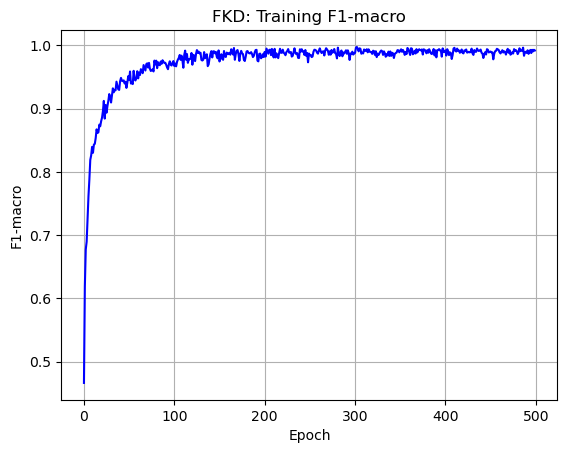

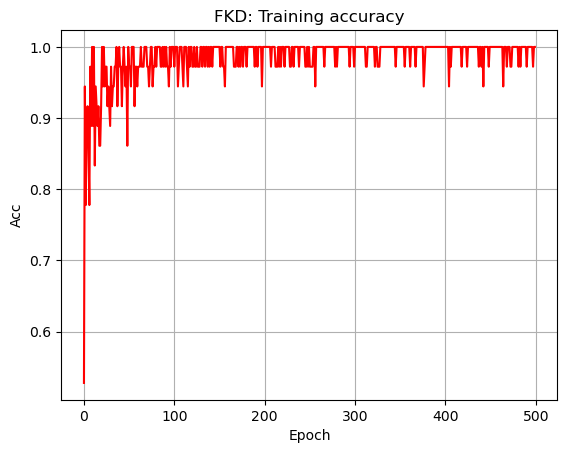

In [172]:
plt.figure(110)
plt.plot(f1_train, 'b')
plt.title(f'FKD: Training F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

plt.figure(111)
plt.plot(corrects_train, 'r')
plt.title(f'FKD: Training accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.grid()

# Plotting validation results

<function matplotlib.pyplot.show(close=None, block=None)>

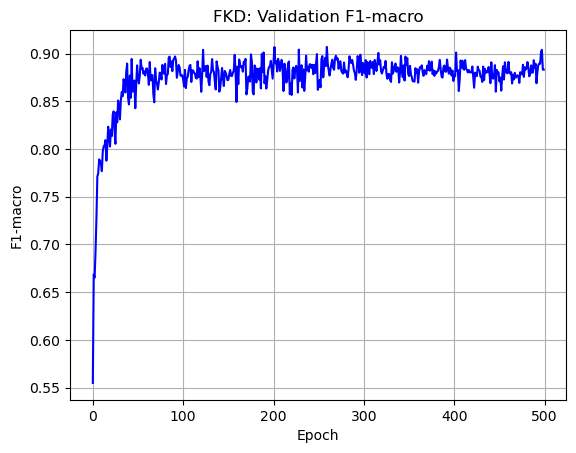

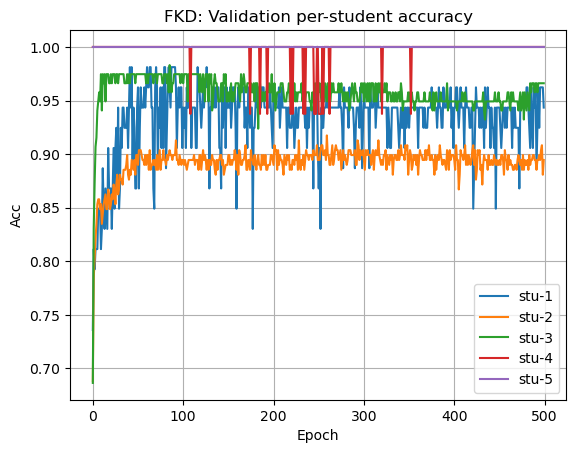

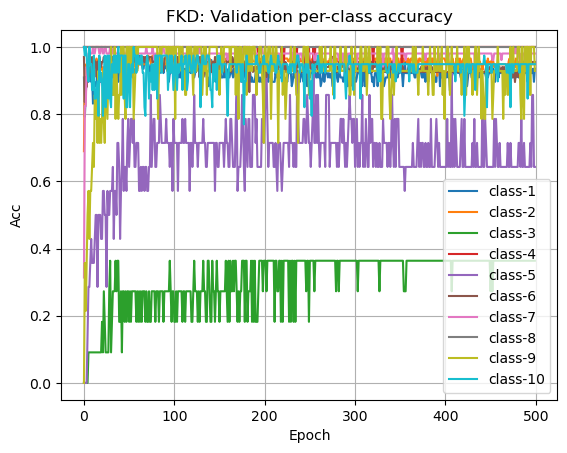

In [173]:
plt.figure(110)
plt.plot(f1_test, 'b')
plt.title(f'FKD: Validation F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

corrects_test_numpy = np.squeeze(np.array(corrects_test))
lgd_str = []
for i in range(num_clusters):
    lgd_str.append('stu-'+str(i+1))
    
plt.figure(111)
for line in corrects_test_numpy.T:
    
    plt.plot(line)
    
plt.title(f'FKD: Validation per-student accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

corrects_test_numpy2 = np.squeeze(np.array(perClassCorrects_ten))
lgd_str = []
for i in range(num_classes):
    lgd_str.append('class-'+str(i+1))
    
plt.figure(15514)
for line in corrects_test_numpy2.T:
    
    plt.plot(line)
    
plt.title(f'FKD: Validation per-class accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

# Save results

In [174]:
np.savetxt(f"NoInitFKD_f1_test_{num_clusters}clusters.csv", f1_test, delimiter=",")
np.savetxt(f"NoInitFKD_f1_train_{num_clusters}clusters.csv", f1_train, delimiter=",")

np.savetxt(f"NoInitFKD_per_student_acc_test_{num_clusters}clusters.csv", corrects_test_numpy, delimiter=",")
np.savetxt(f"NoInitFKD_per_class_acc_test_{num_clusters}clusters.csv", corrects_test_numpy2, delimiter=",")
np.savetxt(f"NoInitFKD_total_acc_train_{num_clusters}clusters.csv", corrects_train, delimiter=",")



# RKD

## Policy model: Simple logistic regression

In [175]:
# Step 5: Reinforcement Learning for Sample Weights (RKD)
class PolicyAgent(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyAgent, self).__init__()
        self.fc = nn.Linear(state_dim, action_dim)

    def forward(self, state):
        return torch.sigmoid(self.fc(state)).mean(dim=0)   # Logistic regression model

In [176]:
def train_policy_agent(agent, experiences, lr, r_bst, optimizer=None):
    for state, action, reward in experiences:
        if reward>r_bst:
            log_prob = torch.log(action).sum()
            loss = -log_prob * reward
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                agent = policy_gradient_descent(agent,loss,lr)
    return r_bst
def policy_gradient_descent(agent,loss,lr):
    loss.backward()
    for param in agent.parameters():
        param.data = param.data - lr*param.grad.data
        param.grad.data.zero_()
    return agent   

## RKD Training Pipeline

In [177]:
def get_cluster(class_label,class_to_cluster,shift=1):
    cluster_ids = np.array(list(class_to_cluster.values()))
    class_ids = np.array(list(map(int,list(class_to_cluster.keys()))))-shift
    target_class_id = np.where(class_ids==class_label)
    return cluster_ids[target_class_id].item()

In [178]:
def validate_students(students,test_loader):
    
    per_studnet_corrects = torch.zeros((len(students),1))
    per_class_corrects = torch.zeros((num_classes,1))
    
    per_cluster_count = torch.zeros((len(students),1))
    per_class_count = torch.zeros((num_classes,1))
    for cluster_id in range(len(students)):
        with torch.no_grad():
            students[cluster_id].eval()
            
    student_logits = []
    label_list = []
    for i, (x, y) in enumerate(test_loader):
        cluster_id = get_cluster(y.item(),class_to_cluster)-1
        logits = students[cluster_id](x)
        _,pred = torch.max(logits,1)
        per_studnet_corrects[cluster_id]+=torch.sum(pred==y)
        per_cluster_count[cluster_id]+=1
        per_class_corrects[y.item()]+=torch.sum(pred==y)
        per_class_count[y.item()]+=1
        student_logits.append(logits)
        label_list.append(y)

    student_logits_torch = torch.cat(student_logits, dim=0)
    label_list_torch = torch.cat(label_list, dim=0)

    reward = multiclass_f1_score(student_logits_torch, label_list_torch, num_classes=10, average="macro")
    return per_studnet_corrects/per_cluster_count, per_class_corrects/per_class_count, reward

In [180]:
seed=5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# Instantiate the teacher network
hidden_dim=56
teacher_model = TeacherNet(num_features, hidden_dim, num_classes)

# Instantiate the student network
students = {}
for cluster_id in range(num_clusters):
    student_model = StudentNet(num_features, hidden_dim, num_classes)
    students[cluster_id] = student_model
    

agent = PolicyAgent(num_features+2*num_classes,num_classes)
lr=1e-3
lamda=0.5
T=5
disp_cycle=5
r_bst = 0
epochs = 500
f1_train=[]
f1_test=[]
corrects_train = []
corrects_test = []
perClassCorrects_ten = []
loss_train=[]
teacher_model.train()
optim_T = optim.Adam(teacher_model.parameters(), lr=lr)
optim_S = {}
for cluster_id in range(len(students)):
    optim_S[cluster_id] = optim.Adam(students[cluster_id].parameters(), lr=lr)


# experiences = []
# exp_size = 2000

torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    experiences = []
    for student in students.values():
        student.train()
    sum_loss=0
    sum_rewards=0
    student_corrects=0
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch_teacher = []
        y_batch_teacher = []
        student_logits = []
        batch_clusters=np.array([])
        for y in y_batch:
            batch_clusters = np.append(batch_clusters,get_cluster(y.item(),class_to_cluster))
        for cluster_id in range(len(students)):
            idx = np.where(batch_clusters==cluster_id+1)
            x_batch_clustered = x_batch[idx] 
            y_batch_clustered = y_batch[idx]
            logits = students[cluster_id](x_batch_clustered)

            student_logits.append(logits)
            x_batch_teacher.append(x_batch_clustered)

            y_batch_teacher.append(y_batch_clustered)

        student_logits = torch.cat(student_logits, dim=0)

        x_batch_teacher = torch.cat(x_batch_teacher, dim=0)
        y_batch_teacher = torch.cat(y_batch_teacher, dim=0)

        teacher_logits = teacher_model(x_batch_teacher)


        teacher_softmax = torch.softmax(teacher_logits, dim=1)
        student_softmax = torch.softmax(student_logits, dim=1)
        
        # Concatenate the softmax outputs along with x_batch_teacher
        state = torch.cat((x_batch_teacher, teacher_softmax, student_softmax), dim=1).detach()

        sample_weights = agent(state)

        sample_weights_no_grad = sample_weights.detach()
        L_T = F.cross_entropy(teacher_logits, y_batch_teacher, sample_weights_no_grad) # eq 10 (Supervised loss for the teacher)

        optim_T.zero_grad()
        L_T.backward(retain_graph = True)
        optim_T.step()

        L_SS = lamda * F.cross_entropy(student_logits, y_batch_teacher,sample_weights_no_grad) # 1st term of eq 11 (the supervised part)

        L_TS = (1-lamda) * F.cross_entropy(student_logits/T, torch.softmax(teacher_logits.detach()/T, dim=1).detach(),sample_weights_no_grad) # 2nd term of eq 11 (the transfer learning part)

        L_S = L_TS + L_SS

        for cluster_id in range(len(students)):
            optim_S[cluster_id].zero_grad()
        

        L_S.backward()

        for cluster_id in range(len(students)):
            optim_S[cluster_id].step()

        
        
        _,pred = torch.max(student_logits,1)
        reward = f1_score(y_batch_teacher.cpu().numpy(), pred.cpu().numpy(), average='macro')
        experiences.append((state, sample_weights, reward))
        # if len(experiences) >= exp_size:
        #     experiences = experiences[-exp_size:]
        student_corrects+= torch.sum(pred==y_batch_teacher)
        sum_loss+=L_S
        sum_rewards+=reward
        if (i+1)%disp_cycle==0:
            print(f'Batch {i+1} : F1-macro = {reward}, Losses (T, S): ({L_T}, {L_S}), student acc = {torch.sum(pred==y_batch_teacher)/x_batch.shape[0]}')
        
    r_bst = train_policy_agent(agent, experiences, r_bst, lr)
    per_studnet_corrects_test, per_class_corrects_test, f1_score_test = validate_students(students,val_loader)

    
    print(f'Epoch {epoch}- Validation: Average F1-macro: {f1_score_test}, Per student acc: {per_studnet_corrects_test.view(-1)}')
    print('####################################################################################################################')
    f1_train.append(sum_rewards/(i+1))
    f1_test.append(f1_score_test)
    corrects_train.append(torch.sum(pred==y_batch_teacher)/x_batch.shape[0])
    corrects_test.append(per_studnet_corrects_test)
    perClassCorrects_ten.append(per_class_corrects_test)
    loss_train.append(sum_loss/(i+1))

Batch 5 : F1-macro = 0.3560606060606061, Losses (T, S): (2.228174924850464, 1.6424593925476074), student acc = 0.53125
Batch 10 : F1-macro = 0.5638349885408709, Losses (T, S): (2.1728198528289795, 1.5670561790466309), student acc = 0.71875
Batch 15 : F1-macro = 0.6509584429495442, Losses (T, S): (2.0911386013031006, 1.4644112586975098), student acc = 0.75
Batch 20 : F1-macro = 0.5931546489563567, Losses (T, S): (1.969155192375183, 1.320991039276123), student acc = 0.796875
Batch 25 : F1-macro = 0.6329643395819866, Losses (T, S): (1.8542892932891846, 1.2316510677337646), student acc = 0.734375
Epoch 0- Validation: Average F1-macro: 0.5530480146408081, Per student acc: tensor([0.7358, 0.6927, 0.6780, 1.0000, 1.0000])
####################################################################################################################
Batch 5 : F1-macro = 0.5396942167802246, Losses (T, S): (1.7488951683044434, 1.1189334392547607), student acc = 0.734375
Batch 10 : F1-macro = 0.5544041654386

# Plotting training results

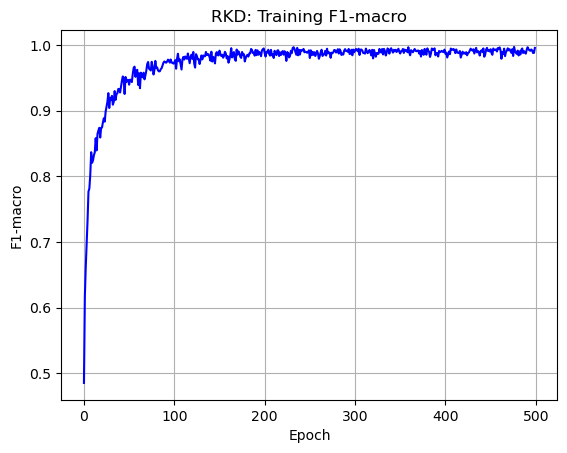

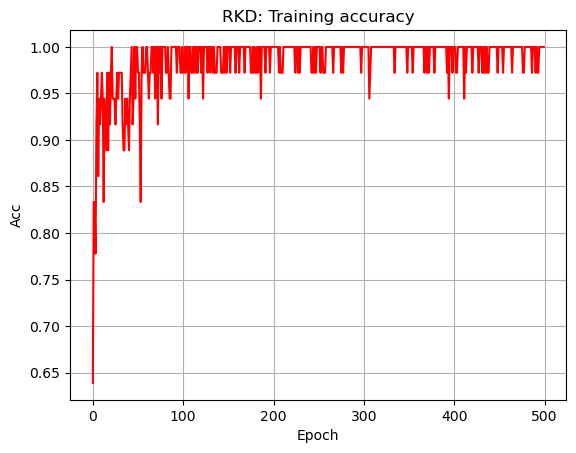

In [182]:
plt.figure(110)
plt.plot(f1_train, 'b')
plt.title(f'RKD: Training F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

plt.figure(111)
plt.plot(corrects_train, 'r')
plt.title(f'RKD: Training accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.grid()

# Plotting validation results

<function matplotlib.pyplot.show(close=None, block=None)>

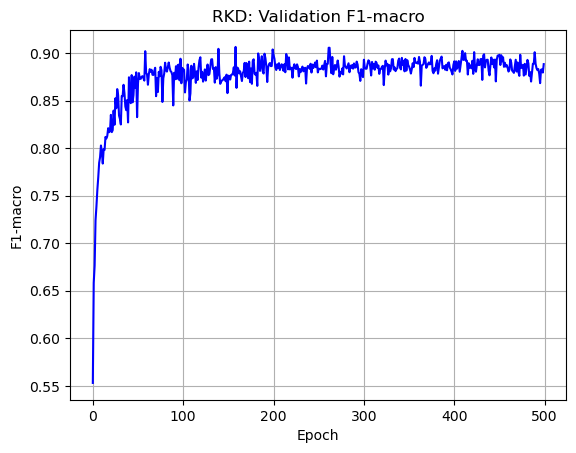

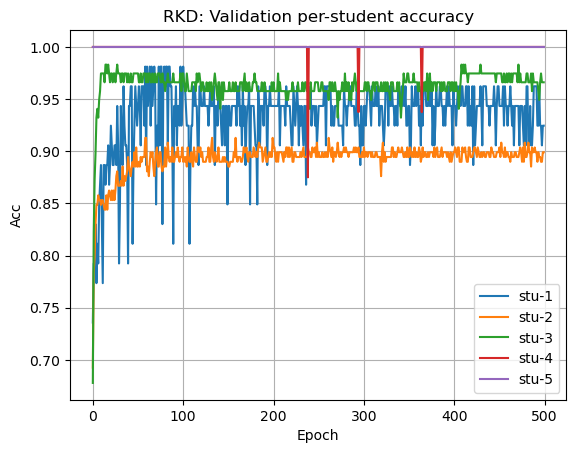

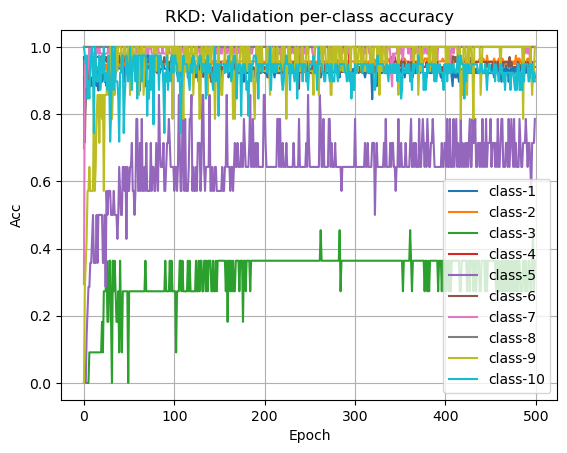

In [183]:
plt.figure(110)
plt.plot(f1_test, 'b')
plt.title(f'RKD: Validation F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

corrects_test_numpy = np.squeeze(np.array(corrects_test))
lgd_str = []
for i in range(num_clusters):
    lgd_str.append('stu-'+str(i+1))
    
plt.figure(111)
for line in corrects_test_numpy.T:
    
    plt.plot(line)
    
plt.title(f'RKD: Validation per-student accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

corrects_test_numpy2 = np.squeeze(np.array(perClassCorrects_ten))
lgd_str = []
for i in range(num_classes):
    lgd_str.append('class-'+str(i+1))
    
plt.figure(15514)
for line in corrects_test_numpy2.T:
    
    plt.plot(line)
    
plt.title(f'RKD: Validation per-class accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

# Save results

In [184]:
np.savetxt(f"NoInitRKD_f1_test_{num_clusters}clusters.csv", f1_test, delimiter=",")
np.savetxt(f"NoInitRKD_f1_train_{num_clusters}clusters.csv", f1_train, delimiter=",")

np.savetxt(f"NoInitRKD_per_student_acc_test_{num_clusters}clusters.csv", corrects_test_numpy, delimiter=",")
np.savetxt(f"NoInitRKD_per_class_acc_test_{num_clusters}clusters.csv", corrects_test_numpy2, delimiter=",")
np.savetxt(f"NoInitRKD_total_acc_train_{num_clusters}clusters.csv", corrects_train, delimiter=",")

# np.savetxt("NoInitRKD_f1_test.csv", f1_test, delimiter=",")

In [190]:
num_features+2*num_classes

41

# RKD

## Policy model: REINFORCE (Attempted to do it the official way using Gaussian distribution for sampling but failed)

In [39]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, hidden_size, num_outputs):

       	super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, num_outputs)       # Mean for the sample weight (scalar)
        self.fc_logstd = nn.Linear(hidden_dim, num_outputs)   # Log standard deviation

    def forward(self, state):
        """
        Given a state, output a sample action and its log probability.
        """
        x = torch.relu(self.fc1(state))
        mu = self.fc_mu(x)
        log_std = self.fc_logstd(x)
        std = torch.exp(log_std)
        # Create a Normal distribution with mean and std.
        normal_dist = dist.Normal(mu, std)
        # Use rsample for reparameterization.
        action = normal_dist.rsample()
        log_prob = normal_dist.log_prob(action)
        # Return both the sampled action (scalar) and its log probability.
        return action, log_prob

In [35]:
def update_policy(policy_net, policy_optimizer, replay_buffer,r_bst):
    """
    Update the policy network parameters using the REINFORCE algorithm.
    The replay_buffer should be a list of tuples (state, action, reward),
    where state is a tensor (the state input), action is the action taken (scalar),
    and reward is the observed reward.
    The update is based on:
        L = - (1/N) * Sum [ reward * log π(action|state) ]
    """
    policy_net.train()
    policy_loss = 0.0
    for (state, action, reward) in replay_buffer:
        # Forward pass: get a new sample and log probability for the state.
        # (Note: In practice, you might want to use the stored log probability,
        # but here we recompute it for clarity.)
        if reward>r_bst:
        #     log_prob = torch.log(action)
        #     loss_sample = -reward * log_prob.sum()
        #     policy_loss += loss_sample
        #     r_bst=reward
        # else:
            _, log_prob = policy_net(state)
            # REINFORCE loss for this sample.
            loss_sample = -reward * log_prob.sum()
            policy_loss += loss_sample
    policy_loss = policy_loss / len(replay_buffer)
    
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    return r_bst

## RKD Training Pipeline

In [36]:
def get_cluster(class_label,class_to_cluster,shift=1):
    cluster_ids = np.array(list(class_to_cluster.values()))
    class_ids = np.array(list(map(int,list(class_to_cluster.keys()))))-shift
    target_class_id = np.where(class_ids==class_label)
    return cluster_ids[target_class_id].item()

In [37]:
def validate_students(students,test_loader):
    
    per_studnet_corrects = torch.zeros((len(students),1))
    per_class_corrects = torch.zeros((num_classes,1))
    
    per_cluster_count = torch.zeros((len(students),1))
    per_class_count = torch.zeros((num_classes,1))
    for cluster_id in range(len(students)):
        with torch.no_grad():
            students[cluster_id].eval()
            
    student_logits = []
    label_list = []
    for i, (x, y) in enumerate(test_loader):
        cluster_id = get_cluster(y.item(),class_to_cluster)-1
        logits = students[cluster_id](x)
        _,pred = torch.max(logits,1)
        per_studnet_corrects[cluster_id]+=torch.sum(pred==y)
        per_cluster_count[cluster_id]+=1
        per_class_corrects[y.item()]+=torch.sum(pred==y)
        per_class_count[y.item()]+=1
        student_logits.append(logits)
        label_list.append(y)

    student_logits_torch = torch.cat(student_logits, dim=0)
    label_list_torch = torch.cat(label_list, dim=0)
    # print(student_logits_torch.shape,label_list_torch.shape)

    reward = multiclass_f1_score(student_logits_torch, label_list_torch, num_classes=10, average="macro")
    return per_studnet_corrects/per_cluster_count, per_class_corrects/per_class_count, reward

In [40]:
seed=5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

# Instantiate the teacher network
teacher_model = TeacherNet(num_features, hidden_dim, num_classes)

# Instantiate the student network
hidden_dim=56
students = {}
for cluster_id in range(num_clusters):
    student_model = StudentNet(num_features, hidden_dim, num_classes)
    students[cluster_id] = student_model
    
agent = PolicyNet(num_features+2*num_classes, 50, num_classes)
policy_optimizer = optim.Adam(agent.parameters(), lr=0.001)
lr=1e-3
lamda=0.5
T=5
disp_cycle=5
r_bst = 0
epochs = 500
f1_train=[]
f1_test=[]
corrects_train = []
corrects_test = []
perClassCorrects_ten = []
loss_train=[]
teacher_model.train()
optim_T = optim.Adam(teacher_model.parameters(), lr=lr)
optim_S = {}
for cluster_id in range(len(students)):
    optim_S[cluster_id] = optim.Adam(students[cluster_id].parameters(), lr=lr)


experiences = []
exp_size = 2000

torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    
    for student in students.values():
        student.train()
    sum_loss=0
    sum_rewards=0
    # per_studnet_corrects = np.zeros((len(students),1))
    student_corrects=0
    
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # teacher_model.train()
        #print(x_batch.shape)
        x_batch_teacher = []
        y_batch_teacher = []
        student_logits = []
        batch_clusters=np.array([])
        for y in y_batch:
            #batch_clusters.append(get_cluster(y.item(),class_to_cluster))
            batch_clusters = np.append(batch_clusters,get_cluster(y.item(),class_to_cluster))
        for cluster_id in range(len(students)):
            idx = np.where(batch_clusters==cluster_id+1)
            x_batch_clustered = x_batch[idx] 
            y_batch_clustered = y_batch[idx]
            logits = students[cluster_id](x_batch_clustered)
            # _,pred = torch.max(logits,1)
            # student_corrects = torch.sum(pred==y_batch_clustered)
            # per_studnet_corrects[cluster_id]+=student_corrects
            student_logits.append(logits)
            x_batch_teacher.append(x_batch_clustered)
            # print(logits.shape,x_batch_clustered.shape,y_batch_clustered.shape)
            y_batch_teacher.append(y_batch_clustered)

        student_logits = torch.cat(student_logits, dim=0)
        # print(x_batch_teacher.shape)
        x_batch_teacher = torch.cat(x_batch_teacher, dim=0)
        y_batch_teacher = torch.cat(y_batch_teacher, dim=0)
        # print(x_batch_teacher.shape,y_batch_teacher.shape,student_logits.shape)
        teacher_logits = teacher_model(x_batch_teacher)
        # print(teacher_logits.requires_grad)
        # print(x_batch_teacher.shape,teacher_logits.shape,student_logits.shape)
        # print(x_batch_teacher.shape,torch.softmax(teacher_logits, dim=1).shape,torch.softmax(student_logits, dim=1).shape)
        # state = torch.cat((x_batch_teacher, torch.softmax(teacher_logits.detach(), dim=1), torch.softmax(student_logits, dim=1)), dim=1).detach()
        teacher_softmax = torch.softmax(teacher_logits, dim=1)
        student_softmax = torch.softmax(student_logits, dim=1)
        
        # Concatenate the softmax outputs along with x_batch_teacher
        state = torch.cat((x_batch_teacher, teacher_softmax, student_softmax), dim=1).detach()
        # print(x_batch_teacher.shape,teacher_logits.shape,student_logits.shape,state.shape)
        _, sample_weights = agent(state)
        sample_weights = sample_weights.mean(dim=0)
        # print('1')
        # print(sample_weights)
        # sample_weights.requires_grad = False
        sample_weights_no_grad = sample_weights.detach()
        L_T = F.cross_entropy(teacher_logits, y_batch_teacher, sample_weights_no_grad) # eq 10 (Supervised loss for the teacher)
        # print('2')
        # print(sample_weights)
        optim_T.zero_grad()
        L_T.backward(retain_graph = True)
        optim_T.step()
        # for param in teacher_model.parameters():
        #     print(param.requires_grad,param.grad)
        # teacher_model.eval()
        L_SS = lamda * F.cross_entropy(student_logits, y_batch_teacher,sample_weights_no_grad) # 1st term of eq 11 (the supervised part)
        # print('3')
        # print(sample_weights)
        # print(teacher_logits)
        L_TS = (1-lamda) * F.cross_entropy(student_logits/T, torch.softmax(teacher_logits.detach()/T, dim=1).detach(),sample_weights_no_grad) # 2nd term of eq 11 (the transfer learning part)
        # print(teacher_logits)
        L_S = L_TS + L_SS
        # print('4')
        # print(sample_weights)
        for cluster_id in range(len(students)):
            optim_S[cluster_id].zero_grad()
        
        # enum=enumerate(teacher_model.parameters())
        # ix,param=next(enum)
        # ix,param=next(enum)
        # ix,param=next(enum)
        # print(ix,param)
        L_S.backward()
        # print('5')
        # print(sample_weights)
        # print(ix,param)
        for cluster_id in range(len(students)):
            optim_S[cluster_id].step()
        # for student in students.values():
        #     for param in student.parameters():
        #         print(param.requires_grad,param.grad)
        # reward = multiclass_f1_score(student_logits, y_batch_teacher, num_classes=10, average="macro")
        # reward = f1(student_logits.detach(), y_batch_teacher[:,None])
        
        
        _,pred = torch.max(student_logits,1)
        reward = f1_score(y_batch_teacher.cpu().numpy(), pred.cpu().numpy(), average='macro')
        experiences.append((state, sample_weights, reward))
        if len(experiences) >= exp_size:
            experiences = experiences[-exp_size:]
        student_corrects+= torch.sum(pred==y_batch_teacher)
        sum_loss+=L_S
        sum_rewards+=reward
        if (i+1)%disp_cycle==0:
            print(f'Batch {i+1} : F1-macro = {reward}, Losses (T, S): ({L_T}, {L_S}), student acc = {torch.sum(pred==y_batch_teacher)/x_batch.shape[0]}')
        
    r_bst = update_policy(agent, policy_optimizer, experiences,r_bst)
    per_studnet_corrects_test, per_class_corrects_test, f1_score_test = validate_students(students,val_loader)

    
    print(f'Epoch {epoch}- Validation: Average F1-macro: {f1_score_test}, Per student acc: {per_studnet_corrects_test.view(-1)}')
    print('####################################################################################################################')
    f1_train.append(sum_rewards/(i+1))
    f1_test.append(f1_score_test)
    corrects_train.append(torch.sum(pred==y_batch_teacher)/x_batch.shape[0])
    corrects_test.append(per_studnet_corrects_test)
    perClassCorrects_ten.append(per_class_corrects_test)
    loss_train.append(sum_loss/(i+1))

Batch 5 : F1-macro = 0.2727009728622632, Losses (T, S): (2.2046310901641846, -0.5093362331390381), student acc = 0.375
Batch 10 : F1-macro = 0.39840686274509807, Losses (T, S): (2.2004756927490234, -0.6734007596969604), student acc = 0.5625
Batch 15 : F1-macro = 0.4349908424908425, Losses (T, S): (2.108822822570801, -0.7808455228805542), student acc = 0.625
Batch 20 : F1-macro = 0.4288528463041207, Losses (T, S): (2.0904269218444824, -0.8966588377952576), student acc = 0.640625
Batch 25 : F1-macro = 0.566805771221532, Losses (T, S): (1.8733593225479126, -0.9808394312858582), student acc = 0.734375
Epoch 0- Validation: Average F1-macro: 0.4165525436401367, Per student acc: tensor([0.7358, 0.6422, 0.5522, 1.0000])
####################################################################################################################
Batch 5 : F1-macro = 0.4346776589423648, Losses (T, S): (1.7247962951660156, -1.116781234741211), student acc = 0.640625
Batch 10 : F1-macro = 0.476023705291998,

RuntimeError: Function 'PowBackward0' returned nan values in its 0th output.

# Plotting training results

In [ ]:
plt.figure(110)
plt.plot(f1_train, 'b')
plt.title(f'RKD: Training F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

plt.figure(111)
plt.plot(corrects_train, 'r')
plt.title(f'RKD: Training accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.grid()

# Plotting validation results

In [ ]:
plt.figure(110)
plt.plot(f1_test, 'b')
plt.title(f'RKD: Validation F1-macro')
plt.xlabel(f'Epoch')
plt.ylabel(f'F1-macro')
plt.grid()

corrects_test_numpy = np.squeeze(np.array(corrects_test))
lgd_str = []
for i in range(num_clusters):
    lgd_str.append('stu-'+str(i+1))
    
plt.figure(111)
for line in corrects_test_numpy.T:
    
    plt.plot(line)
    
plt.title(f'RKD: Validation per-student accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

corrects_test_numpy2 = np.squeeze(np.array(perClassCorrects_ten))
lgd_str = []
for i in range(num_classes):
    lgd_str.append('class-'+str(i+1))
    
plt.figure(15514)
for line in corrects_test_numpy2.T:
    
    plt.plot(line)
    
plt.title(f'RKD: Validation per-class accuracy')
plt.xlabel(f'Epoch')
plt.ylabel(f'Acc')
plt.legend(lgd_str)
plt.grid()
plt.show

# Save results

In [ ]:
np.savetxt("NoInitRKD_REINFORCE_f1_test.csv", f1_test, delimiter=",")
np.savetxt("NoInitRKD_REINFORCE_f1_train.csv", f1_train, delimiter=",")

np.savetxt("NoInitRKD_REINFORCE_per_student_acc_test.csv", corrects_test_numpy, delimiter=",")
np.savetxt("NoInitRKD_REINFORCE_per_class_acc_test.csv", corrects_test_numpy2, delimiter=",")
np.savetxt("NoInitRKD_REINFORCE_total_acc_train.csv", corrects_train, delimiter=",")

np.savetxt("NoInitRKD_REINFORCE_f1_test.csv", f1_test, delimiter=",")

In [162]:
experiences[0][-1],reward

(tensor(0.0831), tensor(0.3380))